In [187]:
import sys
sys.path.append('sam_road')
sys.path.append('road_extract')
print (sys.path)
import json
import argparse
import sam_road.SAM_ROAD as sam_road
import sam_box.SAM_box as sam

import road_extract.road_extraction as road_ex

import matplotlib.pyplot as plt
import cv2

from skimage import measure
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime
import os
#data clearning

['/home/kt/python/RemoteSeg', '/home/kt/anaconda3/envs/SAM/lib/python310.zip', '/home/kt/anaconda3/envs/SAM/lib/python3.10', '/home/kt/anaconda3/envs/SAM/lib/python3.10/lib-dynload', '', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/mmpose-0.28.0-py3.10.egg', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/xtcocotools-1.14.3-py3.10-linux-x86_64.egg', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/munkres-1.1.4-py3.10.egg', '/home/kt/python/Grounded-Segment-Anything/recognize-anything', '/home/kt/python/Grounded-Segment-Anything/segment_anything', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/setuptools/_vendor', 'sam_road', 'road_extract', 'sam_road', 'road_extract', 'sam_road', 'road_extract', 'sam_road', 'road_extract']


In [188]:
def resize_to_square_and_pad(image_source, scale):
    """
    Resize the image to a square with dimensions divisible by 256,
    then resize it by dividing dimensions by the given scale and add padding.

    Parameters:
        image_source (numpy.ndarray): The input image.
        scale (int): The scaling divisor (e.g., 1, 2, 4, 8, ...).

    Returns:
        numpy.ndarray: The resized, squared, and padded image.
    """
    # Original dimensions
    original_height, original_width = image_source.shape[:2]
    
    # Calculate the next multiple of 256 for the larger dimension
    max_dim = max(original_height, original_width)
    square_dim = ((max_dim + 255) // 256) * 256  # Round up to the nearest multiple of 256

    # Resize the image to square dimensions
    resized_to_square = cv2.resize(image_source, (square_dim, square_dim), interpolation=cv2.INTER_AREA)
    
    # Compute scaled dimensions
    new_dim = max(1, square_dim // scale)

    # Resize the square image by the given scale
    resized_image = cv2.resize(resized_to_square, (new_dim, new_dim), interpolation=cv2.INTER_AREA)

    # Calculate padding to restore the image to the original square dimensions
    delta_width = square_dim - new_dim
    delta_height = square_dim - new_dim

    top = delta_height // 2
    bottom = delta_height - top
    left = delta_width // 2
    right = delta_width - left

    # Add padding
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

def remove_padding_and_resize(image_padded, original_size):
    """
    Remove padding from an image and resize it back to its original size.

    Parameters:
        image_padded (numpy.ndarray): The padded image.
        original_size (tuple): The original size of the image (height, width).

    Returns:
        numpy.ndarray: The image resized back to its original size.
    """
    # Identify the non-zero region (content without padding)
    gray_image = cv2.cvtColor(image_padded, cv2.COLOR_BGR2GRAY) if len(image_padded.shape) == 3 else image_padded
    _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    x, y, w, h = cv2.boundingRect(binary_mask)

    # Crop the region of interest (ROI) without padding
    cropped_image = image_padded[y:y+h, x:x+w]

    # Resize back to the original size
    resized_to_original = cv2.resize(cropped_image, (original_size[1], original_size[0]), interpolation=cv2.INTER_AREA)

    return resized_to_original

def combine_multiscale_results(scale_results, original_size, method='average'):
    """
    Combine multi-scale results into a single result.

    Parameters:
        scale_results (list): A list of results (masks or probability maps) at different scales.
        original_size (tuple): The original size of the image (height, width).
        method (str): Combination method - 'average' or 'max'.

    Returns:
        numpy.ndarray: The combined result resized to the original image size.
    """
    combined_result = np.zeros(original_size, dtype=np.float32)

    for result in scale_results:
        # Resize each result back to the original size
        resized_result = cv2.resize(result, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)
        
        # Combine the results based on the selected method
        if method == 'average':
            combined_result += resized_result
        elif method == 'max':
            combined_result = np.maximum(combined_result, resized_result)
        else:
            raise ValueError("Invalid method. Use 'average' or 'max'.")

    # For averaging, divide by the number of scales
    if method == 'average':
        combined_result /= len(scale_results)

    # Normalize the result if necessary
    combined_result = np.clip(combined_result, 0, 255).astype(np.uint8)
    return combined_result

def combine_multiscale_results(scale_results, scales, original_size, method='average'):
 
    combined_result = np.zeros(original_size, dtype=np.float32)

    for idx, (result, scale) in enumerate(zip(scale_results, scales)):
        print(f"Processing scale {scale} - result shape: {result.shape}")

        # Step 1: Reverse padding to restore to square resolution (if padding was added)
        target_size = (int(original_size[1] * scale), int(original_size[0] * scale))
        if result.shape[:2] != target_size:
            print(f"Resizing result {idx} to {target_size}")
            result = cv2.resize(result, target_size, interpolation=cv2.INTER_LINEAR)
        
        # Step 2: Resize result back to the original image size
        resized_result = cv2.resize(result, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)

        # Step 3: Combine results
        if method == 'average':
            combined_result += resized_result
        elif method == 'max':
            combined_result = np.maximum(combined_result, resized_result)
        else:
            raise ValueError("Invalid method. Use 'average' or 'max'.")

    # Normalize results
    if method == 'average':
        combined_result /= len(scale_results)

    # Clip the results to ensure valid range (e.g., for masks)
    combined_result = np.clip(combined_result, 0, 255).astype(np.uint8)
    return combined_result

In [42]:
def generate_segmentation_MAID():
    m_aid_dir = ""
    return

def read_detection_json(json_path):
    file_json = open(json_path)
    json_obj = json.load(file_json)
    data_json = json_obj['data']

    return data_json

# def create_sub_masks(mask_image, width, height):
#     # Initialize a dictionary of sub-masks indexed by RGB colors
#     sub_masks = {}
#     for x in range(width):
#         for y in range(height):
#             # Get the RGB values of the pixel
#             pixel = mask_image.getpixel((x, y))[:3]

#             # Check to see if we have created a sub-mask...
#             pixel_str = str(pixel)
#             sub_mask = sub_masks.get(pixel_str)
#             if sub_mask is None:
#                 # Create a sub-mask (one bit per pixel) and add to the dictionary
#                 # Note: we add 1 pixel of padding in each direction
#                 # because the contours module doesn"t handle cases
#                 # where pixels bleed to the edge of the image
#                 sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

#             # Set the pixel value to 1 (default is 0), accounting for padding
#             sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

#     return sub_masks

# def create_sub_masks(mask_array, width, height):
#     """
#     Create sub-masks from a numpy array representation of a mask.
    
#     Args:
#         mask_array (numpy.ndarray): The input mask as a NumPy array. Can be grayscale (2D) or RGB (3D).
#         width (int): The width of the mask.
#         height (int): The height of the mask.

#     Returns:
#         dict: A dictionary where keys are unique values (or RGB tuples for RGB images),
#               and values are binary NumPy arrays (sub-masks).
#     """
#     # Initialize a dictionary of sub-masks
#     sub_masks = {}
    
#     # Check if the mask is grayscale (2D) or RGB (3D)
#     if mask_array.ndim == 2:
#         # Grayscale: Extract unique values
#         unique_values = np.unique(mask_array)
#         for value in unique_values:
#             # Create a binary mask for the current value
#             color_mask = (mask_array == value)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(value)] = padded_mask.astype(np.uint8)
#     elif mask_array.ndim == 3:
#         # RGB: Extract unique RGB values
#         unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
#         for color in unique_colors:
#             # Create a binary mask for the current color
#             color_mask = np.all(mask_array == color, axis=-1)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(tuple(color))] = padded_mask.astype(np.uint8)
#     else:
#         raise ValueError("mask_array must be either 2D (grayscale) or 3D (RGB).")

#     return sub_masks

# def create_sub_mask_annotation(sub_mask):
#     # Find contours (boundary lines) around each sub-mask
#     # Note: there could be multiple contours if the object
#     # is partially occluded. (E.g. an elephant behind a tree)
#     contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

#     polygons = []
#     segmentations = []
#     number = 0
#     for contour in contours:
#         # Flip from (row, col) representation to (x, y)
#         # and subtract the padding pixel
#         for i in range(len(contour)):
#             row, col = contour[i]
#             contour[i] = (col - 1, row - 1)

#         # if number == 94:
#         #     test = 1
#         # Make a polygon and simplify it
#         poly = Polygon(contour)
#         poly = poly.simplify(1.0, preserve_topology=False)

#         if (poly.is_empty):
#             # Go to next iteration, dont save empty values in list
#             continue

#         polygons.append(poly)

#         if isinstance(poly, MultiPolygon):
#             # Handle multiple Polygons
#             # print("Result is a MultiPolygon:")
#             for i, sub_poly in enumerate(poly.geoms):
#                 segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
#                 segmentations.append(segmentation)
#         elif isinstance(poly, Polygon):
#             segmentation = np.array(poly.exterior.coords).ravel().tolist()
#             segmentations.append(segmentation)
#         # number = number + 1
#         # print(poly)
#         # print(number)

#     return polygons, segmentations

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x, y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
                # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

    return sub_masks


def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    number = 0
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # if number == 94:
        #     test = 1
        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)

        if (poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        if isinstance(poly, MultiPolygon):
            # Handle multiple Polygons
            # print("Result is a MultiPolygon:")
            for i, sub_poly in enumerate(poly.geoms):
                segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
                segmentations.append(segmentation)
        elif isinstance(poly, Polygon):
            segmentation = np.array(poly.exterior.coords).ravel().tolist()
            segmentations.append(segmentation)
        # number = number + 1
        # print(poly)
        # print(number)

    return polygons, segmentations


def generate_segmentation(args):

    #create df
    # Define the column names
    columns = ["image_path", "class", "roi", "dice","path"]
    # Create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=columns)
    
    #load models
    config_dir = "sam_road/config/"
    sam_road_checkpoint = "/home/datadisk/evaluation/models/SAM/SAM-road/"
    net_cityscale, config_cityscale = sam_road.load_sam_road(f"{config_dir}toponet_vitb_512_cityscale.yaml", f"{sam_road_checkpoint}cityscale_vitb_512_e10.ckpt", "cuda")
    net_spacenet, config_spacenet = sam_road.load_sam_road(f"{config_dir}toponet_vitb_256_spacenet.yaml", f"{sam_road_checkpoint}spacenet_vitb_256_e10.ckpt", "cuda")
    
    index = 23
    data_jsons = read_detection_json(args.json_path)[index:index+1]

    for data_json in data_jsons:
        ##NEED remove
        label = data_json['object_annotations'][0]['label']
        ###########
        image_sources, main_images, gt_images, dice_lists, box_lists, roi_mask_lists, local_image_paths, label_box_list, overlay_box_list = sam.sementation_call(data_json, args.data_path)
        
        
        
        for box_roi, dice_result, label_box, overlay_box in zip(box_lists[0],dice_lists[0],label_box_list, overlay_box_list):
            
            sam_box_dir = "/home/datadisk/pipe/results/sam_box/"
            save_folder = local_image_paths[0].split("/")[-1].split(".")[0]
            if not os.path.exists(sam_box_dir+save_folder):
                # Create the directory
                os.makedirs(sam_box_dir+save_folder)
            
            box_final_path = sam_box_dir+save_folder+"/"+label_box+'_'+datetime.now().strftime('%Y%m%d%H%M%S%f')+".jpg"
            cv2.imwrite(box_final_path, overlay_box)
            
            new_row = {"image_path": local_image_paths[0], "class": label_box, "roi": box_roi, "dice": dice_result, "path":box_final_path}
            df = df.append(new_row, ignore_index=True)
                
        image_name = data_json['image'][0].split("/")[-1]
        cv2.imwrite('/home/kt/segment_tmp/'+label+'_'+image_name,main_images[0])


        #print(roi_mask_lists)
        for image_source, main_image, local_image_path in zip(image_sources,main_images, local_image_paths):

            image_sourceCopy = image_source.copy()
            original_height, original_width = image_source.shape[:2]
            if original_height <256 or original_width <256:
                new_height = 256
                new_width = 256

                # Resize the image
                resized_image = cv2.resize(image_source, (new_width, new_height), interpolation=cv2.INTER_AREA)
                image_source = resized_image
#             print ("image shape: ",image_source.shape)



#             plt.imshow(main_image)
#             plt.show()

            ##ALL about road
            if (False):
                #road #1
                multi_scales = [1,2,3,4]
                scale_results = []
                scale_results_small = []
                for scale in multi_scales:
                    #print ("scale:", scale)
                    padded_image = resize_to_square_and_pad(image_source, scale)
                    plt.imshow(padded_image)
                    plt.show()
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, padded_image, config_spacenet)


                    overlay_image = sam_road.overlay_mask_on_image(padded_image, road_mask_spacenet, color=(0, 255, 0), alpha=0.2,th=15)

                    final_over = remove_padding_and_resize(overlay_image, image_source.shape)
                    final_scale_result = remove_padding_and_resize(road_mask_spacenet, image_source.shape)
                    scale_results.append(final_scale_result)

        #             plt.imshow(final_over)
        #             plt.show()

                    padded_image
                    img = cv2.resize(image_source,(1024,1024))
                    padded_image = resize_to_square_and_pad(img, scale)
                    mask, blended_image = road_ex.road_extraction_image(padded_image)

                    final_scale_result = remove_padding_and_resize(blended_image, img.shape)
                    scale_results_small.append(final_scale_result)
        #             plt.imshow(final_scale_result)
        #             plt.show()

                #combined_mask = combine_multiscale_results(scale_results, main_image.shape[:2], method='average')
                combined_mask = combine_multiscale_results(scale_results,multi_scales, main_image.shape[:2], method='average')
                combined_mask_small = combine_multiscale_results(scale_results_small,multi_scales, (1024,1024,3), method='average')
                overlay_image = sam_road.overlay_mask_on_image(main_image, combined_mask, color=(0, 255, 255), alpha=0.2,th=25)

                plt.imshow(overlay_image)
                plt.show()

                threshold = 25

                binary_mask = (combined_mask > threshold).astype(int)

        #         sub_mask = create_sub_masks(binary_mask,binary_mask.shape[1],binary_mask.shape[0])
        #         print (sub_mask)
                polygons, segmentations = create_sub_mask_annotation(binary_mask)

                #print (segmentations)
                
                print ('Sam TH:',threshold)
                plt.imshow(binary_mask)
                plt.show()      
                
                
                print ('sam')
                try:
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, image_sourceCopy, config_spacenet)
                    overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, road_mask_spacenet, color=(0, 255, 0), alpha=0.5,th=15)
                    plt.imshow(overlay_image)
                    plt.show()
                except:
                    print ('Error size need resize')
                
                print ('combined_mask_small combine')
                plt.imshow(combined_mask_small)
                plt.show()


                #road #2
                print ('combined_mask_small single')
                mask, blended_image = road_ex.road_extraction(local_image_path)
                plt.imshow(blended_image)
                plt.show()
                
    return df
                



parser = argparse.ArgumentParser()
parser.add_argument("--json-path", type=str, default="")
parser.add_argument("--data-path", type=str, default="/goss/Datasets/")
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/DOTA2.0/Annotations_train_hbb.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/million-AID/train_80_percent.json"]
sys.argv = ['test','--json-path', "/datadisk2/JSON/new_format/dataset2_JSON/iSAID/Annotations_val.json"]




#sys.argv = ['test','--json-path', 'hbb_detection_toyset.json']
#sys.argv = ['test','--json-path', "[PIX_SEG]BH-Pools_Watertanks_Datasets_Annotations_test.json"] 


args = parser.parse_args()

# Use the parsed arguments


df = generate_segmentation(args)


df.to_csv('/home/datadisk/pipe/results/sam_box/output.csv', index=False)
#read_detection_json(args)
print(f"json_path: {args.json_path}")

sam_road/config/toponet_vitb_512_cityscale.yaml
###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.

sam_road/config/toponet_vitb_256_spacenet.yaml
###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.q

KeyboardInterrupt: 

In [253]:
df1 = pd.read_csv("/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/output.csv")#'/home/datadisk/pipe/results/sam_box/output.csv')
df = df1
df

image_path             class  \
0     /goss/Datasets/LoveDA/Val/Rural/images_png/318...  agriculture area   
1     /goss/Datasets/LoveDA/Val/Rural/images_png/303...  agriculture area   
2     /goss/Datasets/LoveDA/Val/Rural/images_png/329...  agriculture area   
3     /goss/Datasets/LoveDA/Val/Urban/images_png/368...  agriculture area   
4     /goss/Datasets/LoveDA/Val/Urban/images_png/391...  agriculture area   
...                                                 ...               ...   
5376  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5377  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5378  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5379  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5380  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   

                              roi      dice  \
0      [560.5, 0.0, 395.5, 359.5]  0.731920   
1       [995.5, 0.0, 28.0, 337.5]  0.857986   
2     [193.5, 76.5, 264.0, 256.0]  0.863911   
3     [341.5, 51.5, 282.0, 143.0]  0.670620   
4       [0.0, 523.5, 24.5, 198.0]  0.418860   
...                           ...       ...   
5376   [316.5, 683.0, 10.0, 17.5]  0.770950   
5377    [95.5, 121.5, 41.0, 48.0]  0.701349   
5378  [610.5, 564.5, 145.0, 33.0]  0.806513   
5379   [327.5, 673.5, 25.0, 44.0]  0.836842   
5380   [380.5, 397.5, 12.0, 16.0]  0.680115   

                                                   path  
0     /home/datadisk/pipe/results/sam_box/toy_set/se...  
1     /home/datadisk/pipe/results/sam_box/toy_set/se...  
2     /home/datadisk/pipe/results/sam_box/toy_set/se...  
3     /home/datadisk/pipe/results/sam_box/toy_set/se...  
4     /home/datadisk/pipe/results/sam_box/toy_set/se...  
...                                                 ...  
5376  /home/datadisk/pipe/results/sam_box/toy_set/se...  
5377  /home/datadisk/pipe/results/sam_box/toy_set/se...  
5378  /home/datadisk/pipe/results/sam_box/toy_set/se...  
5379  /home/datadisk/pipe/results/sam_box/toy_set/se...  
5380  /home/datadisk/pipe/results/sam_box/toy_set/se...  

[5381 rows x 5 columns]

In [229]:
df.describe()

dice        width       height      box_area
count  5348.000000  5381.000000  5381.000000  5.381000e+03
mean      0.675206   127.136701   128.161635  5.068890e+04
std       0.274795   205.419026   207.839975  4.376661e+05
min       0.000000     1.000000     1.500000  3.000000e+00
25%       0.561907    16.000000    17.000000  2.812500e+02
50%       0.750181    58.000000    61.000000  3.538000e+03
75%       0.885606   165.000000   172.000000  2.690485e+04
max       0.997704  4742.000000  6113.000000  2.333332e+07

In [258]:
import pandas as pd

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', None)  # Show full content of each cell


# Assuming your DataFrame is named df
# Group by the 'class' column and calculate the mean and std for the 'dice' column
result = df.groupby('class')['dice'].agg(['mean', 'std'])

# Reset the index to make 'class' a column again (optional)
result = result.reset_index()

# Display the result
(result)

class      mean       std
0          agriculture area  0.770451  0.201933
1                  airplane  0.689238  0.168120
2                   airport  0.495949  0.273535
3               aquaculture  0.815850  0.140759
4                 bare land  0.689389  0.262089
5            baseball field  0.731344  0.307987
6          basketball court  0.834437  0.174394
7                     beach  0.687521  0.293982
8                    bridge  0.659582  0.233331
9                   chimney  0.745220  0.286786
10          commercial area  0.819132  0.134734
11                    crane  0.763612  0.141152
12                      dam  0.656343  0.247204
13  expressway service area  0.560374  0.292494
14  expressway toll station  0.906647  0.107326
15                 farmland  0.748412  0.235332
16                    field  0.089485  0.258371
17           football field  0.521943  0.312466
18                   forest  0.657171  0.256351
19                   garden  0.779132  0.165236
20               golf field  0.570717  0.255818
21                grassland  0.611846  0.246483
22              green house  0.811197  0.162509
23       ground track field  0.623789  0.272621
24                   harbor  0.677676  0.240753
25               helicopter  0.714114  0.191360
26                  helipad  0.936336  0.025717
27                      ice  0.676075  0.259079
28       impervious surface  0.756218  0.206961
29          industrial area  0.770328  0.183175
30             intersection  0.652617  0.226480
31                     lake  0.829980  0.185162
32                     mine  0.875721  0.090070
33                 overpass  0.606599  0.266476
34                 pavement  0.480668  0.339790
35                     pond  0.866655  0.145337
36                    pylon  0.774967  0.073737
37          railway station  0.568951  0.215488
38         residential area  0.567405  0.203285
39                    river  0.631091  0.337414
40                     road  0.393904  0.297318
41               roundabout  0.833177  0.178286
42   rural residential area  0.784030  0.168635
43                      sea  0.304447  0.423582
44                     ship  0.837623  0.140051
45            shipping yard  0.513362  0.252159
46               shrub land  0.670199  0.186843
47        soccer ball field  0.740236  0.233878
48      solar power station  0.876333  0.081835
49                   square  0.491169  0.218286
50                  stadium  0.615992  0.266736
51             storage tank  0.797745  0.129392
52            swimming pool  0.864847  0.094891
53             tennis court  0.917126  0.142960
54                     tree  0.745967  0.185496
55   urban residential area  0.773423  0.187613
56                  vehicle  0.725887  0.155910
57                  viaduct  0.424108  0.367152
58               water area  0.730093  0.234635
59                  wetland  0.639561  0.294768
60             wind turbine  0.587770  0.222269
61                 windmill  0.603294  0.197746

In [235]:
len(list(df["class"].unique()))

62

In [207]:
list(df['path'])

['/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3188/agriculture area_20250224165930641219.jpg',
 '/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3039/agriculture area_20250224165937441457.jpg',
 '/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3291/agriculture area_20250224165945577512.jpg',
 '/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3689/agriculture area_20250224165952340225.jpg',
 '/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3914/agriculture area_20250224165958844630.jpg',
 '/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3494/agriculture area_20250224170005623948.jpg',
 '/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/2563/agriculture area_20250224170021092500.jpg',
 '/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3503/agriculture area_20250224170027453295.jpg',
 '/home/datadisk/pipe/results/sam_box/to

In [208]:
len(list(df['image_path'].unique()))

2949

In [209]:
df = df1

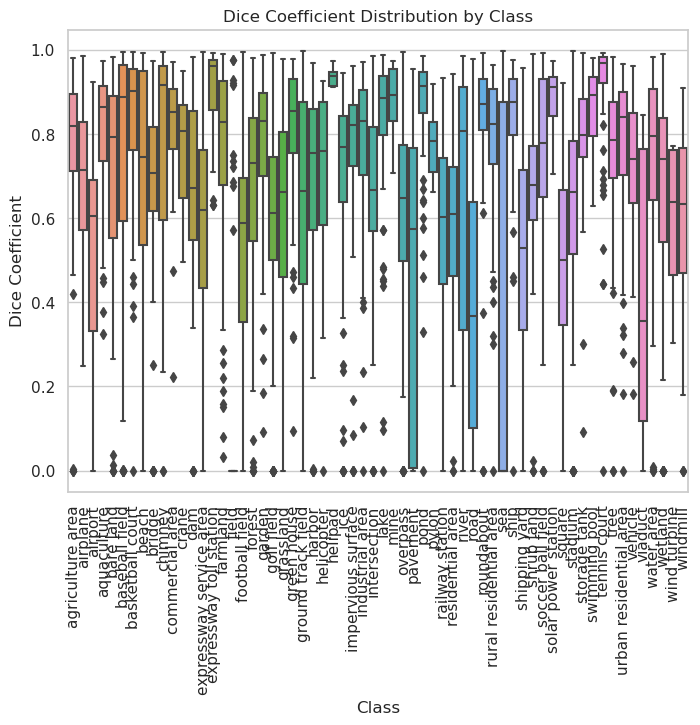

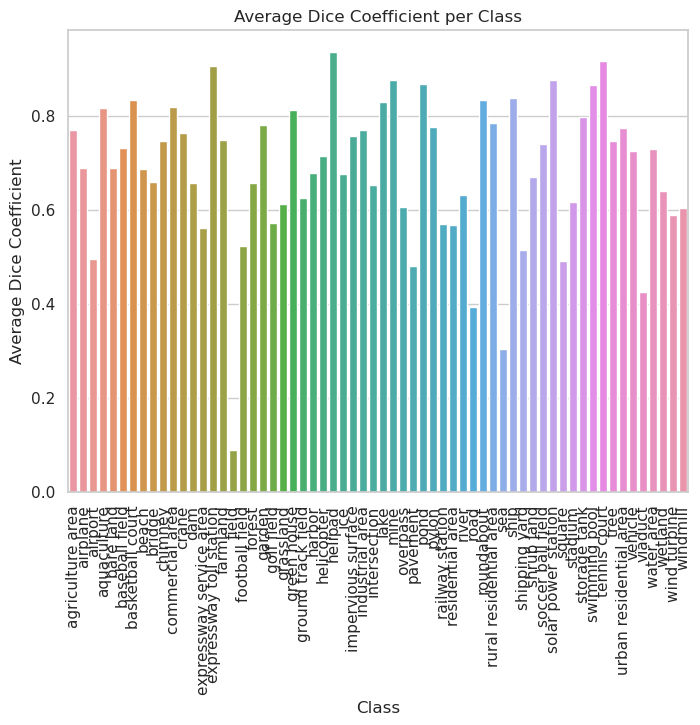

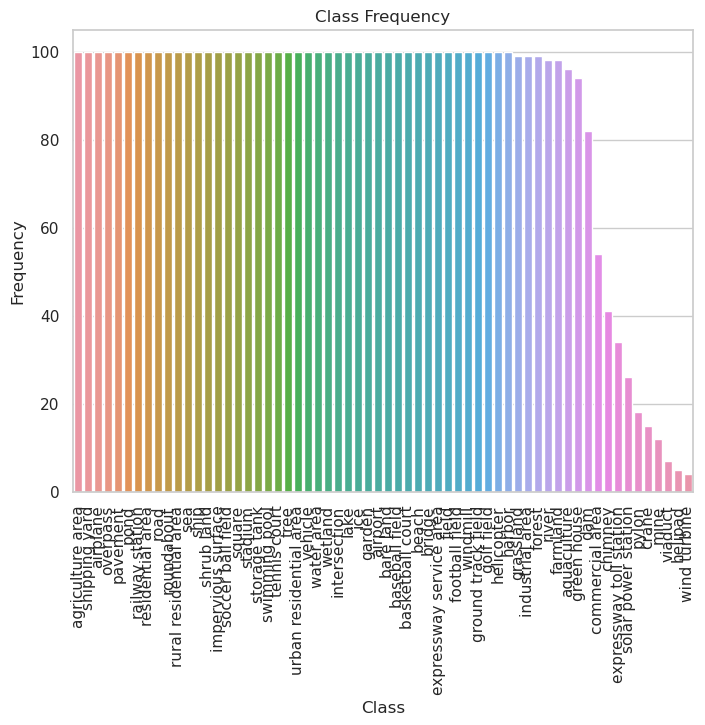

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Example DataFrame
# data = {
#     "image_path": ["image1.jpg", "image1.jpg", "image2.jpg", "image2.jpg", "image3.jpg"],
#     "class": ["cat", "dog", "cat", "bird", "dog"],
#     "roi": ["100,200,300,400", "150,250,350,450", "200,300,400,500", "250,350,450,550", "300,400,500,600"],
#     "dice": [0.85, 0.90, 0.78, 0.88, 0.92],
#     "path": ["path1", "path1", "path2", "path2", "path3"]
# }

# df = pd.DataFrame(data)

# Set the style for Seaborn
sns.set(style="whitegrid")

# 1. Dice Coefficient Distribution by Class
plt.figure(figsize=(8, 6))
sns.boxplot(x="class", y="dice", data=df)
plt.title("Dice Coefficient Distribution by Class")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Dice Coefficient")
plt.show()

# 2. Average Dice Coefficient per Class
avg_dice_per_class = df.groupby("class")["dice"].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x="class", y="dice", data=avg_dice_per_class)
plt.title("Average Dice Coefficient per Class")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Average Dice Coefficient")
plt.show()

# # 3. Dice Coefficient per Image
# plt.figure(figsize=(10, 6))
# sns.barplot(x="image_path", y="dice", hue="class", data=df)
# plt.title("Dice Coefficient per Image")
# plt.xlabel("Image Path")
# plt.xticks(rotation=90)
# plt.ylabel("Dice Coefficient")
# plt.legend(title="Class")
# plt.show()

# 4. Class Frequency
class_freq = df["class"].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_freq.index, y=class_freq.values)
plt.title("Class Frequency")

plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()

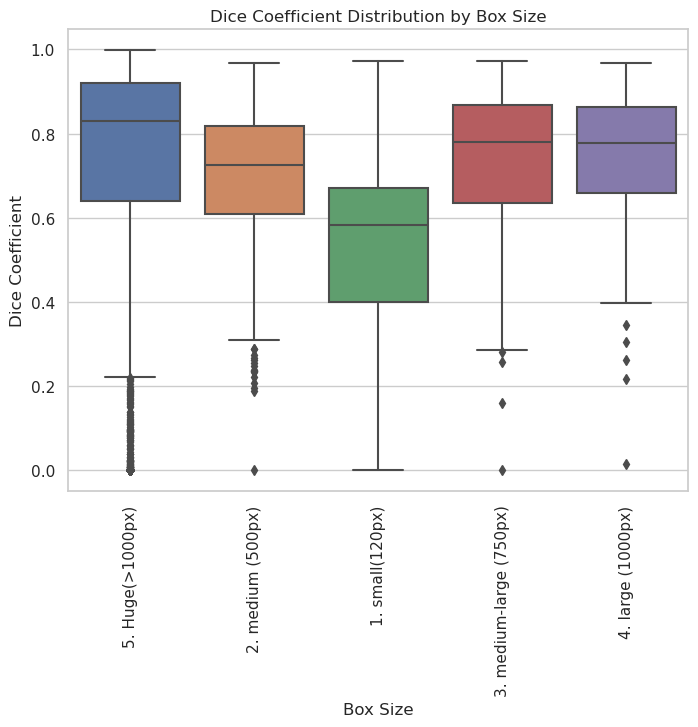

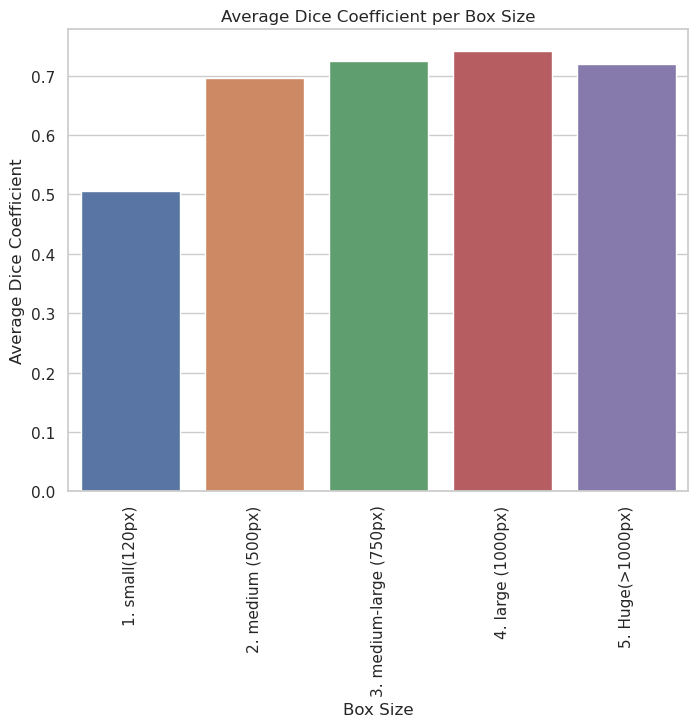

             dice        width       height      box_area
count  100.000000   100.000000   100.000000  1.000000e+02
mean     0.770451   268.120000   262.785000  1.361933e+05
std      0.201933   285.095634   273.408427  2.481396e+05
min      0.000000     1.000000     3.000000  1.100000e+01
25%      0.711663    48.125000    63.500000  3.704750e+03
50%      0.818493   140.000000   162.750000  2.146850e+04
75%      0.895102   405.625000   362.625000  1.210595e+05
max      0.979013  1023.500000  1023.500000  1.047552e+06


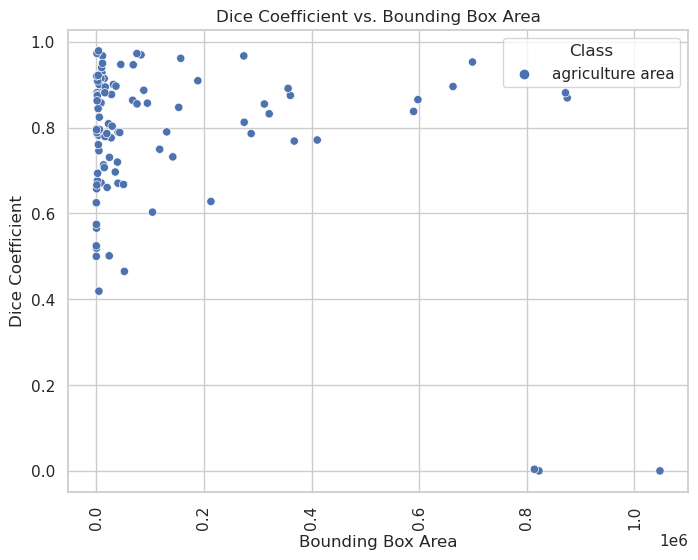

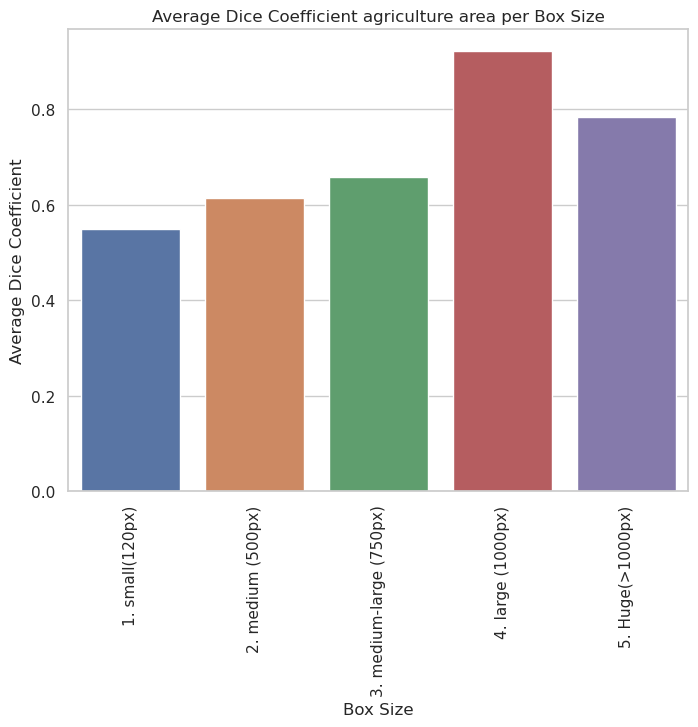

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.689238   63.115000   64.235000    9350.417500
std      0.168120   77.047763   71.644586   31460.556282
min      0.248797    2.500000    2.500000       7.500000
25%      0.572396   19.750000   18.750000     385.250000
50%      0.714802   42.500000   51.000000    2290.500000
75%      0.827878   72.750000   79.250000    5721.250000
max      0.983834  538.000000  487.000000  262006.000000


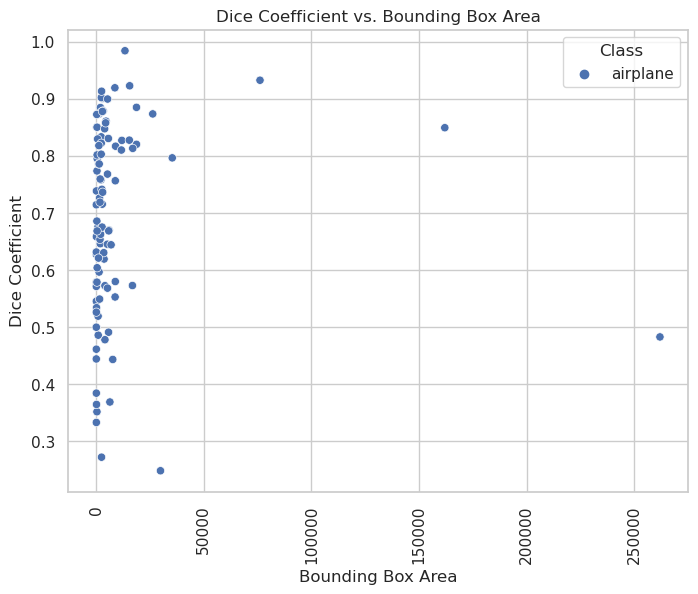

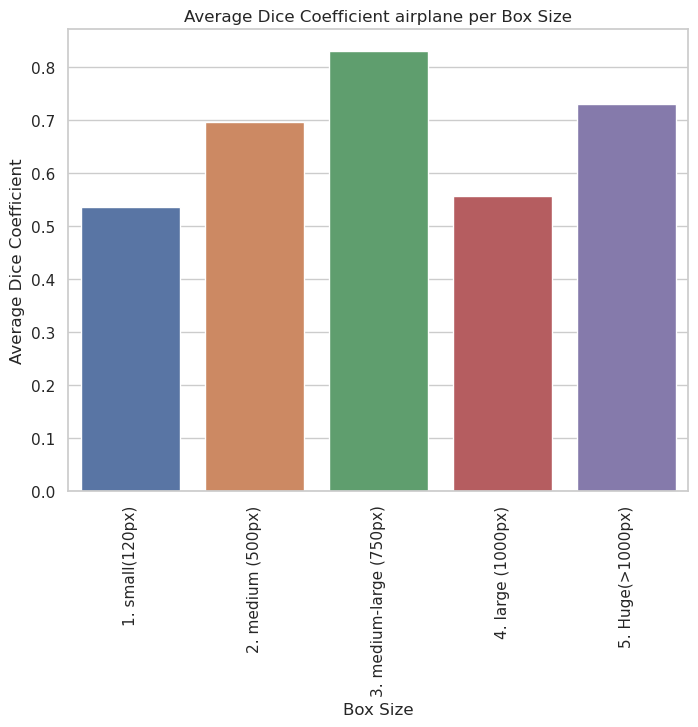

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.495949   64.575000   45.480000   14463.570000
std      0.273535  189.162513  125.575964   47843.895678
min      0.000000    1.500000    2.000000       3.000000
25%      0.331522    3.000000    3.000000       7.375000
50%      0.606025    4.500000    5.000000      24.000000
75%      0.689969   10.000000   10.000000      90.875000
max      0.924352  886.000000  772.000000  263978.000000


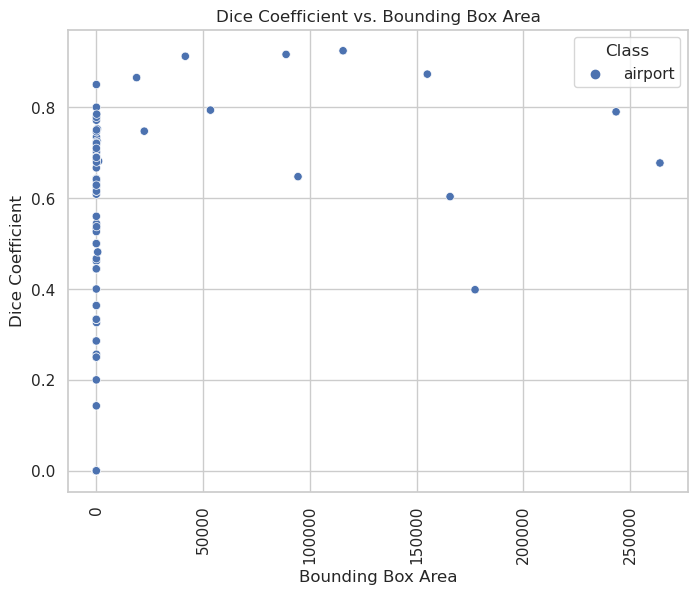

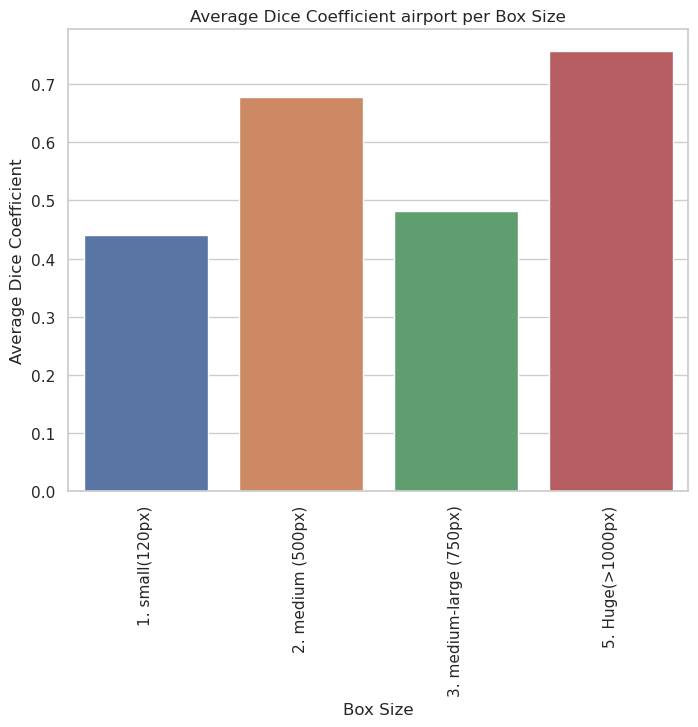

            dice        width      height       box_area
count  96.000000    96.000000   96.000000      96.000000
mean    0.815850   215.085844  216.284622   77396.413329
std     0.140759   214.054228  196.067888  154408.783563
min     0.324175    27.026511   27.026511     818.892981
25%     0.734612    82.686736   81.056216    7635.857778
50%     0.864743   140.253109  152.819237   20954.372056
75%     0.914315   247.872750  283.957711   60977.781793
max     0.973802  1024.740131  979.705869  939545.164357


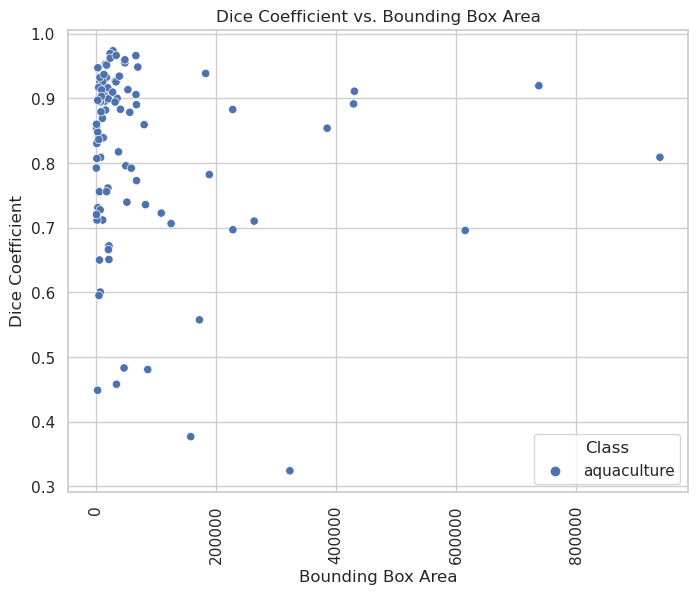

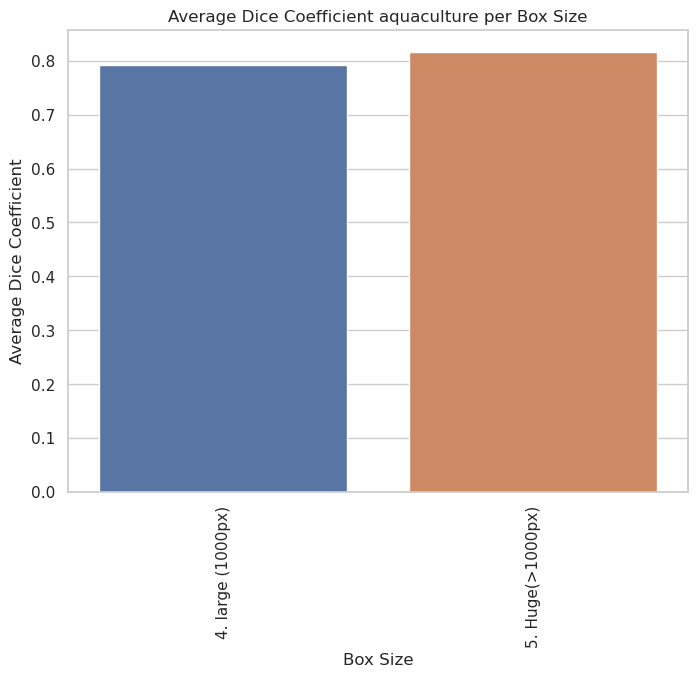

            dice       width      height       box_area
count  99.000000  100.000000  100.000000     100.000000
mean    0.689389  154.829477  145.649123   40722.463093
std     0.262089  158.515412  151.799741   73230.769230
min     0.000000    2.500000    1.500000       5.000000
25%     0.552142   36.000000   31.375000    1224.375000
50%     0.791774  112.250000   89.000000   11687.898977
75%     0.889901  194.726402  220.000000   34211.956077
max     0.982632  640.000000  706.195578  276480.000000


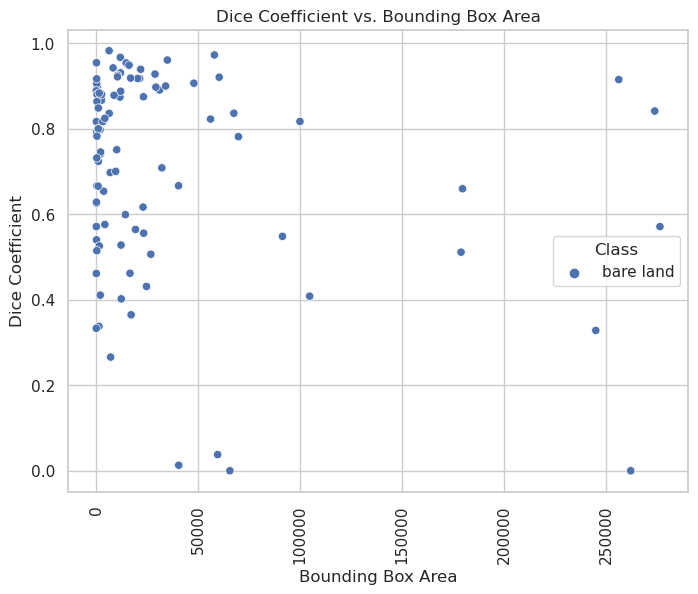

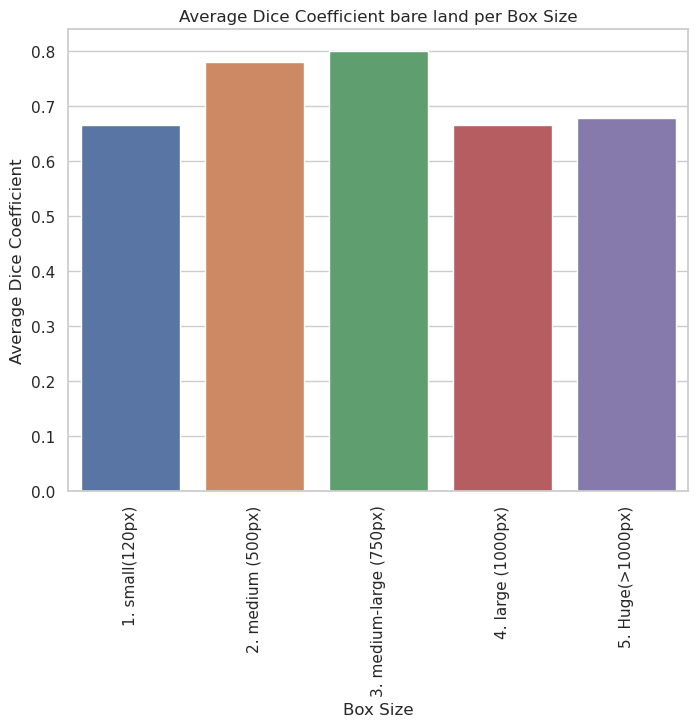

             dice      width     height       box_area
count  100.000000  100.00000  100.00000     100.000000
mean     0.731344   91.83500   87.56000   14546.025000
std      0.307987   84.88739   81.02641   22190.217925
min      0.000000    1.50000    2.00000       3.000000
25%      0.592291    6.87500   15.50000      73.000000
50%      0.888536   63.00000   60.50000    3515.000000
75%      0.963694  153.25000  142.75000   21201.000000
max      0.994320  363.00000  382.00000  138666.000000


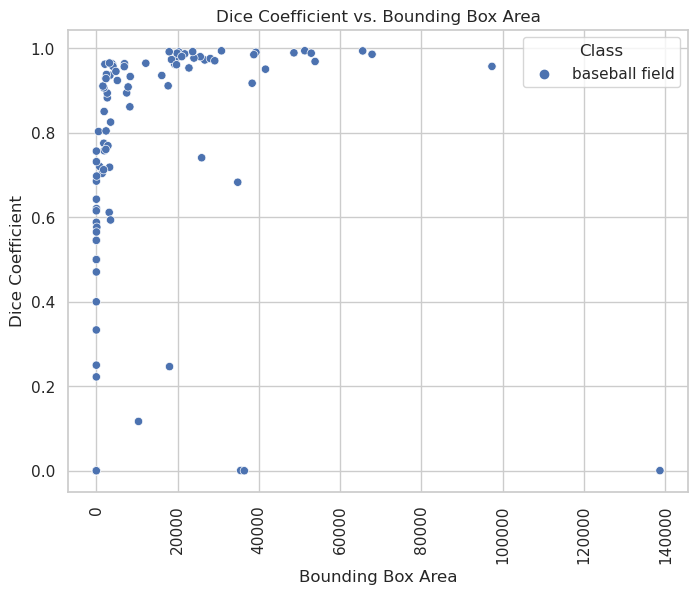

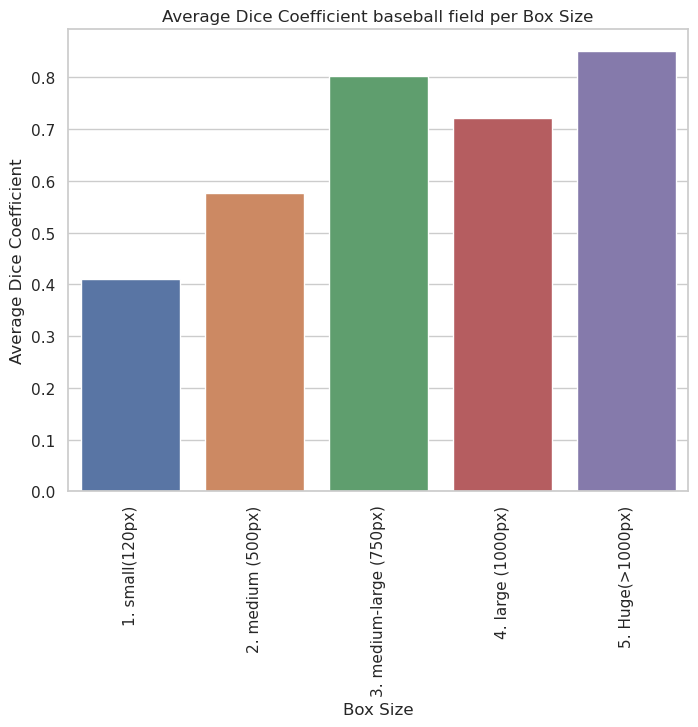

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.834437   92.465000  107.085000  14423.060000
std      0.174394   70.692543   79.436623  16912.298062
min      0.000000    2.000000    2.000000      7.000000
25%      0.762649   33.750000   37.750000   1657.500000
50%      0.902884   75.500000  102.000000   7120.500000
75%      0.954641  134.000000  168.250000  24130.250000
max      0.994144  277.000000  343.000000  63440.000000


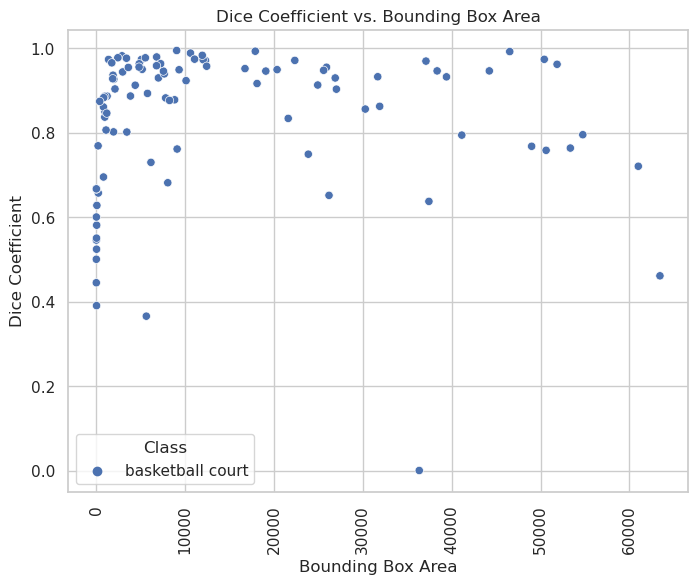

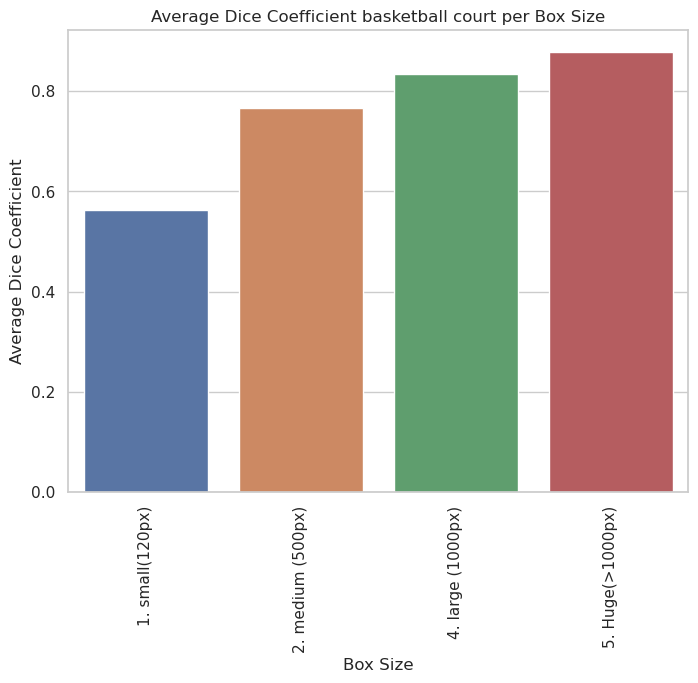

            dice       width      height      box_area
count  97.000000  100.000000  100.000000    100.000000
mean    0.687521   90.650000   91.955000  12023.705000
std     0.293982   76.916375   74.110009  16394.945863
min     0.000000    6.500000    4.000000     34.000000
25%     0.536975   36.375000   36.750000   1299.000000
50%     0.744186   58.000000   62.500000   3606.500000
75%     0.948410  135.625000  127.000000  15167.625000
max     0.992814  256.000000  256.000000  65536.000000


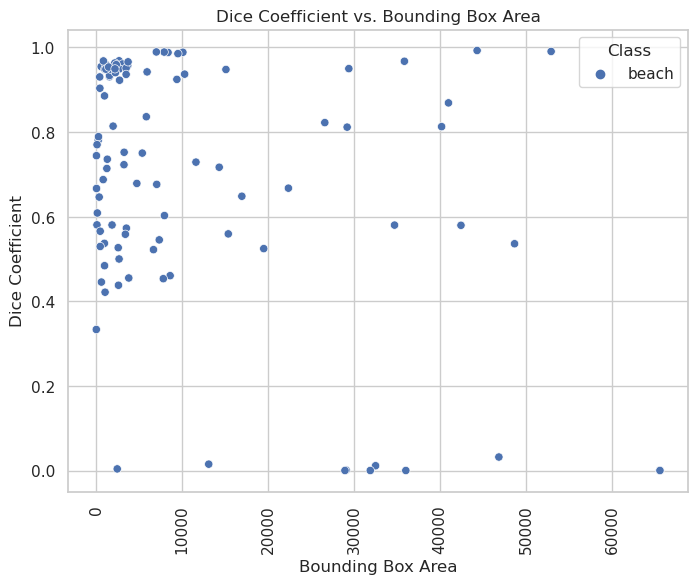

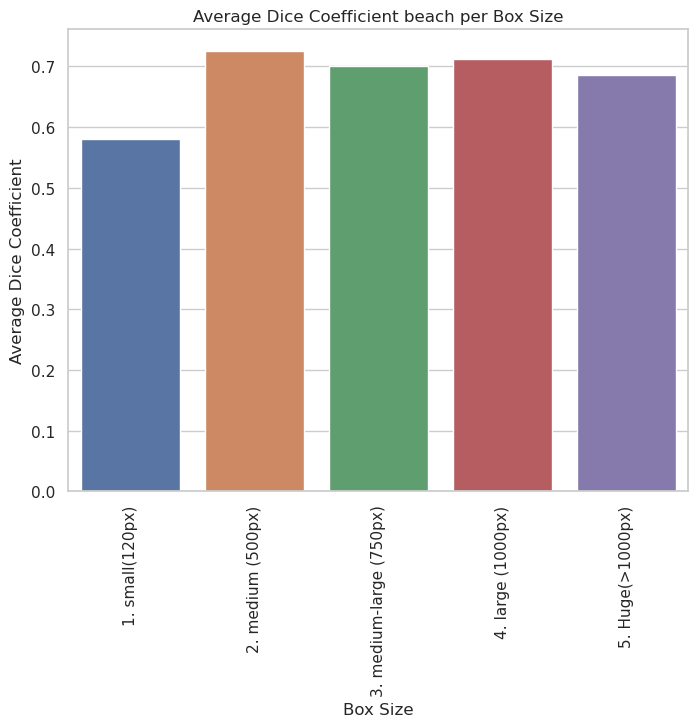

             dice        width       height       box_area
count  100.000000   100.000000   100.000000     100.000000
mean     0.659582    61.621513    62.856735   25347.141333
std      0.233331   171.985379   153.685809  120841.767525
min      0.000000     1.500000     1.500000       3.000000
25%      0.615577     6.000000     6.000000      35.437500
50%      0.706214    22.000000    17.000000     334.500000
75%      0.815699    46.500000    41.000000    1769.500000
max      0.972973  1239.000000  1063.000000  826950.400254


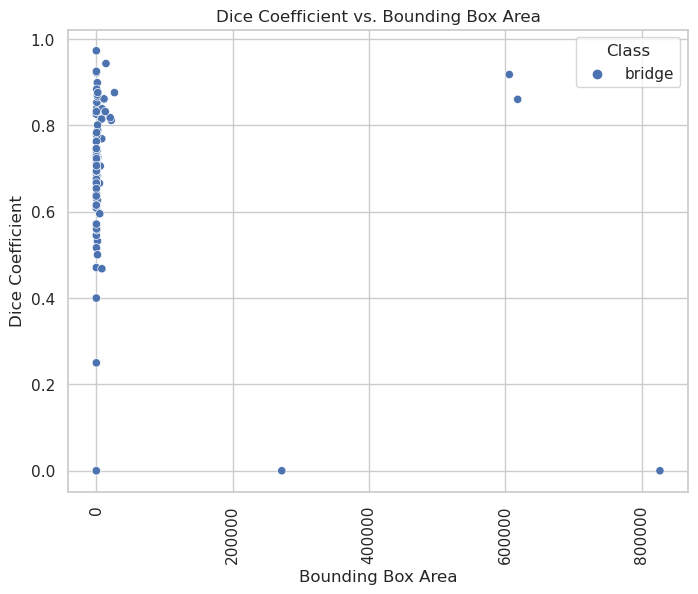

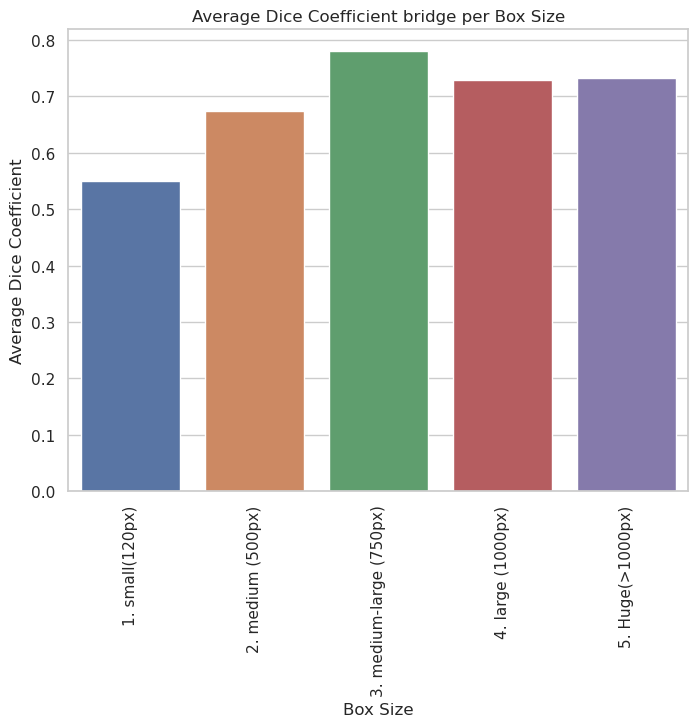

            dice       width      height       box_area
count  41.000000   41.000000   41.000000      41.000000
mean    0.745220  155.362462  157.682755   36271.690956
std     0.286786  115.253242  107.986163   34282.749513
min     0.000000    1.500000    2.000000       3.000000
25%     0.596491   10.000000   22.000000     210.000000
50%     0.914986  190.500000  187.000000   33948.000000
75%     0.962276  224.000000  238.000000   54978.000000
max     0.994483  372.000000  379.000000  140988.000000


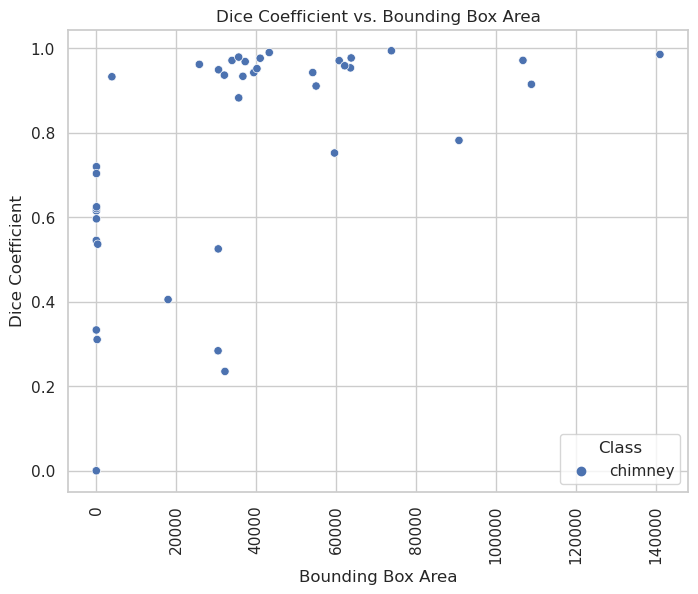

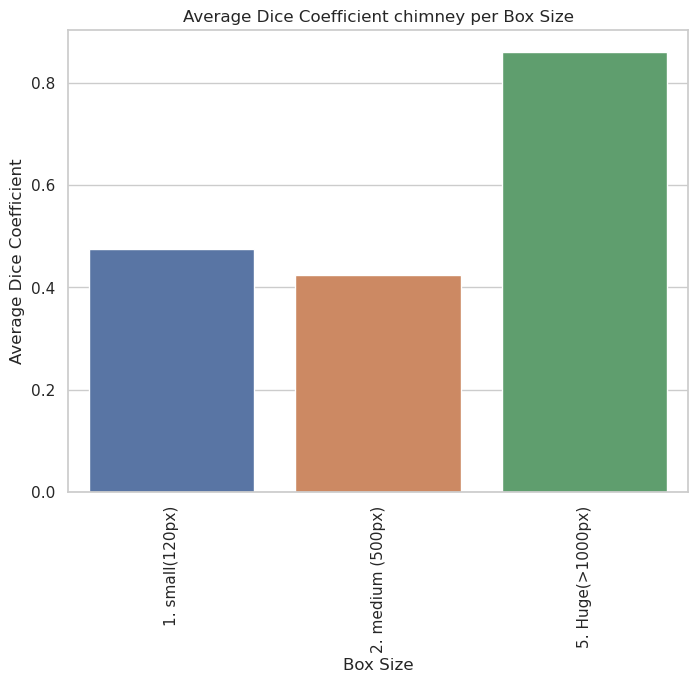

            dice       width      height       box_area
count  54.000000   54.000000   54.000000      54.000000
mean    0.819132  240.049693  248.739568   69273.792749
std     0.134734  121.967633  134.797569   66660.154523
min     0.222056   51.404338   81.790594    5505.012418
25%     0.764885  156.292728  136.506948   22595.017635
50%     0.851230  227.092805  226.931185   46418.524039
75%     0.907636  296.220966  338.437765   94899.785433
max     0.971307  630.991459  654.825422  323385.889111


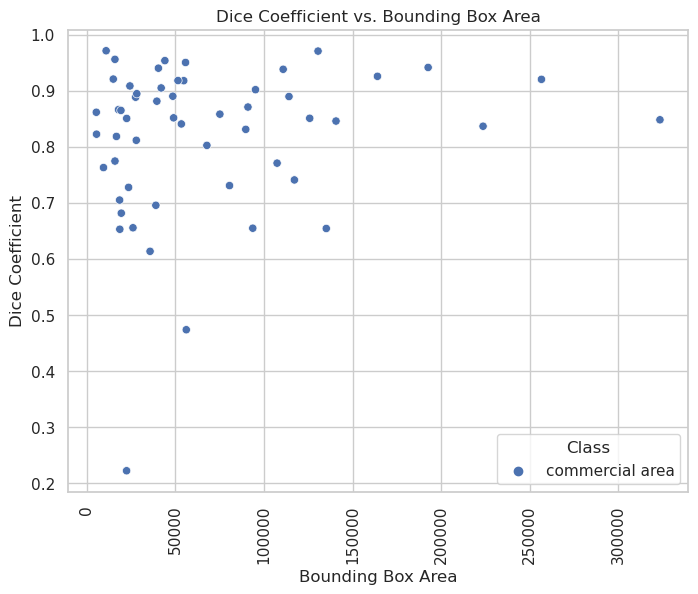

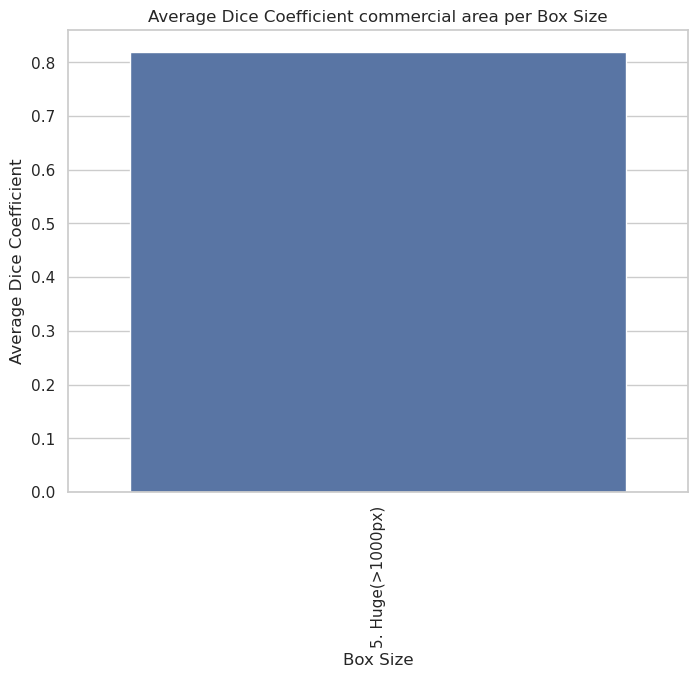

            dice     width      height     box_area
count  15.000000  15.00000   15.000000    15.000000
mean    0.763612  45.40000   40.000000  2486.866667
std     0.141152  29.62335   39.084158  2865.384613
min     0.496063   5.00000    8.000000    40.000000
25%     0.647114  21.00000   14.000000   304.500000
50%     0.805941  38.00000   26.000000   988.000000
75%     0.869311  74.50000   56.000000  4812.000000
max     0.949899  88.00000  160.000000  9440.000000


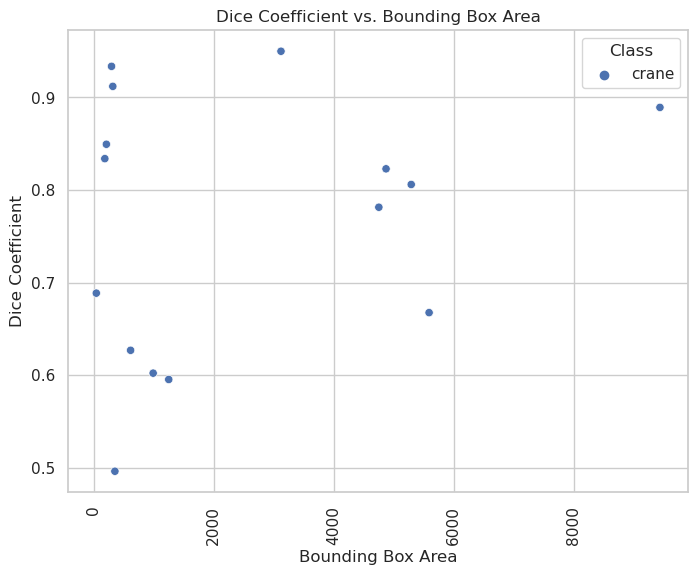

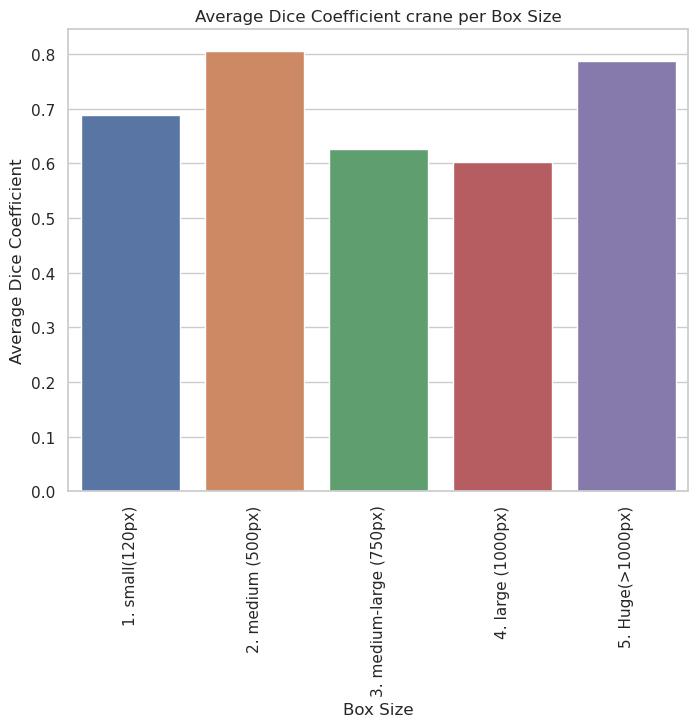

            dice       width      height       box_area
count  82.000000   82.000000   82.000000      82.000000
mean    0.656343   96.954255  100.041239   18799.621301
std     0.247204  111.977494  126.190985   28095.234438
min     0.000000    1.500000    2.000000       3.000000
25%     0.547303    4.000000    4.000000      18.000000
50%     0.670240   65.958339   47.233276    3027.500000
75%     0.853404  159.750000  158.244648   29214.662141
max     0.982339  522.000000  613.000000  131528.000000


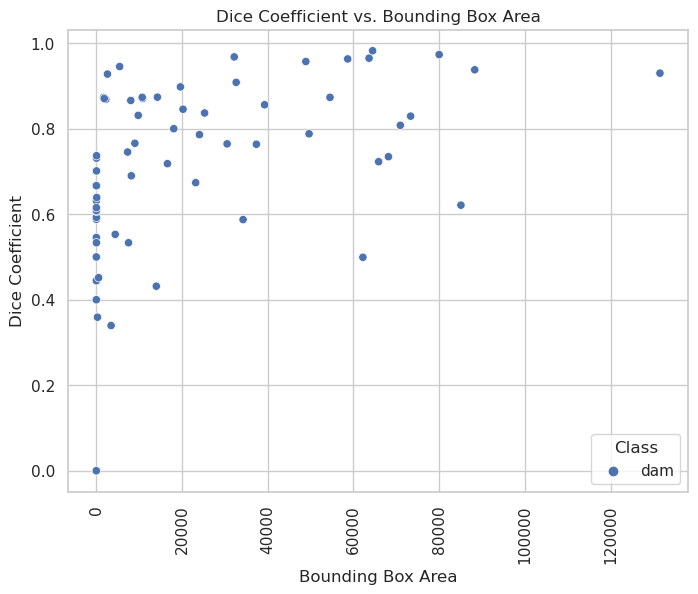

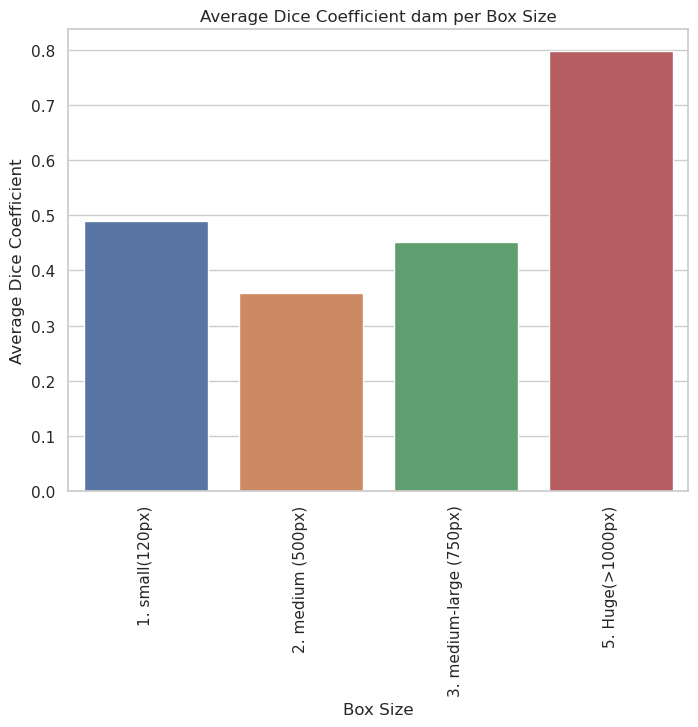

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.560374   75.130000   92.380000   30564.460000
std      0.292494  146.032282  184.370772   77414.637515
min      0.000000    1.500000    2.000000       3.000000
25%      0.433333    2.875000    3.000000       7.500000
50%      0.620192    6.000000    6.000000      38.000000
75%      0.762504   38.000000   26.250000    1268.250000
max      0.995560  712.000000  776.000000  552512.000000


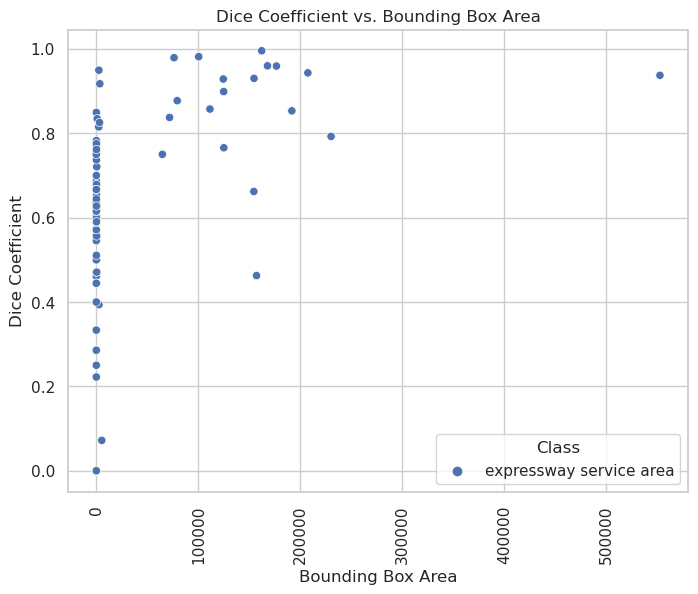

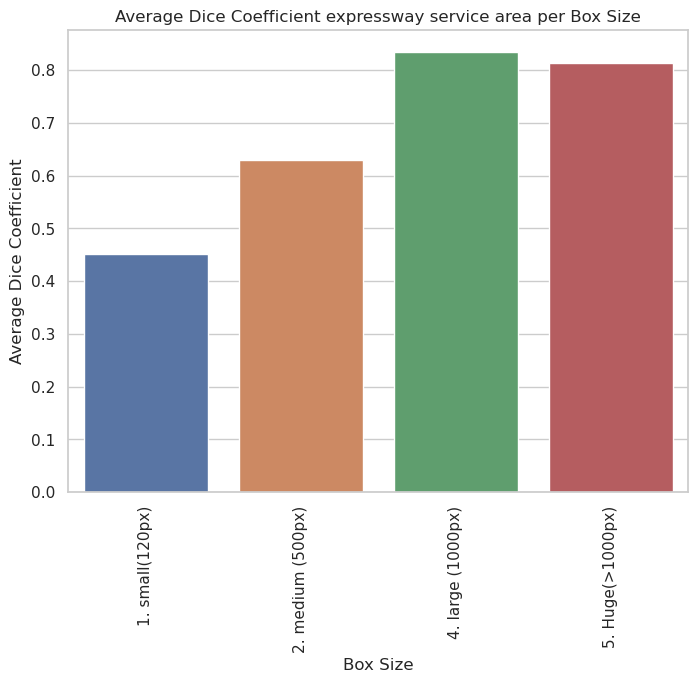

            dice       width      height       box_area
count  34.000000   34.000000   34.000000      34.000000
mean    0.906647  101.897059  101.250000   16550.720588
std     0.107326  109.525131   76.759389   32972.866107
min     0.630710    4.500000    3.000000      13.500000
25%     0.856848   33.000000   44.000000    1620.000000
50%     0.962337   80.500000   97.000000    8178.500000
75%     0.975195  126.000000  136.000000   13768.500000
max     0.991663  624.000000  338.000000  176904.000000


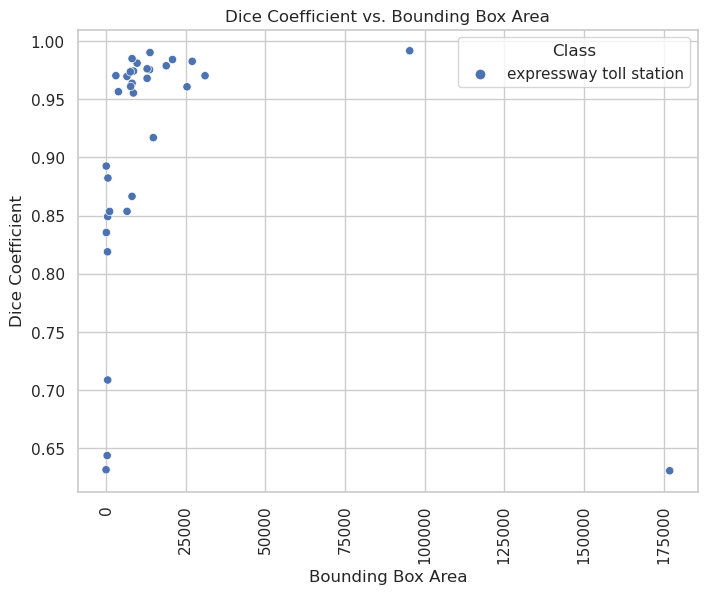

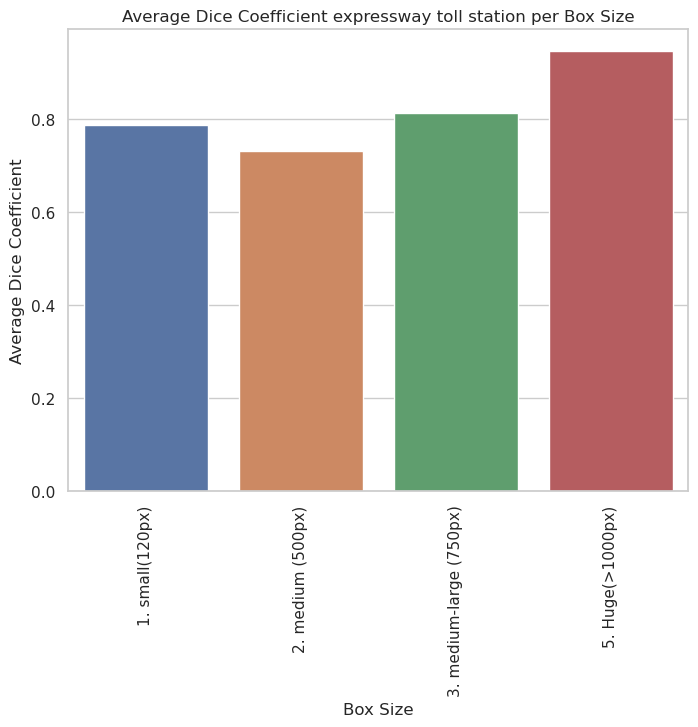

            dice        width       height      box_area
count  98.000000    98.000000    98.000000  9.800000e+01
mean    0.748412   248.177008   233.075488  1.239529e+05
std     0.235332   311.486254   255.307017  3.359604e+05
min     0.031570     2.500000     1.500000  5.000000e+00
25%     0.677319    63.500000    62.500000  4.408500e+03
50%     0.827174   161.250000   135.500000  2.061900e+04
75%     0.925148   289.500000   298.250000  8.509250e+04
max     0.989837  1889.000000  1385.000000  2.616265e+06


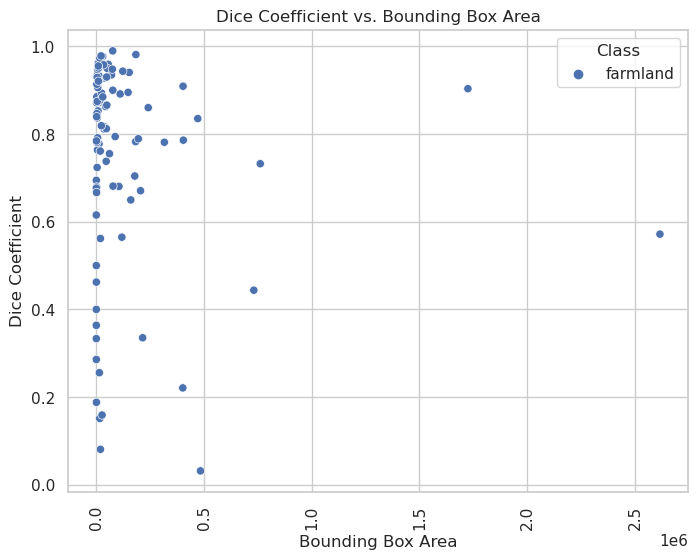

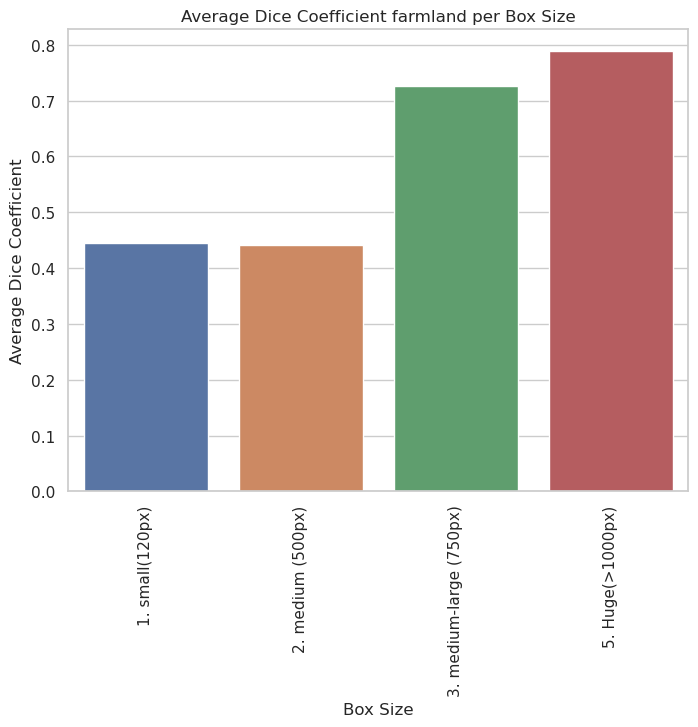

            dice       width      height      box_area
count  99.000000  100.000000  100.000000    100.000000
mean    0.089485  238.420000  238.755000  59244.352500
std     0.258371   52.418129   51.057133  17399.398572
min     0.000000   19.000000   46.000000    874.000000
25%     0.000000  256.000000  256.000000  65536.000000
50%     0.000000  256.000000  256.000000  65536.000000
75%     0.000000  256.000000  256.000000  65536.000000
max     0.976310  256.000000  256.000000  65536.000000


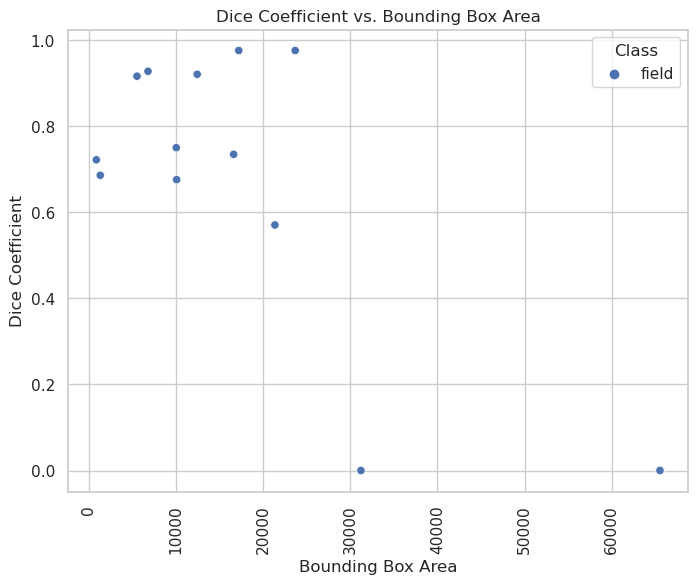

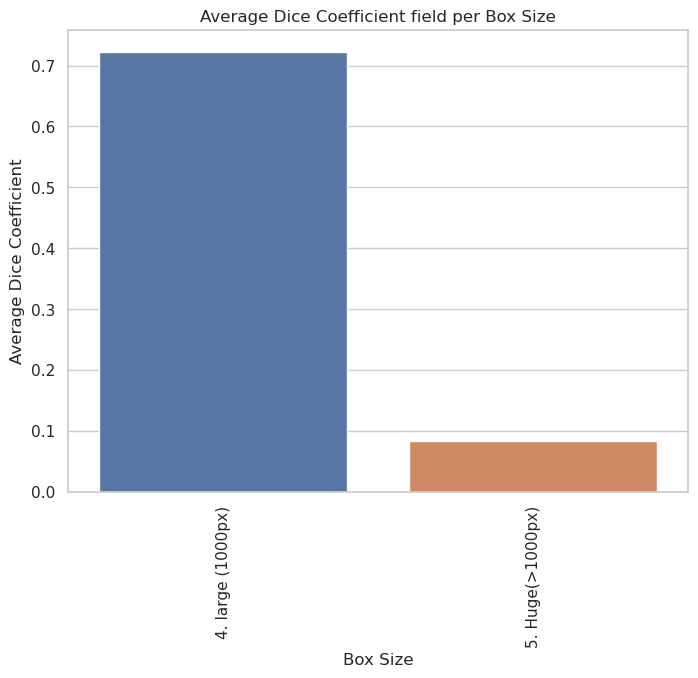

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.521943   29.575394   33.474596   4990.194560
std      0.312466   61.042889   70.065862  14941.072216
min      0.000000    1.500000    2.000000      3.000000
25%      0.352544    2.375000    3.000000      7.000000
50%      0.588235    4.250000    4.000000     16.000000
75%      0.694387    8.000000   11.250000     82.000000
max      0.994536  320.000000  365.000000  81030.000000


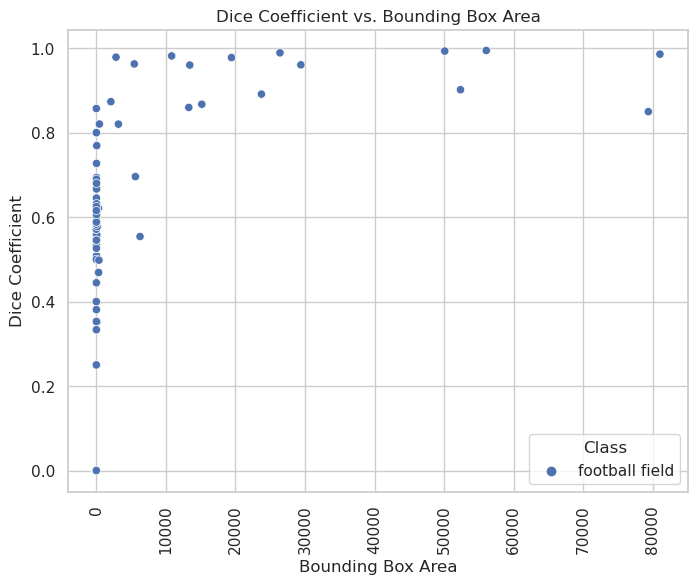

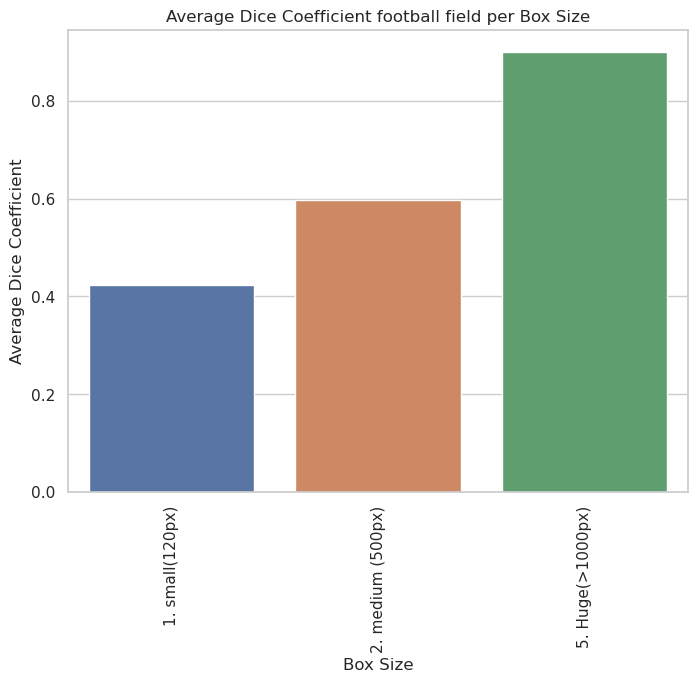

            dice       width       height       box_area
count  99.000000   99.000000    99.000000      99.000000
mean    0.657171  195.320716   175.251493   60635.925401
std     0.256351  190.636382   186.482298  125226.120930
min     0.000000    1.500000     2.000000       3.000000
25%     0.544404   35.750000    40.500000    1512.750000
50%     0.730251  149.000000   121.000000   17589.000000
75%     0.837983  290.500000   248.250000   63970.500000
max     0.979386  833.000000  1024.000000  852992.000000


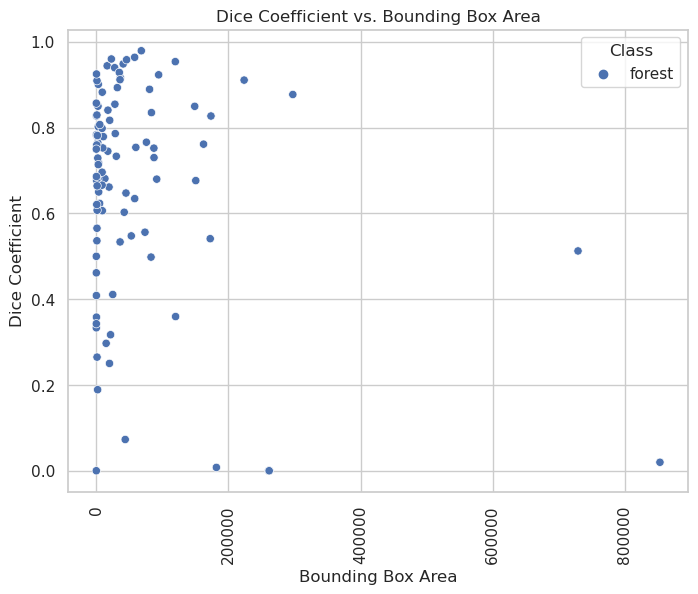

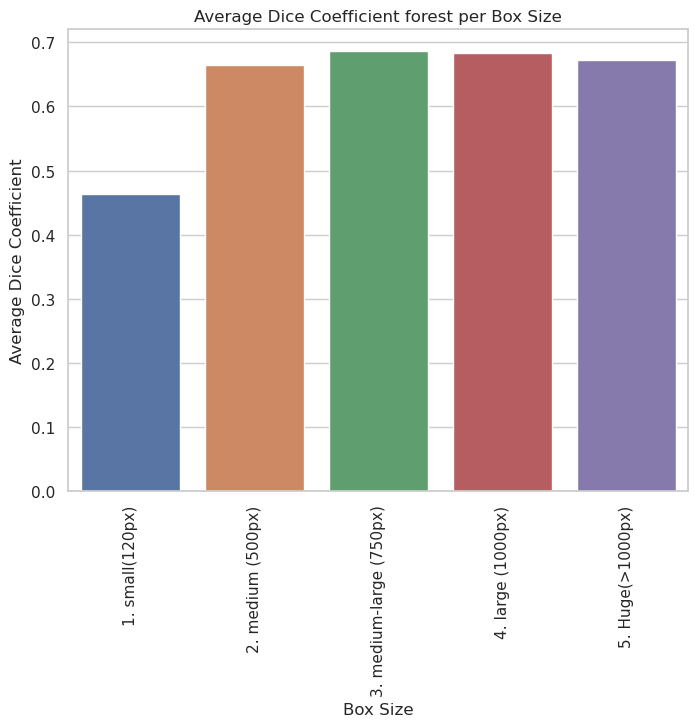

             dice       width       height       box_area
count  100.000000  100.000000   100.000000     100.000000
mean     0.779132  214.735000   230.080000   73199.097500
std      0.165236  163.782352   182.437864  136210.067073
min      0.092697   14.500000     3.000000      82.500000
25%      0.700140  101.000000   109.250000   11397.000000
50%      0.831420  153.500000   180.000000   34909.000000
75%      0.896232  294.750000   282.750000   72230.875000
max      0.986772  929.000000  1057.000000  894627.000000


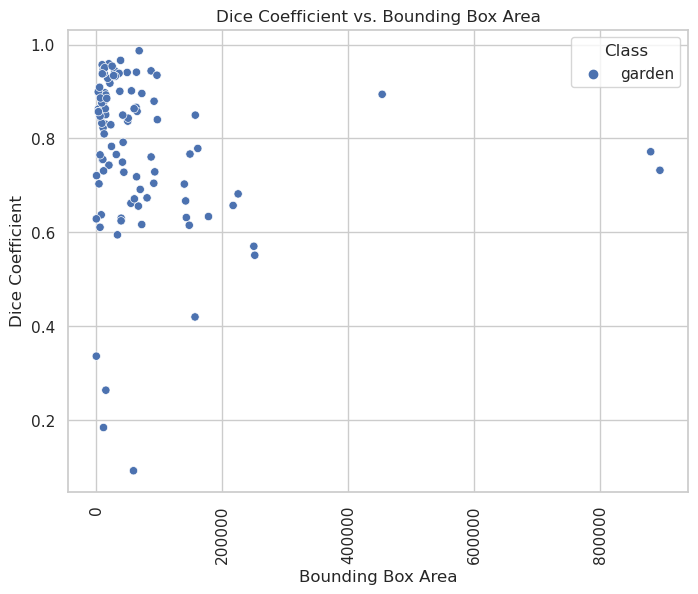

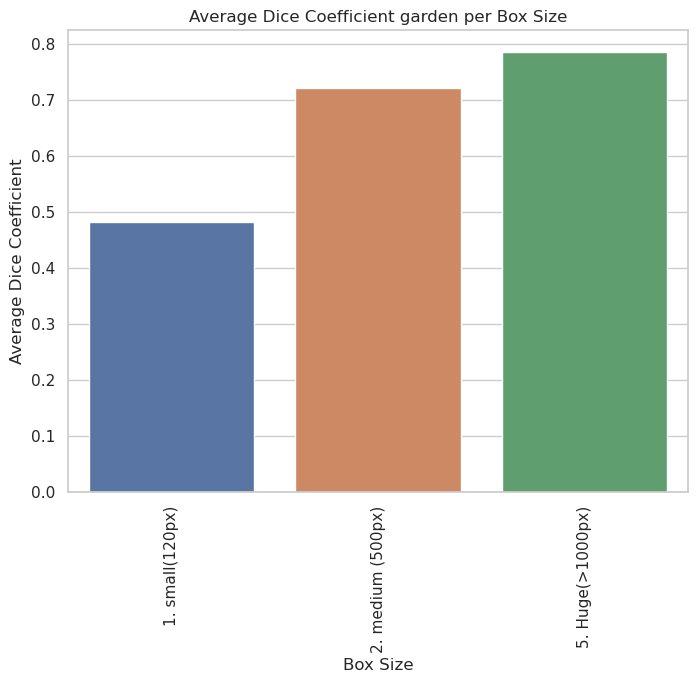

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.570717   49.640000   50.015000   18494.552500
std      0.255818  132.737477  129.211487   65931.609301
min      0.000000    1.500000    2.000000       3.000000
25%      0.500000    2.500000    3.000000       8.000000
50%      0.611096    5.000000    5.000000      20.000000
75%      0.743911   13.250000   12.000000     176.750000
max      0.991190  726.000000  597.000000  399300.000000


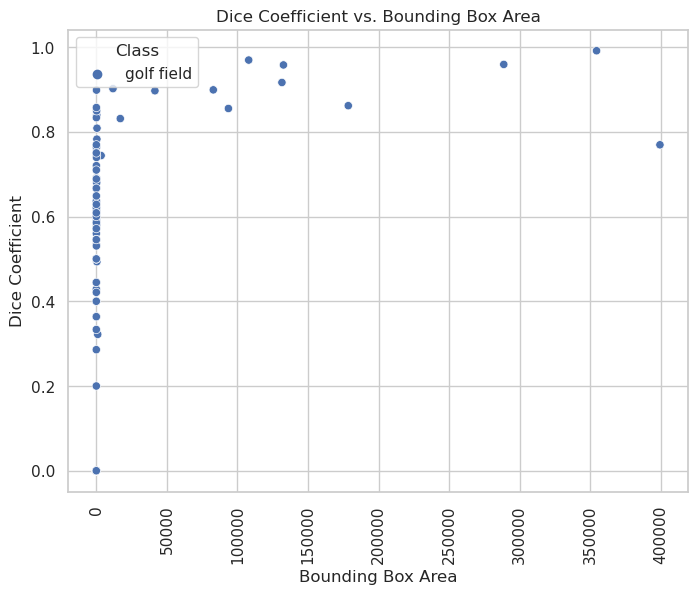

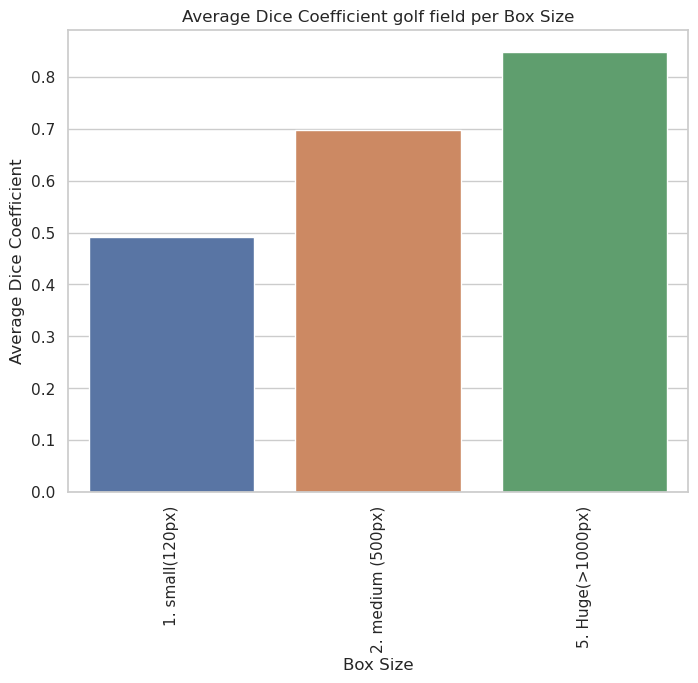

            dice       width       height       box_area
count  98.000000   99.000000    99.000000      99.000000
mean    0.611846  121.580808   128.141414   33050.207071
std     0.246483  142.868691   164.139423   83446.872466
min     0.000000    1.500000     2.000000       3.000000
25%     0.458860   15.000000    21.500000     390.000000
50%     0.662879   65.000000    66.000000    4537.500000
75%     0.803640  181.750000   177.250000   20328.000000
max     0.978204  647.500000  1026.000000  664335.000000


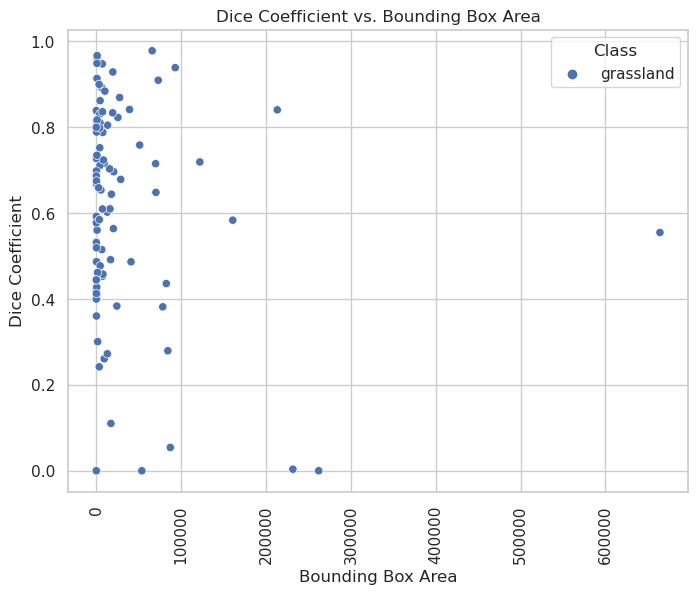

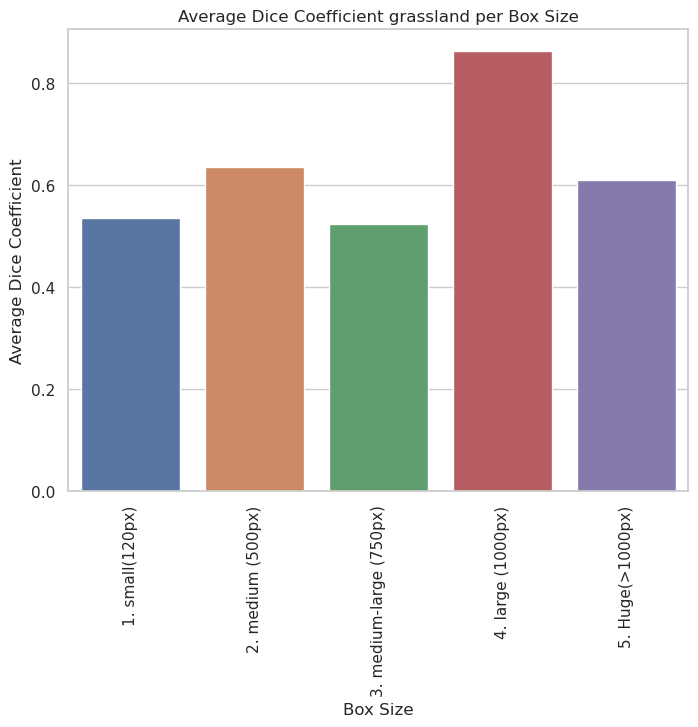

            dice       width      height       box_area
count  94.000000   94.000000   94.000000      94.000000
mean    0.811197  160.811542  163.581625   38174.849139
std     0.162509  134.241219  121.075082   61695.038405
min     0.093690   17.594715   33.191996    1027.222752
25%     0.754198   75.157853   76.119528    6225.748281
50%     0.855216  113.985195  121.177350   14194.390601
75%     0.929893  207.613403  211.534435   38899.322445
max     0.978444  710.644548  598.071816  384518.013015


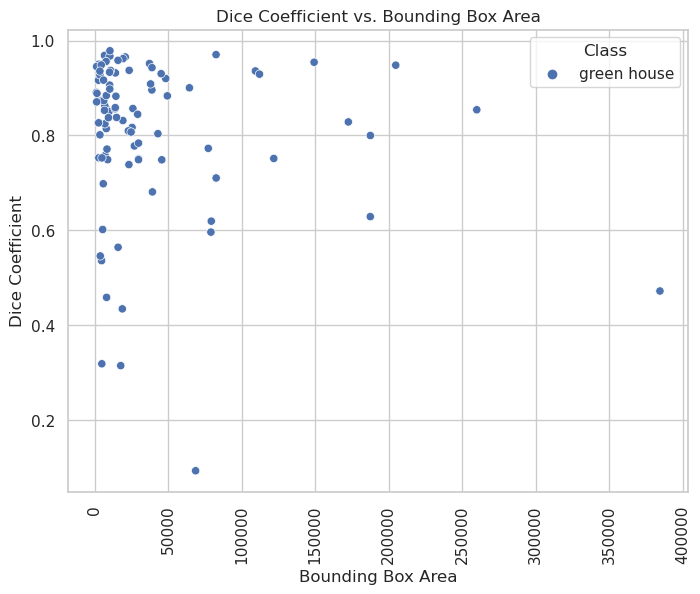

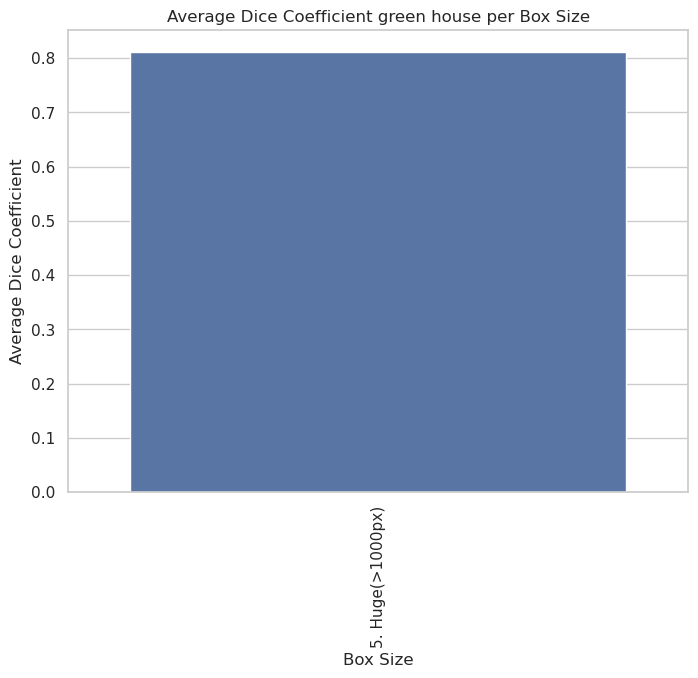

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.623789   89.120000  107.270000   29881.375000
std      0.272621  168.179845  174.752399   70731.355516
min      0.000000    1.500000    2.000000       3.000000
25%      0.444444    3.500000    3.000000      11.625000
50%      0.664280   17.000000   13.000000     154.250000
75%      0.875386  106.000000  157.500000   18528.750000
max      0.997341  943.000000  704.000000  399832.000000


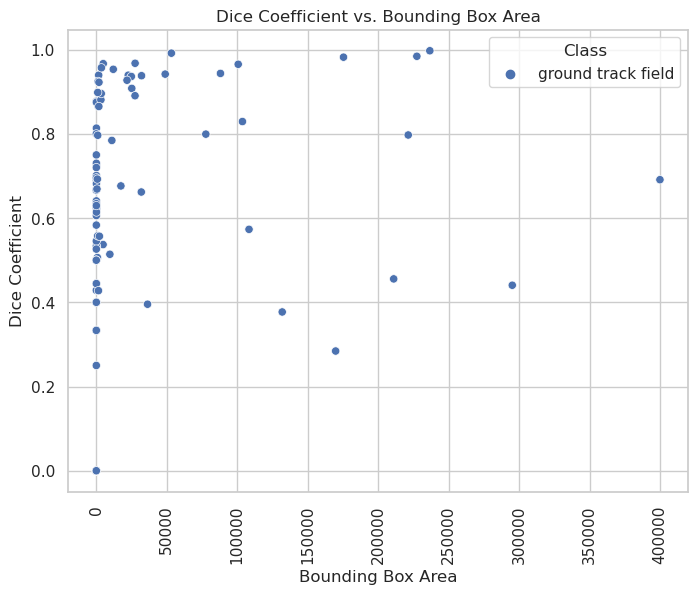

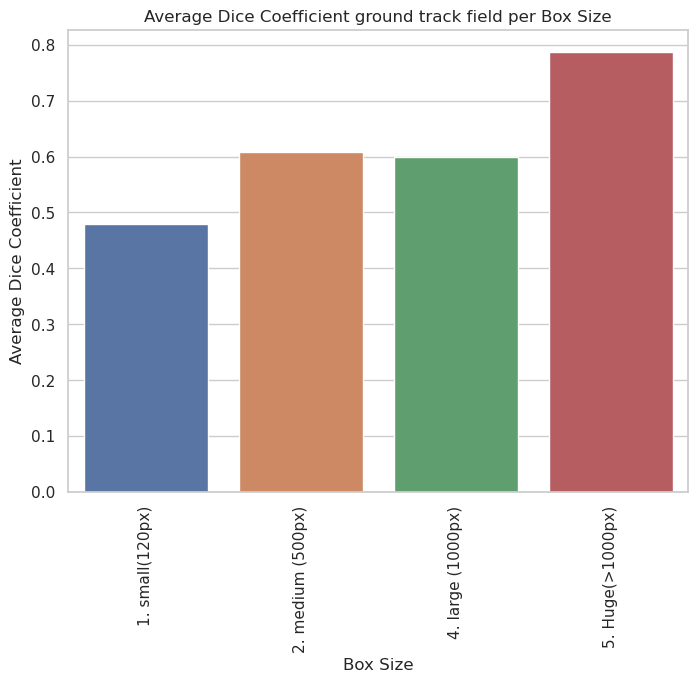

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.677676   82.635000  106.365000   13851.265000
std      0.240753   89.907299  117.868011   25410.548622
min      0.000000    1.500000    2.000000       3.000000
25%      0.572290   24.875000   26.000000     818.500000
50%      0.755071   45.000000   67.000000    3824.500000
75%      0.858814  107.000000  152.375000   15058.250000
max      0.967762  425.000000  634.000000  163461.000000


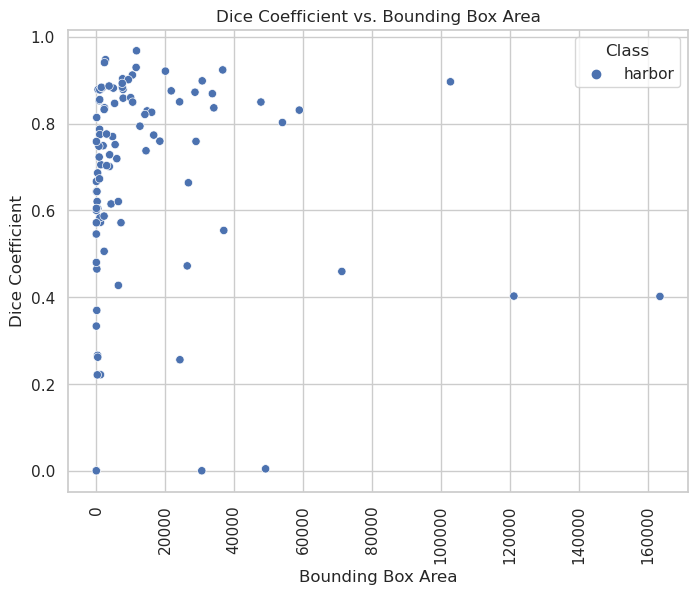

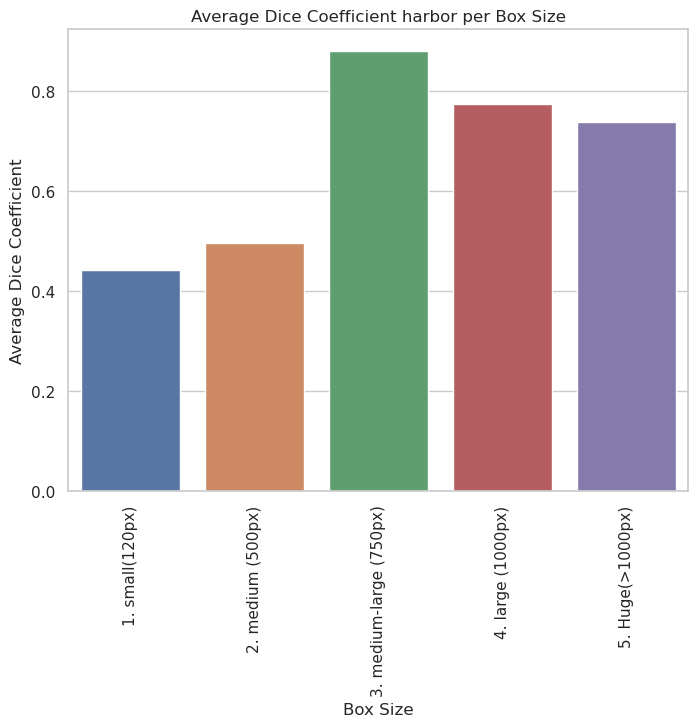

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.714114   40.845000   72.050000   4453.990000
std      0.191360   44.275292   44.488649   9635.046113
min      0.000000    1.500000    2.000000      3.000000
25%      0.584376   18.000000   36.000000   1089.000000
50%      0.759168   20.000000   75.000000   1462.000000
75%      0.876521   46.250000   80.250000   1894.500000
max      0.926445  271.000000  277.000000  75067.000000


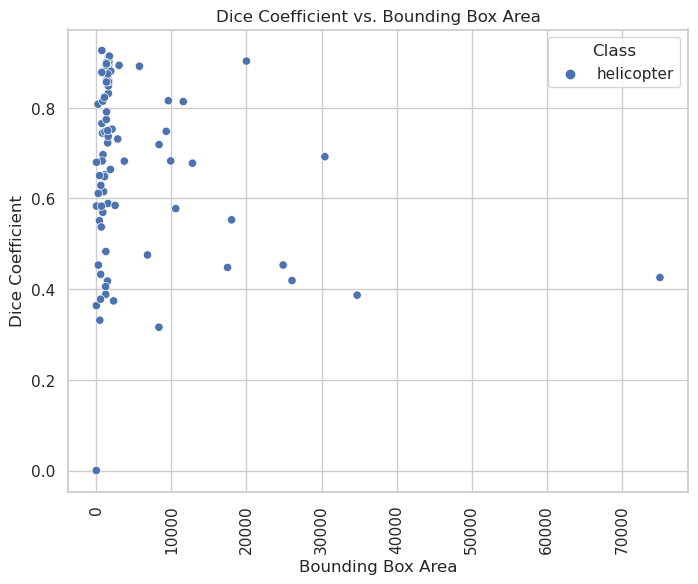

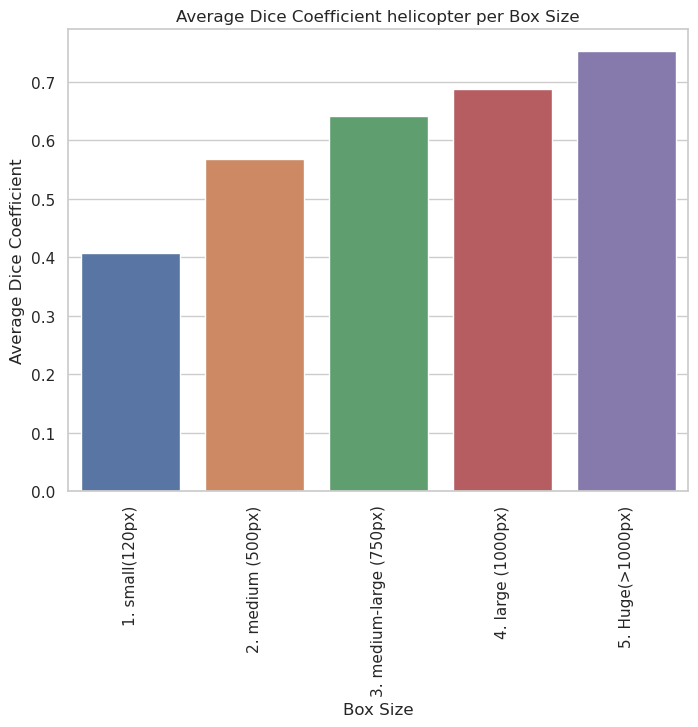

           dice     width     height    box_area
count  5.000000   5.00000   5.000000     5.00000
mean   0.936336  26.80000  28.000000   764.00000
std    0.025717   5.01996   4.743416   260.37281
min    0.911170  20.00000  23.000000   520.00000
25%    0.913089  26.00000  25.000000   598.00000
50%    0.936747  26.00000  26.000000   650.00000
75%    0.947702  28.00000  32.000000   896.00000
max    0.972973  34.00000  34.000000  1156.00000


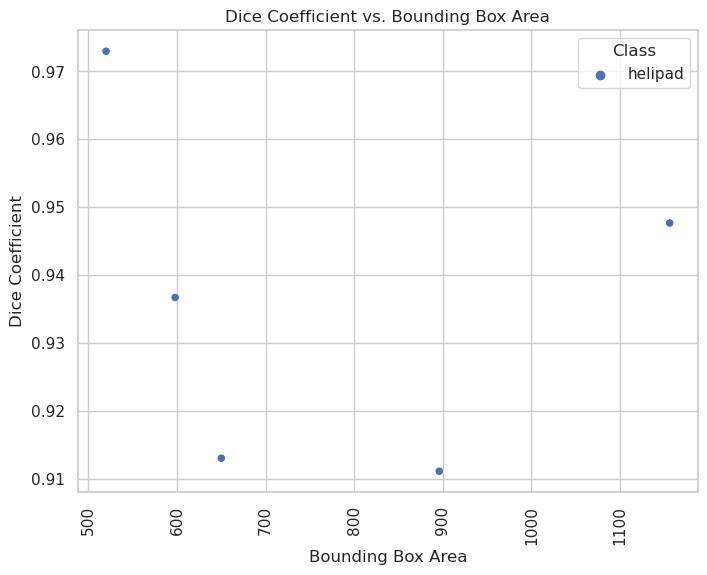

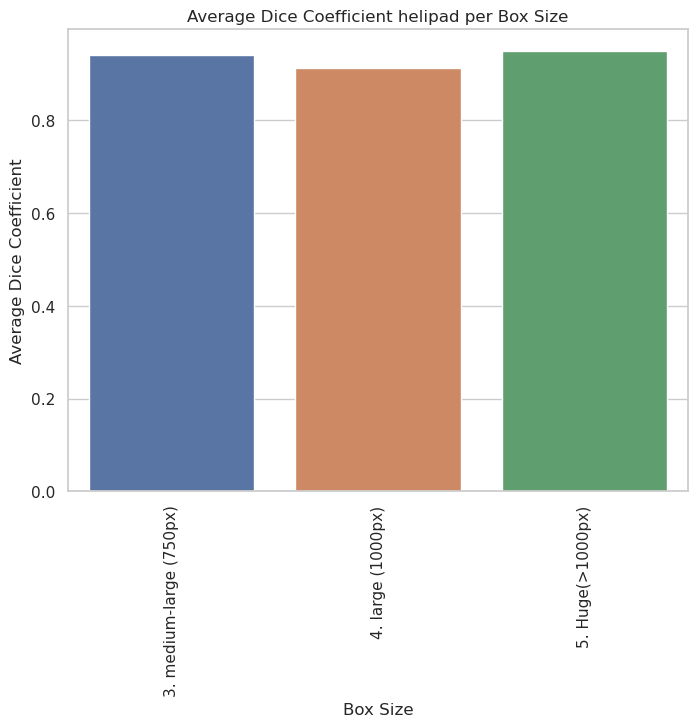

            dice       width     height       box_area
count  98.000000  100.000000  100.00000     100.000000
mean    0.676075  143.430000  123.47000   36376.485000
std     0.259079  147.185584  149.19946   71478.377187
min     0.000000    1.500000    2.50000       4.500000
25%     0.637434   43.375000   24.75000    1099.125000
50%     0.769054   82.000000   57.00000    4614.000000
75%     0.842532  177.500000  142.75000   28423.000000
max     0.943439  512.000000  512.00000  262144.000000


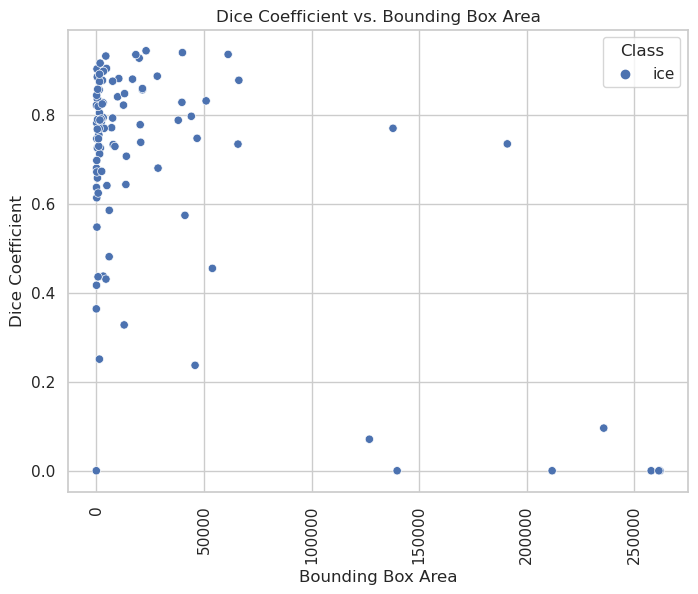

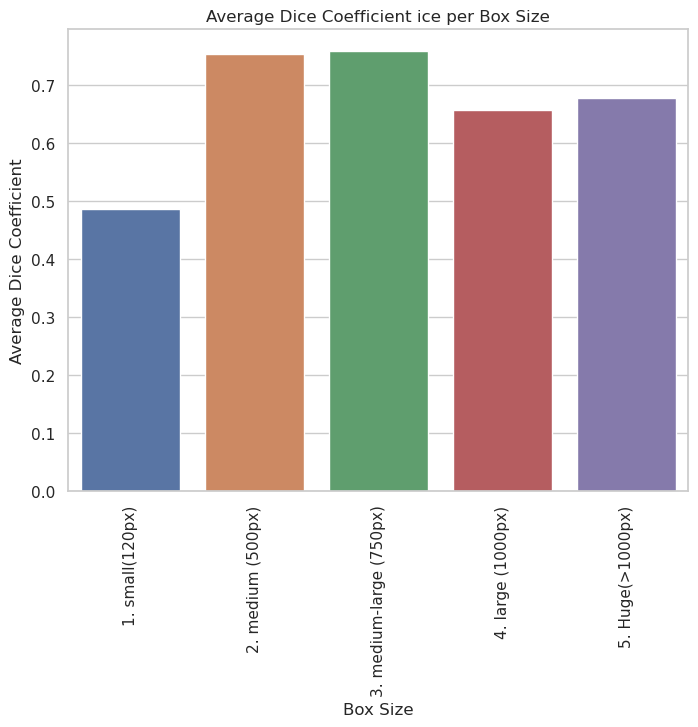

            dice       width      height       box_area
count  99.000000  100.000000  100.000000     100.000000
mean    0.756218  120.925000  111.435000   26229.717500
std     0.206961  134.721793  127.326207   61017.350302
min     0.000000    8.500000   12.000000     132.000000
25%     0.722823   37.500000   34.000000    1787.500000
50%     0.820988   79.250000   64.000000    5577.000000
75%     0.868100  133.250000  117.000000   10966.500000
max     0.961885  512.000000  512.000000  262144.000000


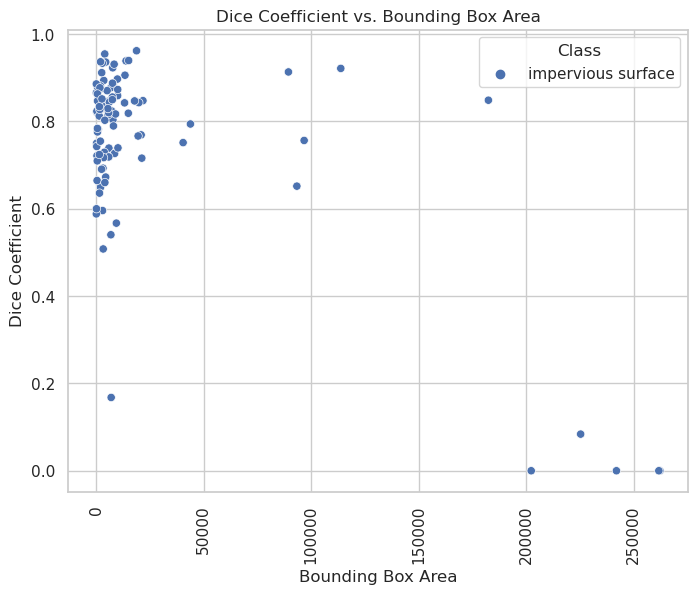

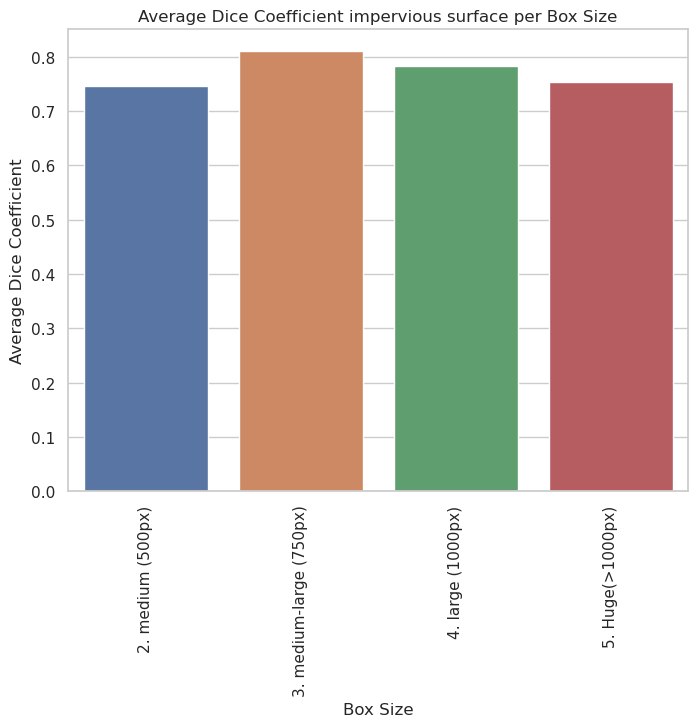

            dice       width      height       box_area
count  99.000000   99.000000   99.000000      99.000000
mean    0.770328  142.514348  140.775967   29314.141161
std     0.183175  110.220592  104.395039   41492.660053
min     0.000000    1.500000    2.000000       4.000000
25%     0.703049   68.500000   68.000000    5314.500000
50%     0.831273  103.000000  110.000000   10736.000000
75%     0.903495  191.000000  169.000000   31004.500000
max     0.971477  486.000000  494.000000  178334.000000


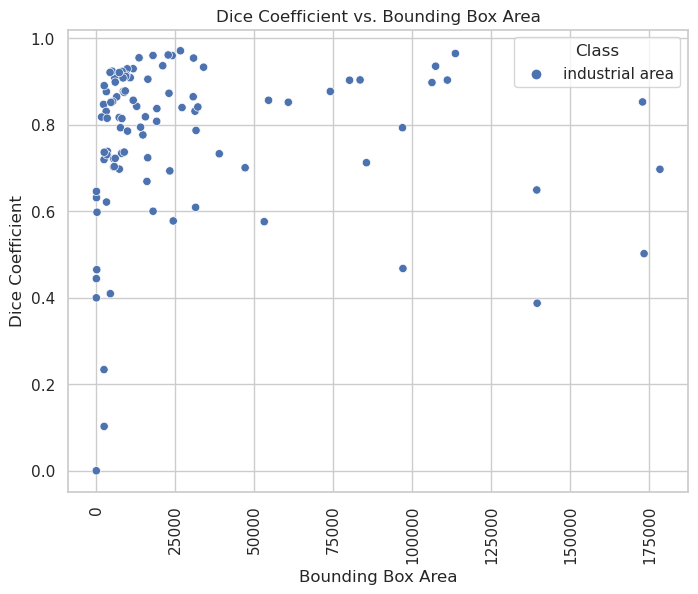

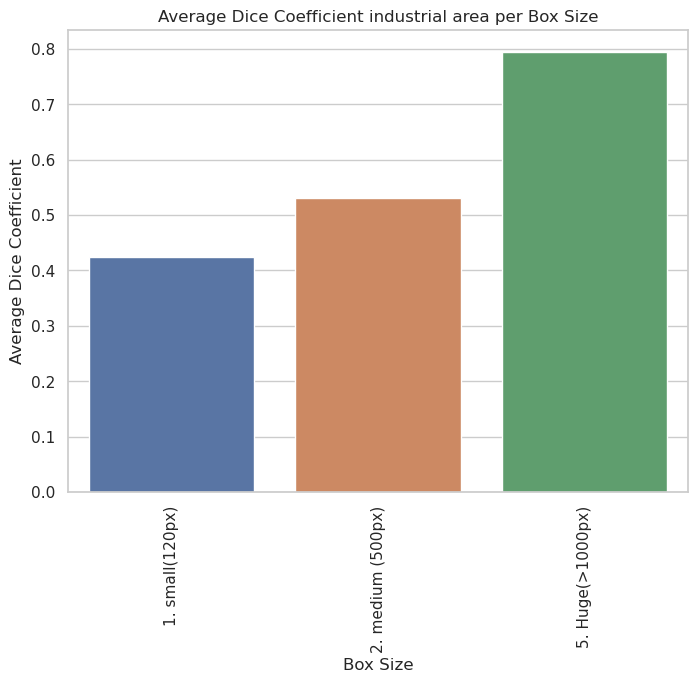

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.652617   29.590000   27.160000   1603.472500
std      0.226480   31.603556   27.566621   2914.751831
min      0.000000    1.500000    2.000000      3.000000
25%      0.570238    4.000000    4.000000     15.500000
50%      0.666667   19.000000   16.000000    343.500000
75%      0.816557   46.000000   44.250000   1901.250000
max      0.985373  133.000000  136.000000  16592.000000


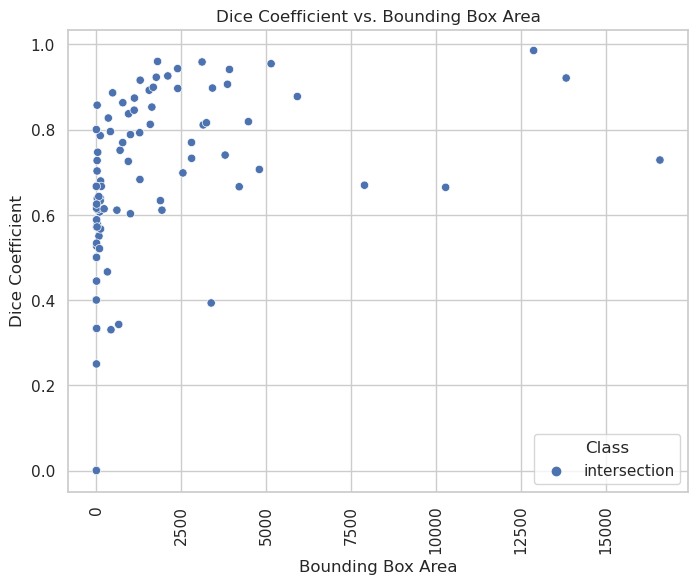

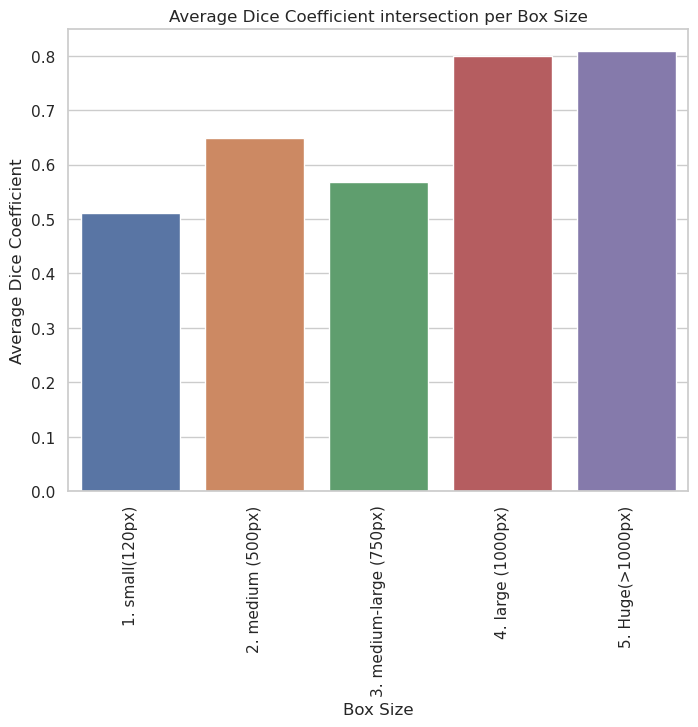

             dice        width       height      box_area
count  100.000000   100.000000   100.000000  1.000000e+02
mean     0.829980   233.572538   230.756914  1.081465e+05
std      0.185162   230.920856   261.284754  2.171367e+05
min      0.000000     5.000000     1.500000  7.500000e+00
25%      0.796776    65.551437    66.190688  5.492568e+03
50%      0.885196   150.548179   118.877540  1.678591e+04
75%      0.938031   301.500000   279.490546  7.984381e+04
max      0.987918  1033.459597  1171.000000  1.122989e+06


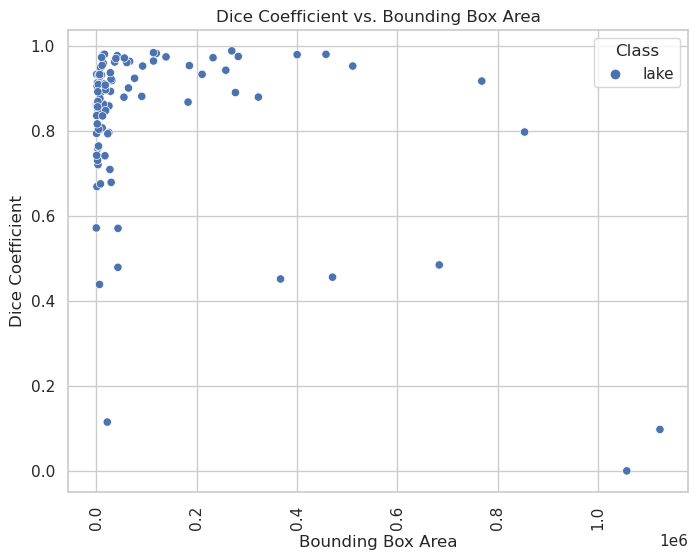

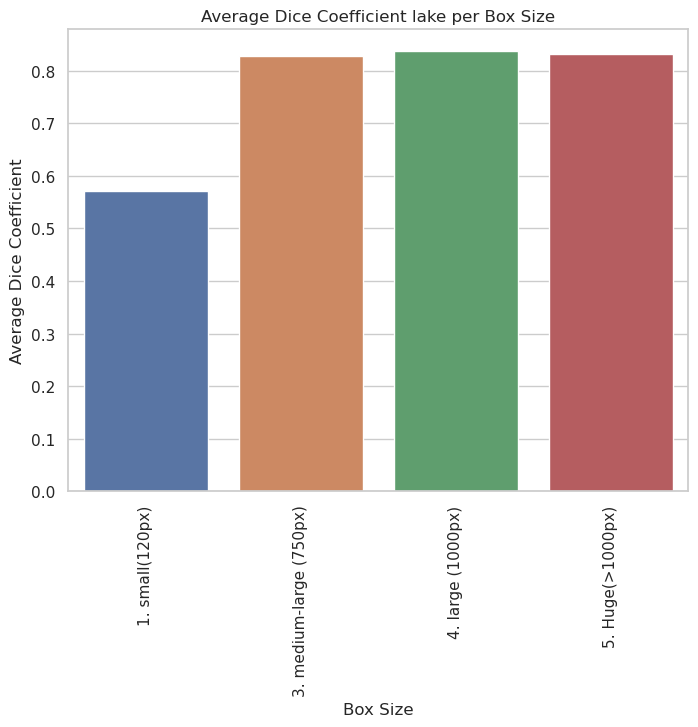

            dice       width      height       box_area
count  12.000000   12.000000   12.000000      12.000000
mean    0.875721  460.271622  416.781004  226803.953507
std     0.090070  190.301172  265.186582  206247.152787
min     0.706817  108.000000  103.000000   23004.000000
25%     0.831322  320.355969  201.268527   60554.757518
50%     0.891164  456.155062  371.220988  205681.724693
75%     0.953167  580.217086  565.413598  296464.840766
max     0.972599  825.000000  900.717590  667425.000000


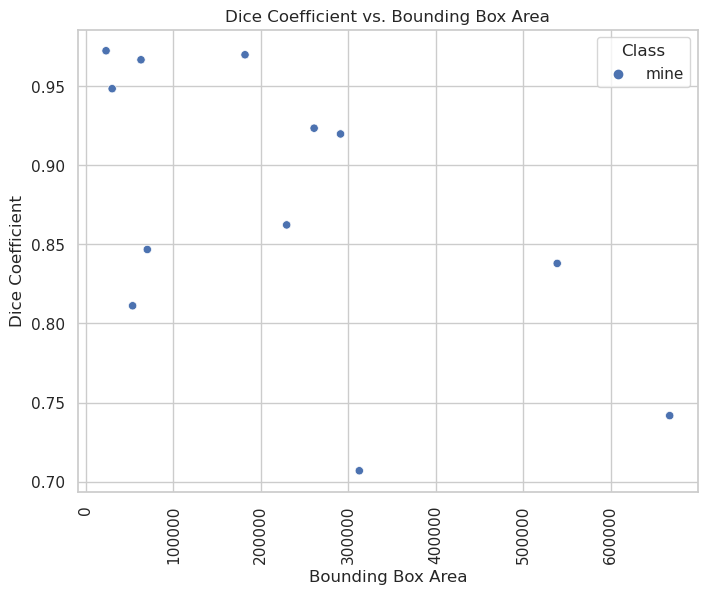

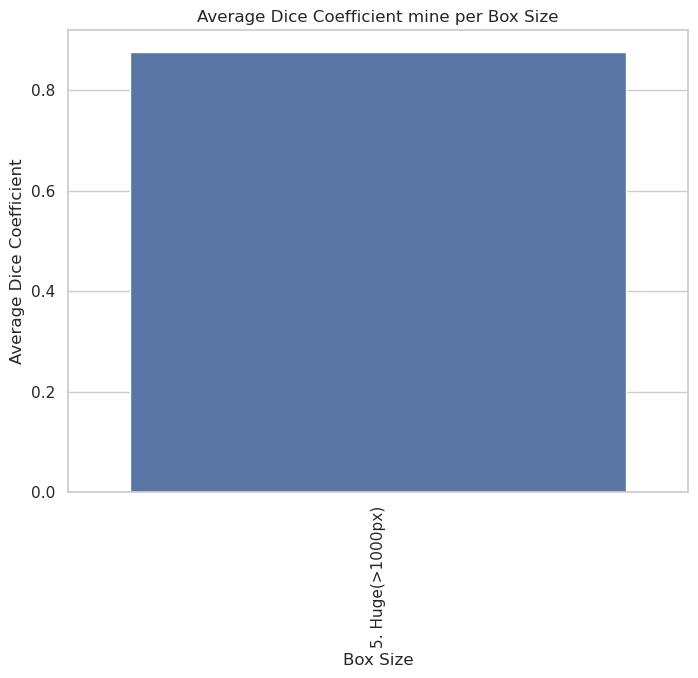

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.606599   87.275000   49.915000   15782.532500
std      0.266476  170.869351   97.538417   41664.750743
min      0.000000    1.500000    2.000000       3.000000
25%      0.496896    3.875000    4.000000      14.375000
50%      0.647059    7.250000    6.000000      40.000000
75%      0.772497   31.750000   31.250000     861.750000
max      0.993479  732.000000  626.000000  304549.000000


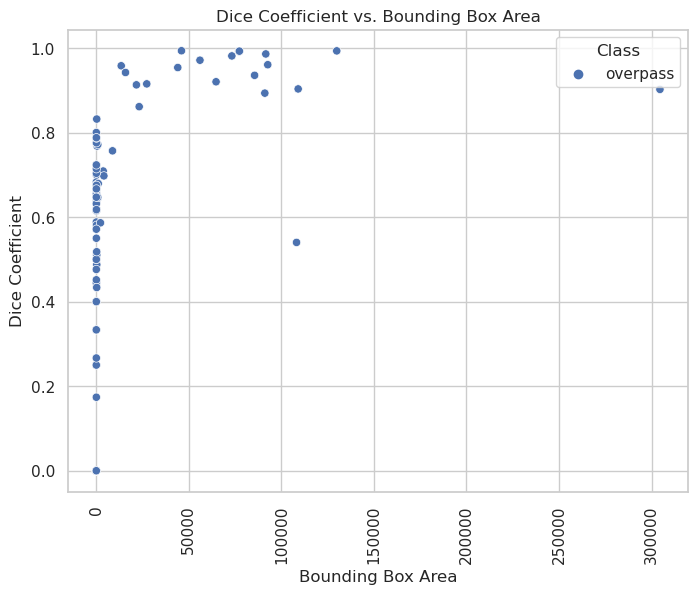

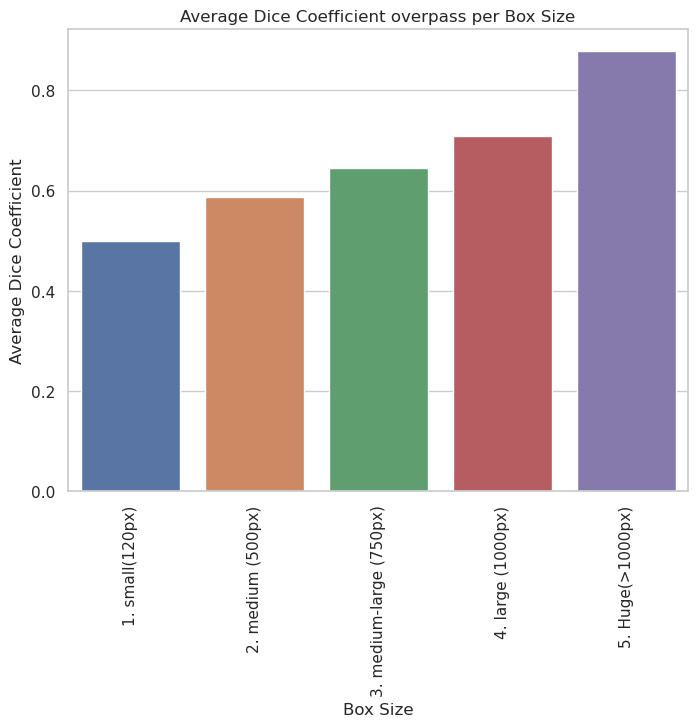

            dice       width      height      box_area
count  95.000000  100.000000  100.000000    100.000000
mean    0.480668  142.025000  141.380000  26438.812500
std     0.339790   96.669498   99.984143  26278.007931
min     0.000000    2.000000    2.000000     13.000000
25%     0.006140   47.625000   40.000000   2388.000000
50%     0.573115  128.250000  123.000000  14720.000000
75%     0.765815  256.000000  256.000000  58368.000000
max     0.954219  256.000000  256.000000  65536.000000


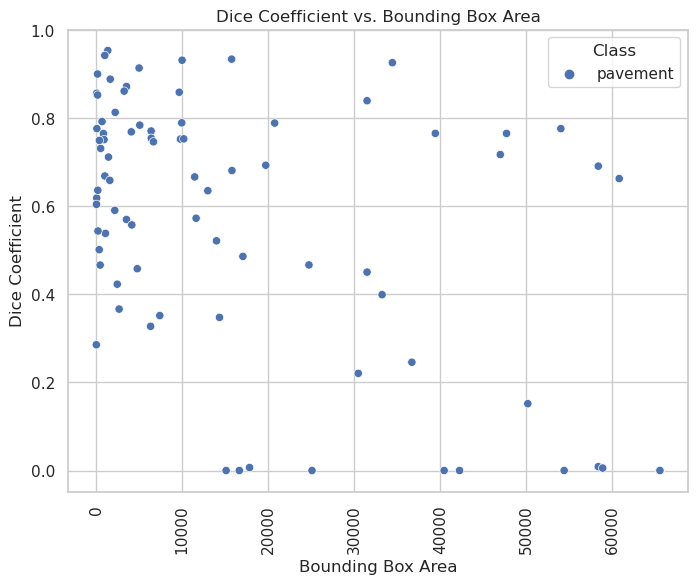

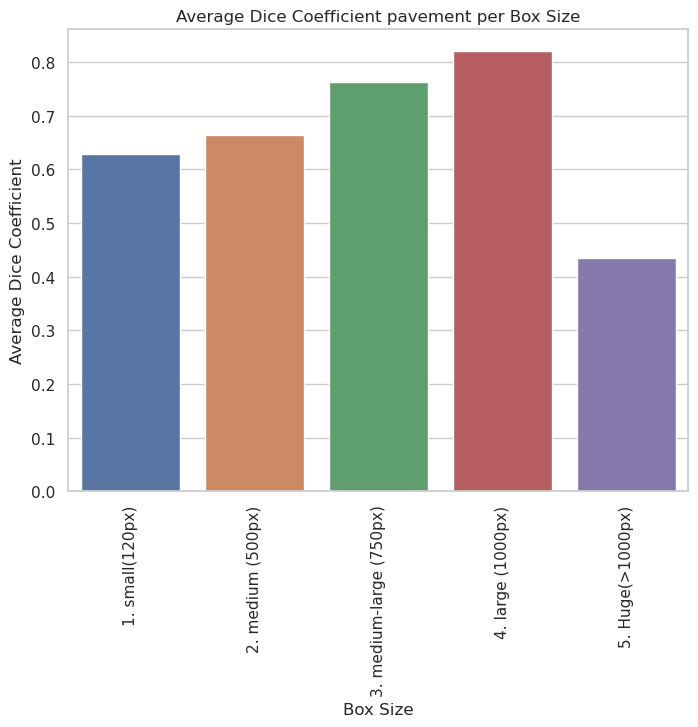

             dice        width      height       box_area
count  100.000000   100.000000   100.00000     100.000000
mean     0.866655   151.710000   150.68000   46733.505000
std      0.145337   166.760401   167.63188  125928.284091
min      0.000000     1.500000     2.00000       3.000000
25%      0.848363    50.750000    50.75000    2741.250000
50%      0.913071   103.000000   104.50000   10773.500000
75%      0.948112   179.250000   162.62500   27238.000000
max      0.985600  1012.000000  1113.00000  929355.000000


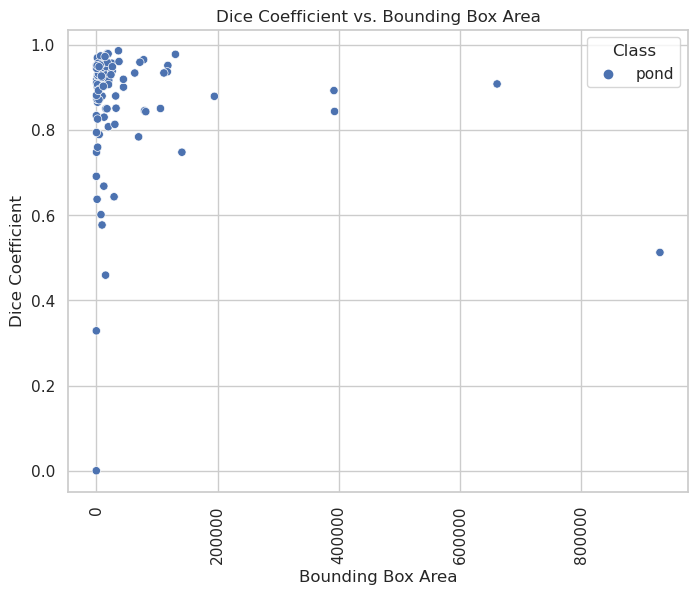

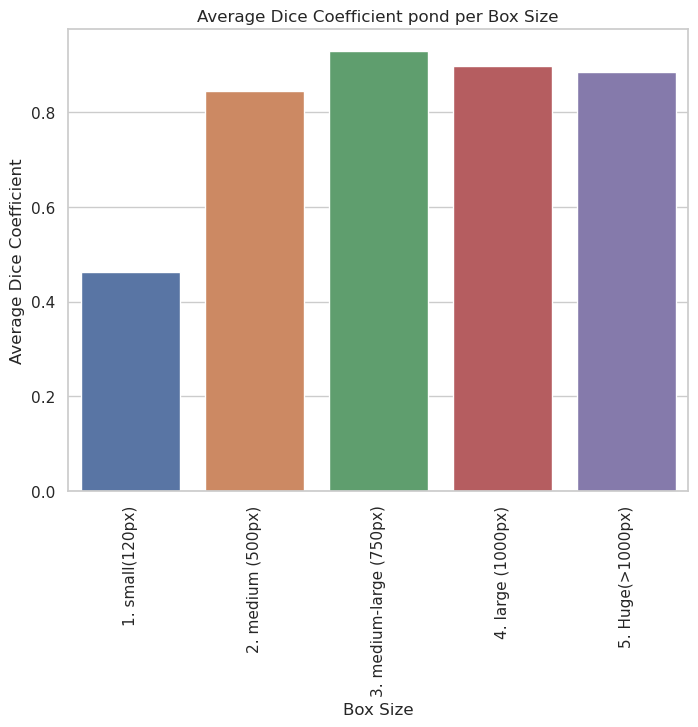

            dice       width      height      box_area
count  18.000000   18.000000   18.000000     18.000000
mean    0.774967   41.854075   46.839200   2669.207354
std     0.073737   25.171298   30.485247   4408.249471
min     0.661022   14.372242   19.925153    286.369119
25%     0.710519   29.812461   30.283240    886.042037
50%     0.782500   33.183172   35.841974   1185.002513
75%     0.827899   48.006322   51.374596   2490.377804
max     0.918708  130.000000  151.000000  19630.000000


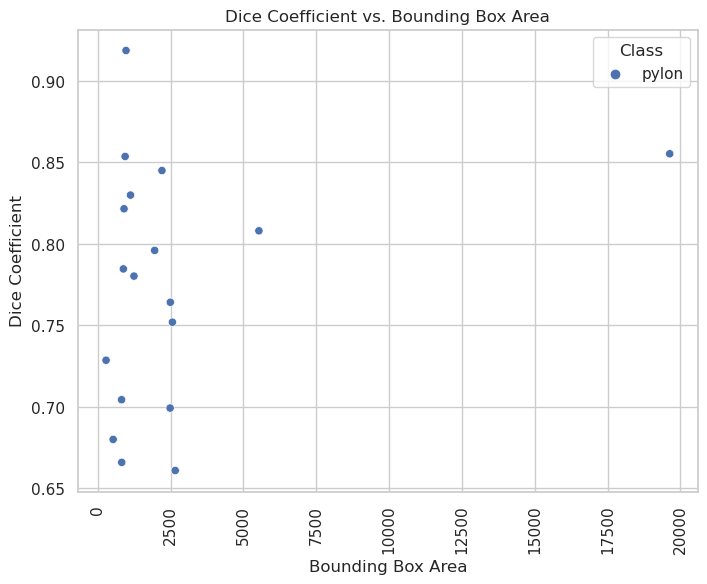

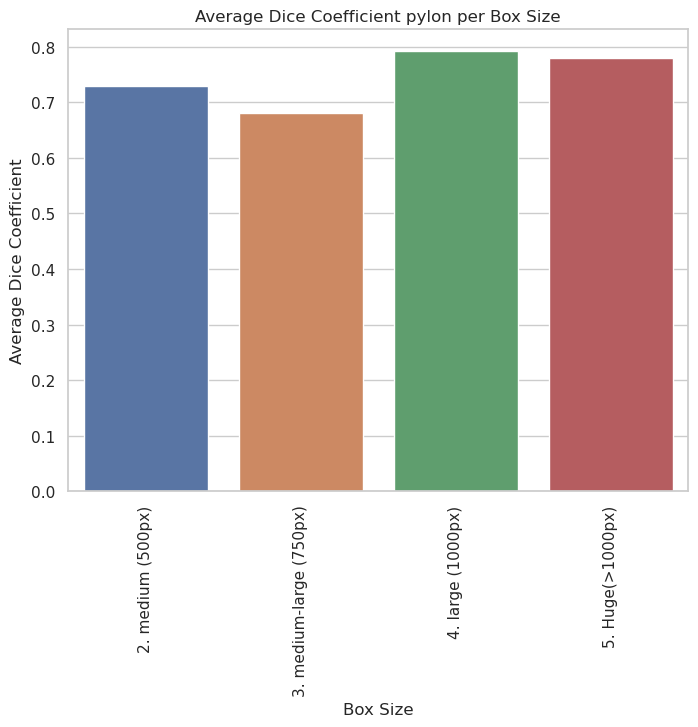

             dice      width       height       box_area
count  100.000000  100.00000   100.000000     100.000000
mean     0.568951  105.82000   106.610000   27855.177500
std      0.215488  154.83609   166.874167   85735.721158
min      0.000000    2.50000     1.500000       5.000000
25%      0.443723   10.37500    13.375000     118.500000
50%      0.601321   40.50000    49.000000    2166.500000
75%      0.743034  125.25000   113.250000   13340.375000
max      0.932234  842.00000  1000.000000  676000.000000


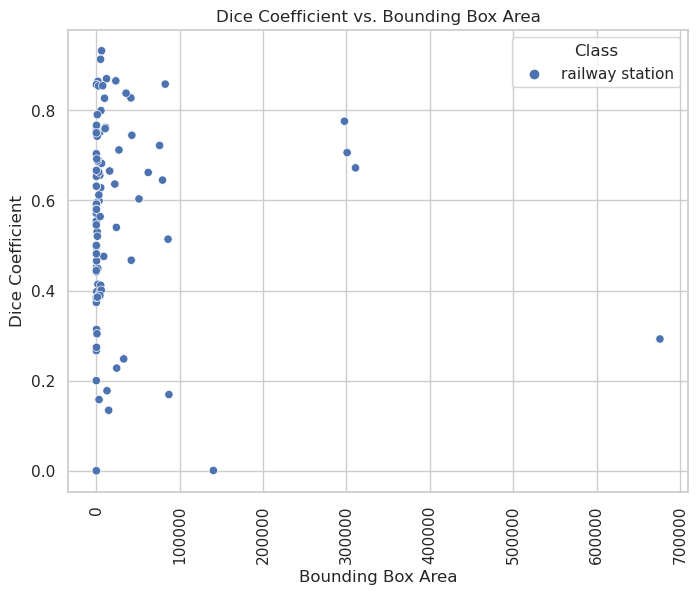

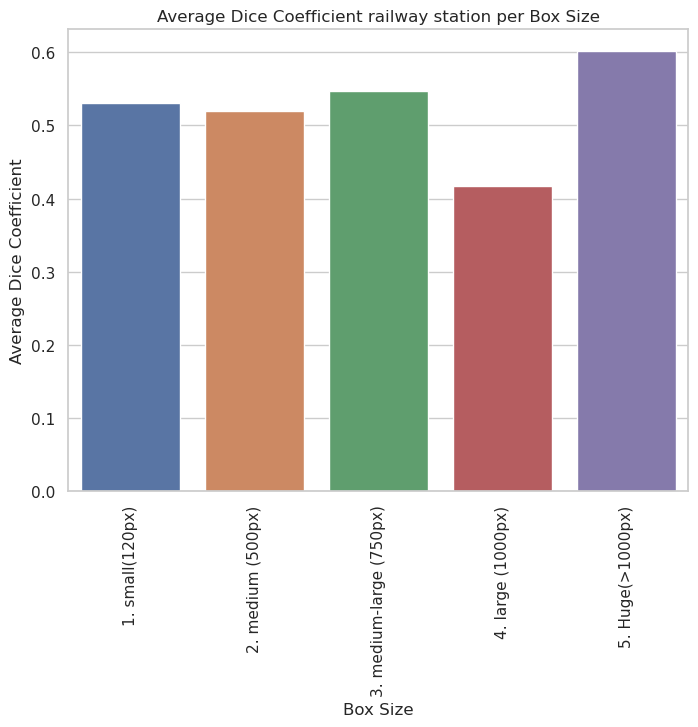

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.567405   59.631604   62.493880   10318.424679
std      0.203285   88.499631   85.335630   34496.465426
min      0.000000    1.500000    2.000000       5.000000
25%      0.461599   11.875000   13.875000     129.375000
50%      0.609179   23.500000   35.000000     845.500000
75%      0.720999   64.750000   82.500000    6045.500000
max      0.941176  569.160439  515.388014  293338.467900


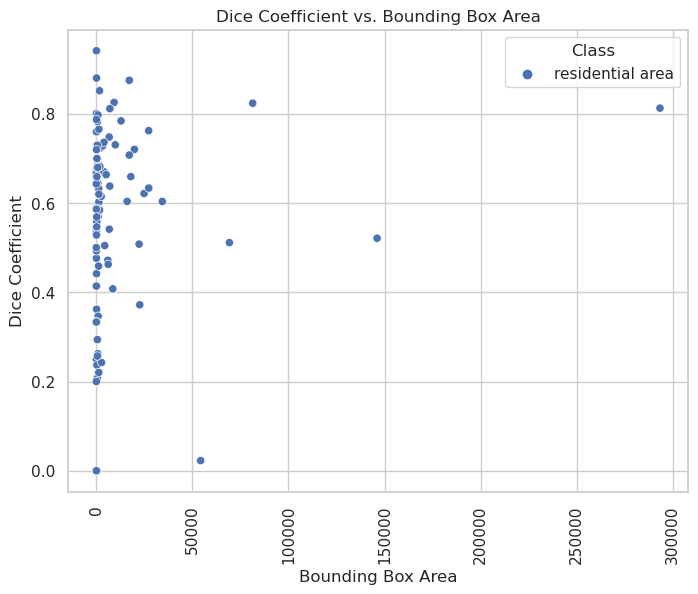

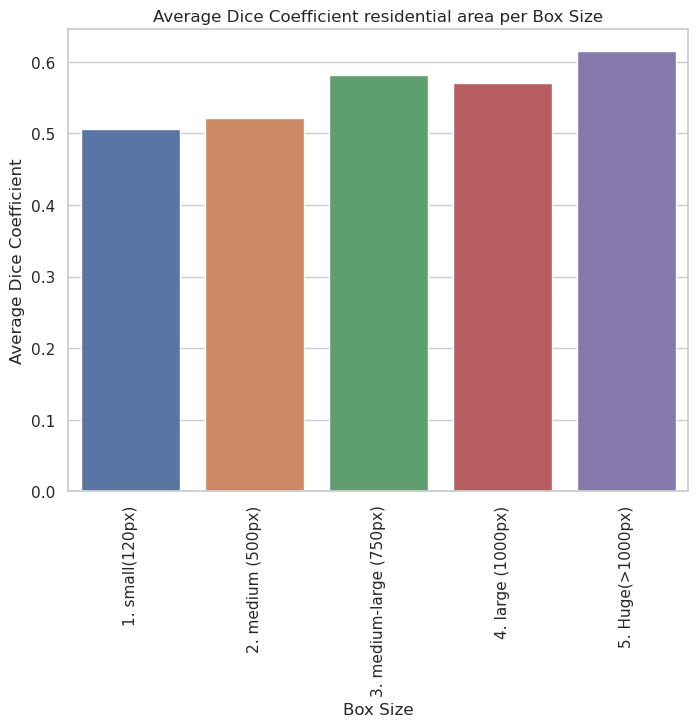

            dice        width       height      box_area
count  98.000000    98.000000    98.000000  9.800000e+01
mean    0.631091   521.147924   564.253256  8.109314e+05
std     0.337414   822.401579   877.521112  3.055212e+06
min     0.000000     1.500000     2.000000  3.000000e+00
25%     0.335015   105.875000   127.000000  1.294475e+04
50%     0.807001   275.750000   292.750000  6.640730e+04
75%     0.910529   519.292534   644.500000  2.719928e+05
max     0.985923  4742.000000  6113.000000  2.333332e+07


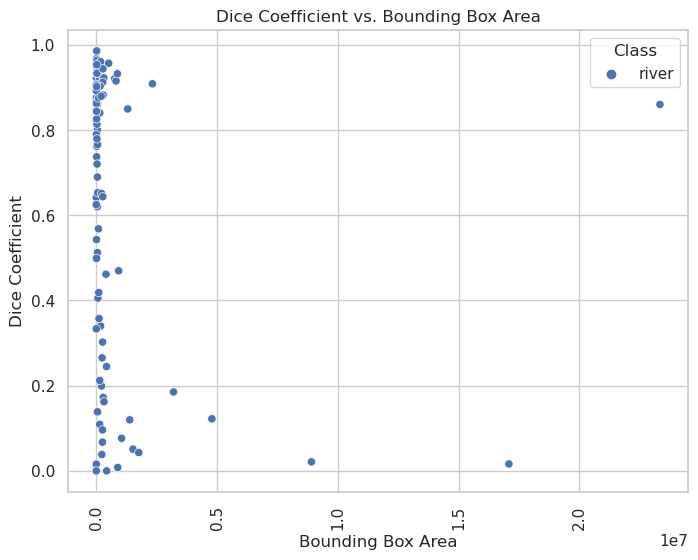

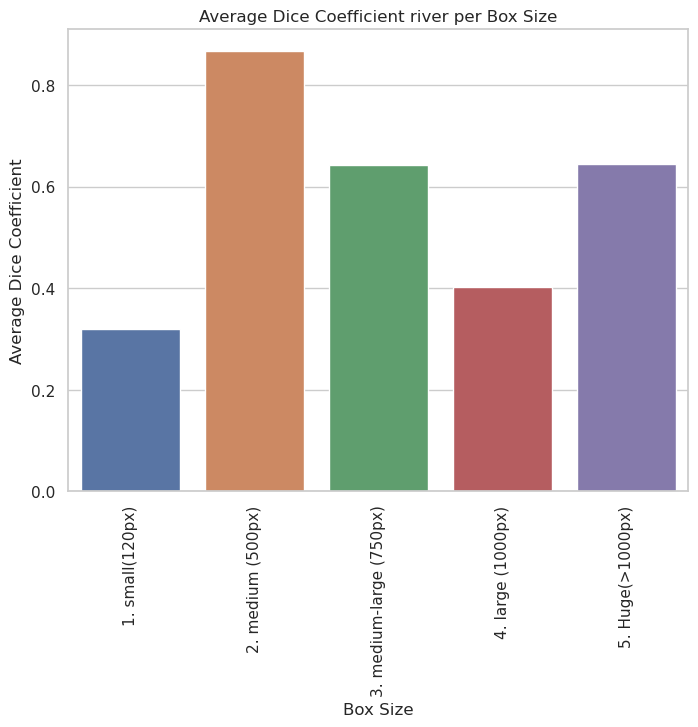

            dice        width       height      box_area
count  87.000000   100.000000   100.000000  1.000000e+02
mean    0.393904   358.946772   335.921611  2.518402e+05
std     0.297318   409.794208   388.301579  3.742116e+05
min     0.000000     1.500000     2.000000  4.500000e+00
25%     0.101194    20.750000    24.500000  6.907500e+02
50%     0.366957   118.750000   139.250000  1.911650e+04
75%     0.637314   835.000000   581.750000  4.975041e+05
max     0.977275  1026.789248  1025.265971  1.022988e+06


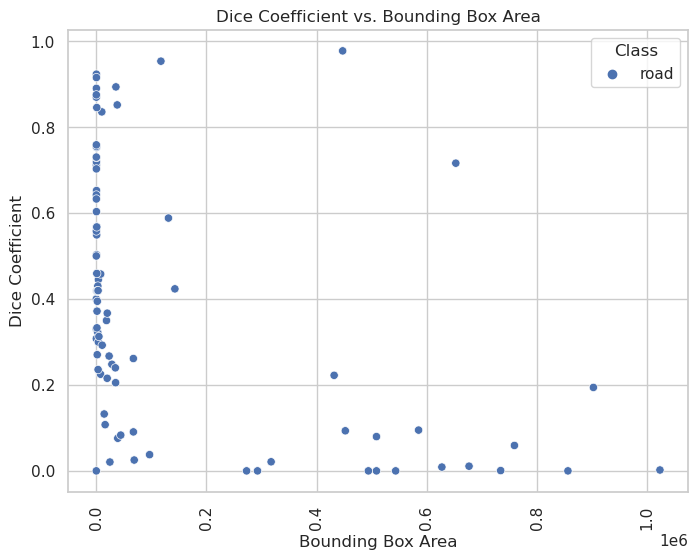

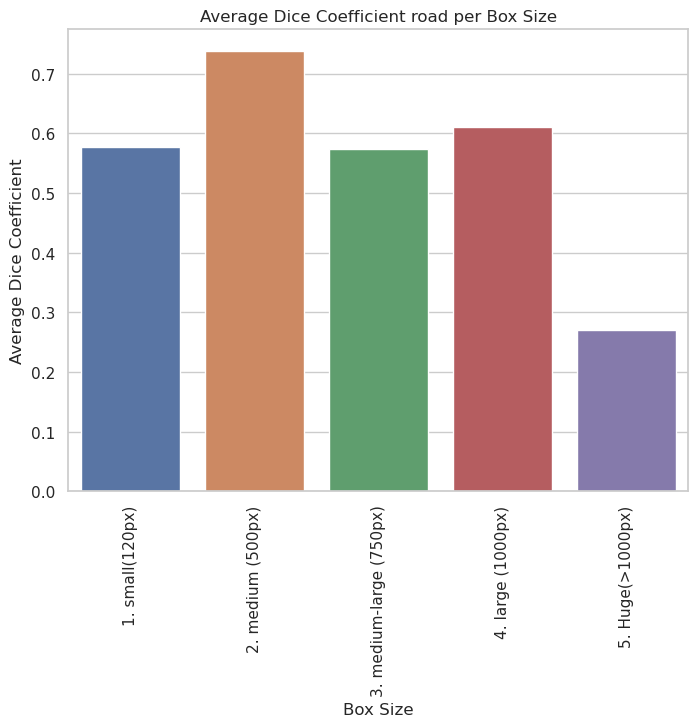

             dice       width     height       box_area
count  100.000000  100.000000  100.00000     100.000000
mean     0.833177   50.965000   50.61000    6963.070000
std      0.178286   67.109335   66.95029   25155.829688
min      0.000000    1.500000    2.00000       3.000000
25%      0.809705   18.750000   19.75000     354.000000
50%      0.869747   33.500000   34.50000    1147.000000
75%      0.930397   54.000000   53.00000    3063.000000
max      0.992102  441.000000  447.00000  197127.000000


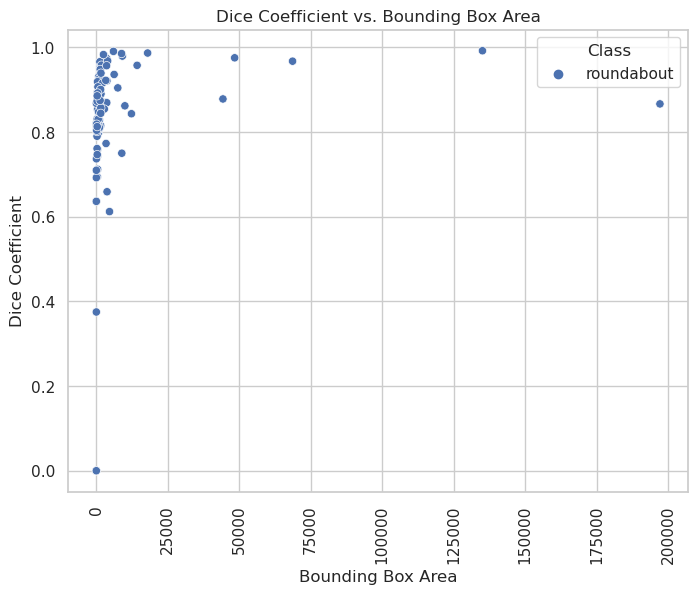

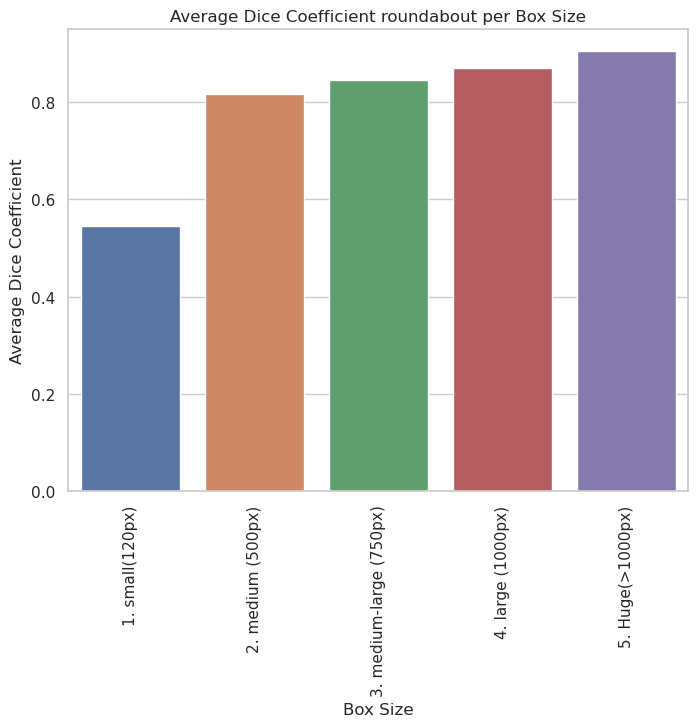

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.784030  141.145000  134.410000   24588.922500
std      0.168635   91.123911   85.382662   27912.152549
min      0.000000    1.500000    2.000000       3.000000
25%      0.727841   72.750000   67.000000    5844.250000
50%      0.823573  121.000000  127.500000   13962.000000
75%      0.906971  195.000000  171.750000   30154.000000
max      0.964293  407.000000  458.000000  136305.000000


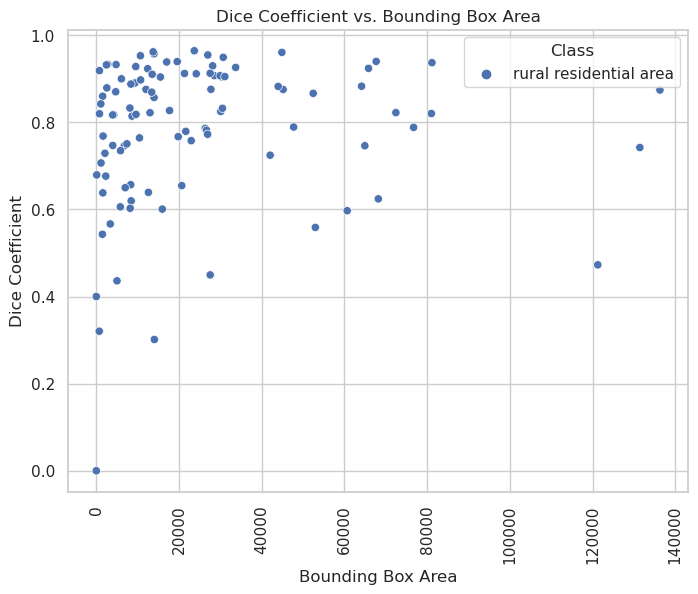

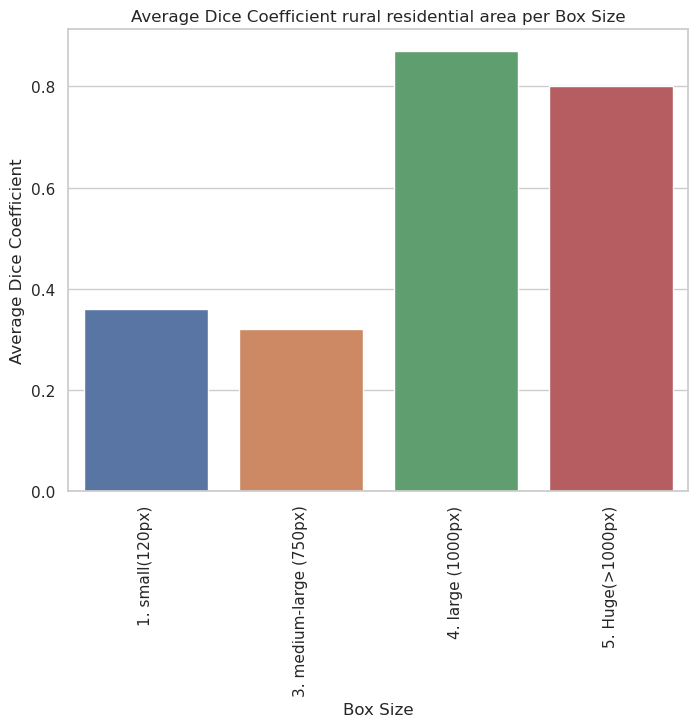

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.304447  222.385000  237.145000  52838.090000
std      0.423582   46.415278   37.729854  11563.565226
min      0.000000    2.500000    2.000000      5.000000
25%      0.000000  197.750000  230.625000  44522.250000
50%      0.000000  255.500000  256.000000  54272.000000
75%      0.876460  256.000000  256.000000  65408.000000
max      0.995822  256.000000  256.000000  65536.000000


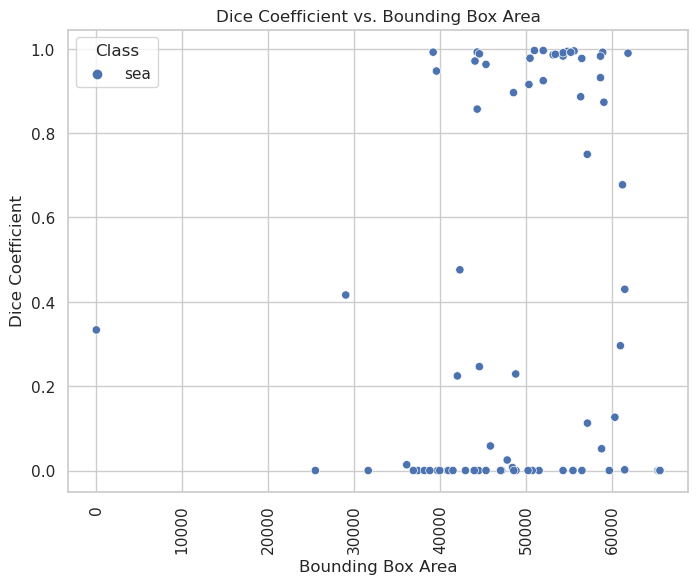

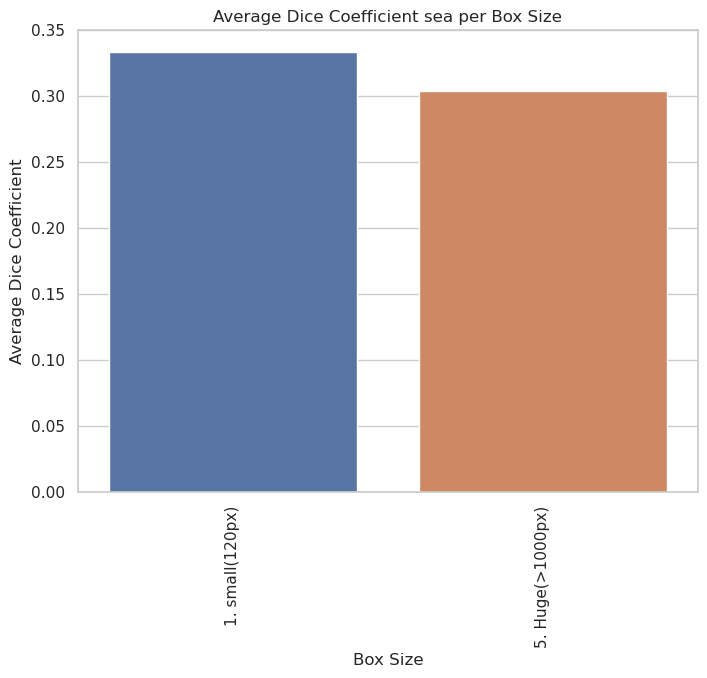

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.837623   44.970000   45.105000    4240.977500
std      0.140051   60.668491   45.530448   17109.701791
min      0.000000    1.500000    2.000000       3.000000
25%      0.798168   17.750000   23.000000     493.000000
50%      0.875862   28.500000   36.000000    1028.500000
75%      0.931430   48.500000   47.250000    2042.000000
max      0.976170  524.000000  303.000000  158772.000000


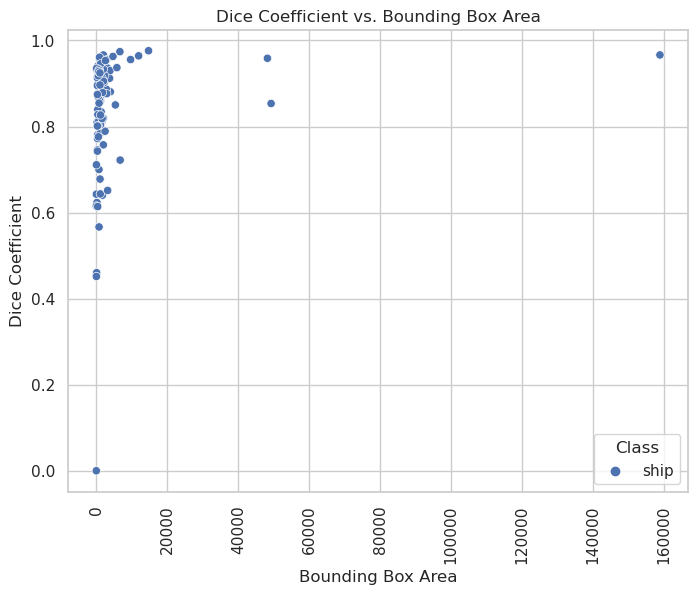

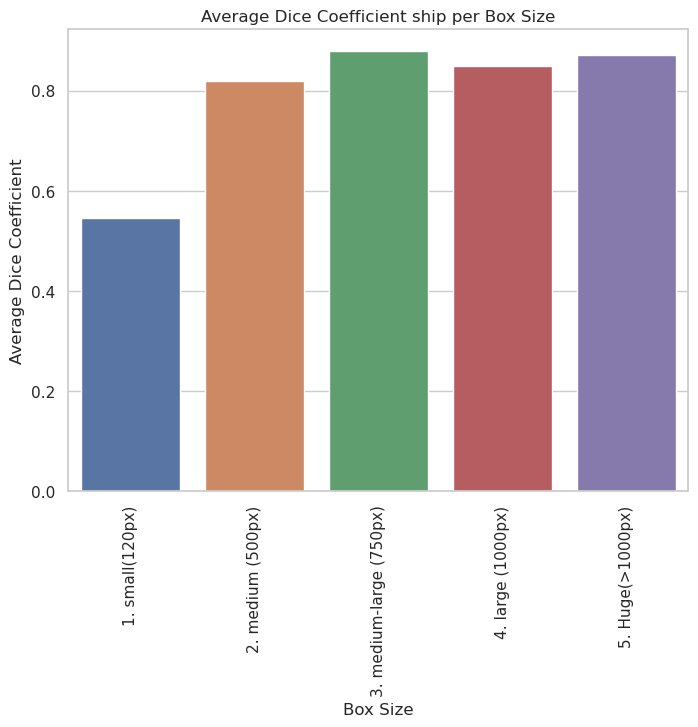

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.513362  108.530000   95.180000   32124.905000
std      0.252159  179.721232  153.590866   93988.360157
min      0.000000    1.500000    2.000000       3.000000
25%      0.333333    9.750000    8.500000     105.250000
50%      0.529353   36.000000   36.750000    1544.000000
75%      0.714146  107.750000  108.500000   11218.000000
max      0.955533  895.000000  818.500000  511045.000000


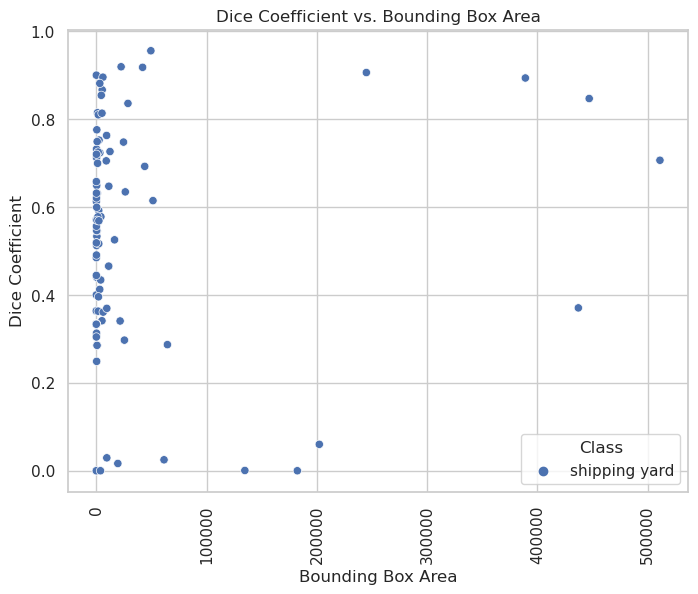

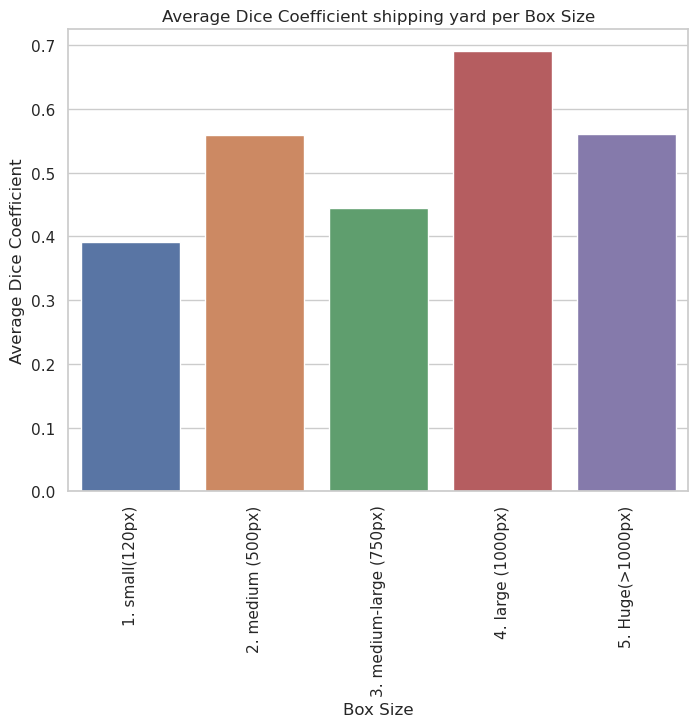

             dice      width      height       box_area
count  100.000000  100.00000  100.000000     100.000000
mean     0.670199   48.50500   58.220000   13351.492500
std      0.186843   96.27398  117.758384   45865.687156
min      0.000000    2.50000    2.000000       5.000000
25%      0.596518    8.00000    7.000000      56.750000
50%      0.678987   12.50000   12.500000     140.500000
75%      0.771765   30.25000   25.250000     713.000000
max      0.990741  512.00000  512.000000  262144.000000


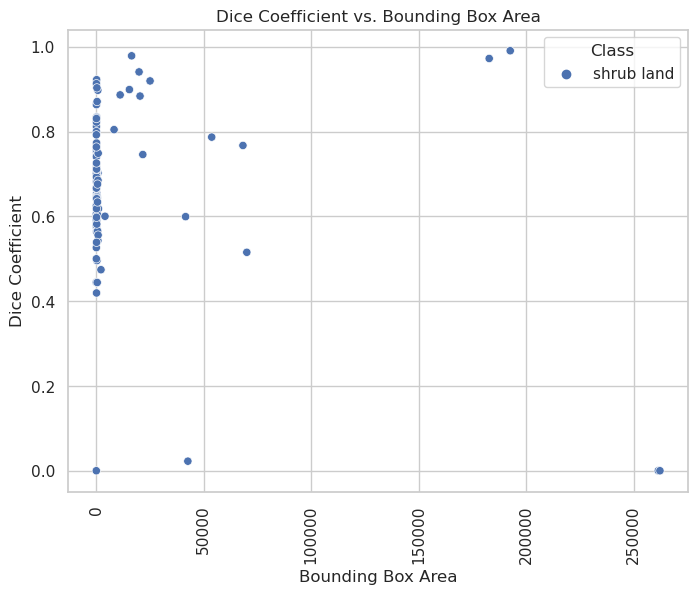

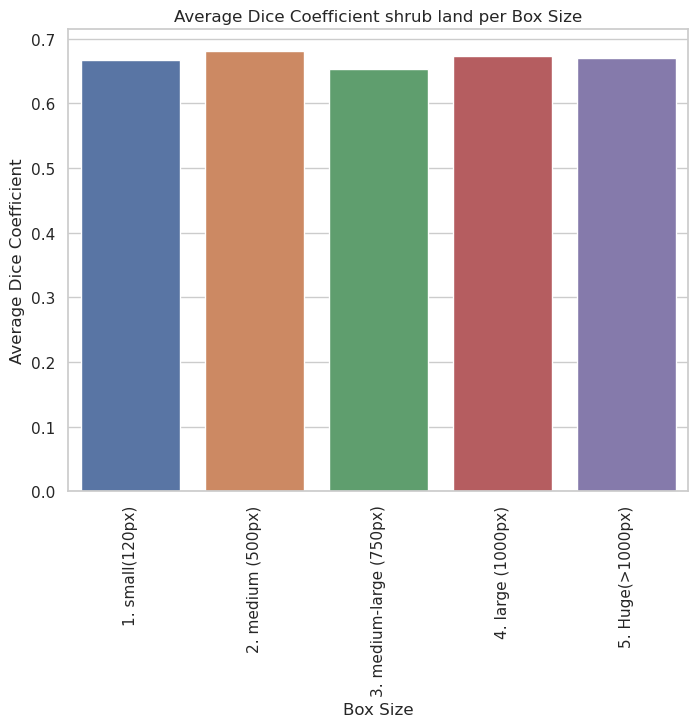

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.740236  124.115000  141.065000   52601.877500
std      0.233878  185.873923  210.673159  115681.337099
min      0.000000    1.500000    2.000000       3.000000
25%      0.649893    5.000000    6.375000      27.250000
50%      0.778380   29.000000   21.500000     653.000000
75%      0.929273  148.750000  216.500000   28391.500000
max      0.991733  718.000000  922.000000  630404.000000


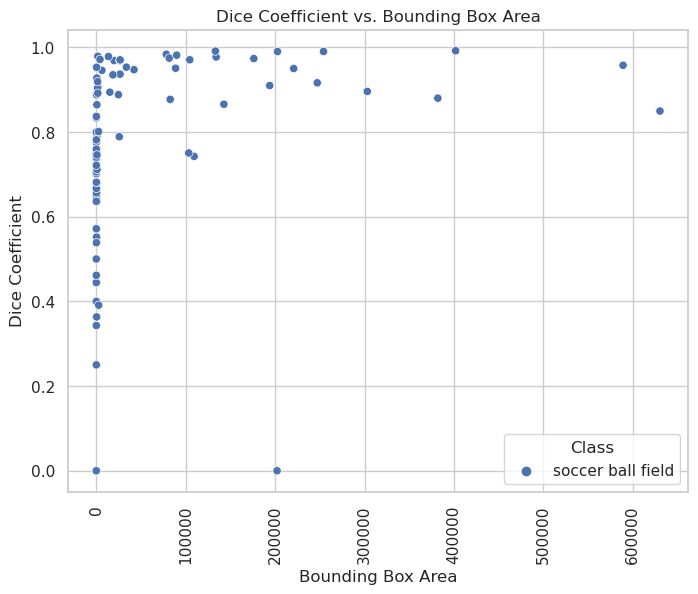

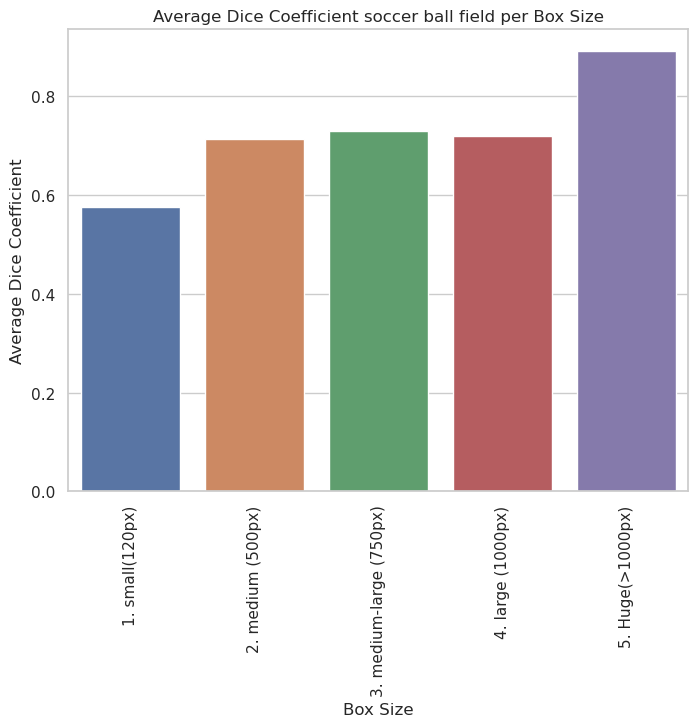

            dice       width      height       box_area
count  26.000000   26.000000   26.000000      26.000000
mean    0.876333  148.549369  130.057849   29301.357714
std     0.081835  116.820263  104.177029   47241.396587
min     0.704663   28.809824   40.186952    1189.498983
25%     0.841466   84.460509   62.442403    5173.759132
50%     0.911881  110.833342   98.307759   10586.361044
75%     0.935646  166.639513  118.254455   18514.419468
max     0.973204  513.132844  418.656598  209167.773953


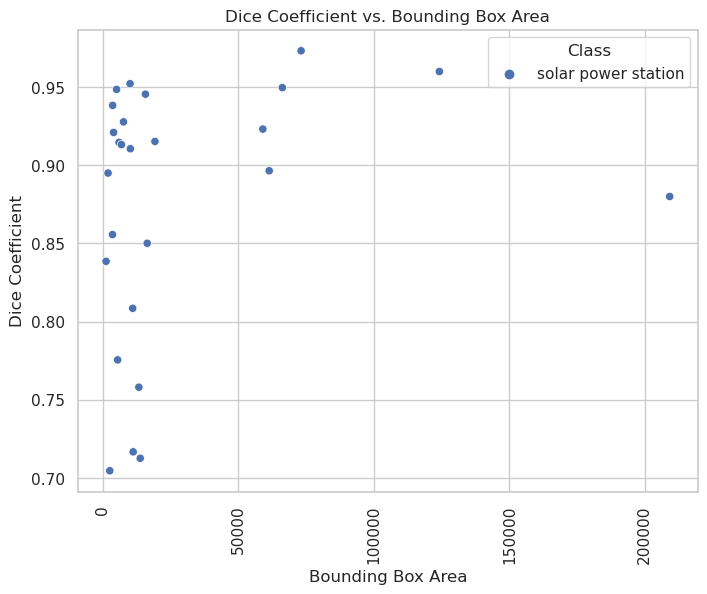

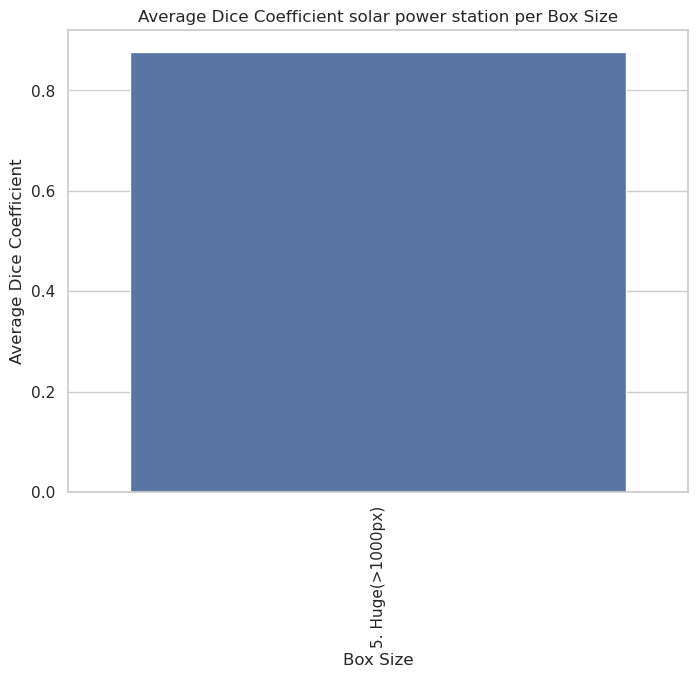

             dice       width       height       box_area
count  100.000000  100.000000   100.000000     100.000000
mean     0.491169   47.270000    64.200000    5804.270000
std      0.218286   59.678576   134.672405   19199.384492
min      0.000000    1.500000     2.000000       3.000000
25%      0.345083    7.875000     9.000000      71.875000
50%      0.500000   20.750000    23.500000     462.500000
75%      0.667318   61.000000    57.750000    3945.125000
max      0.919898  263.000000  1000.000000  177000.000000


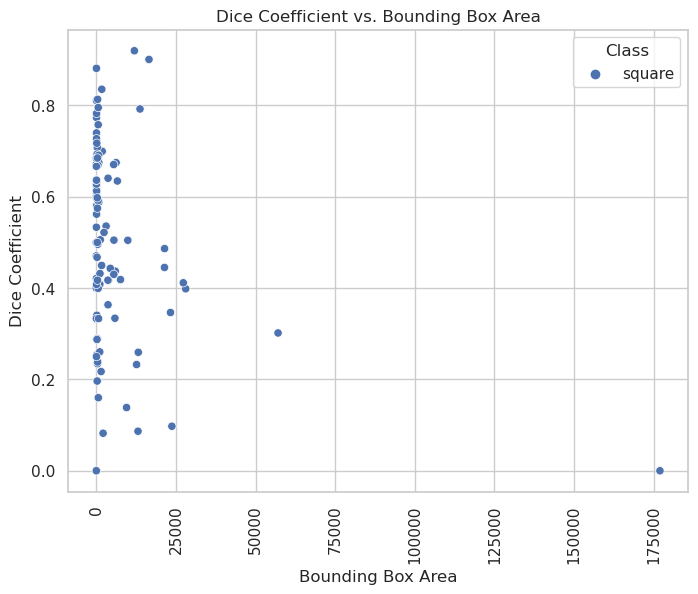

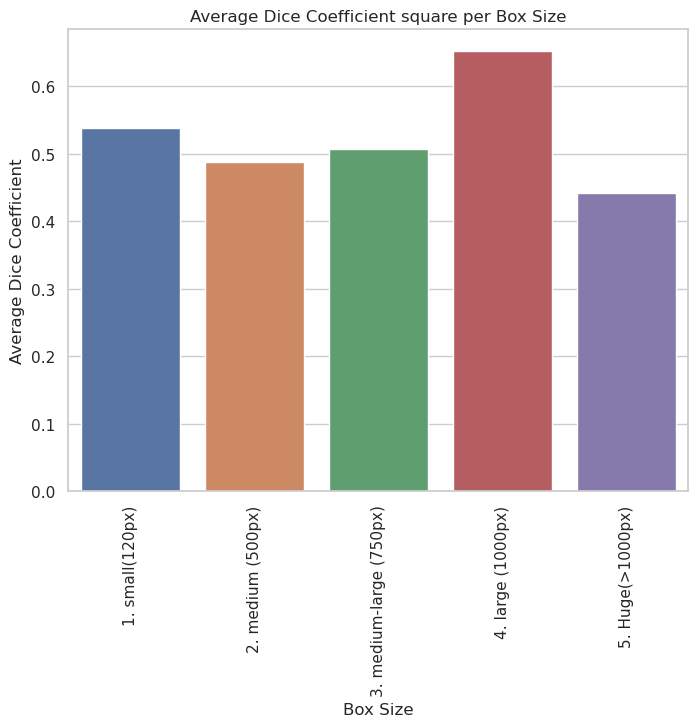

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.615992   64.314430   72.190204   26154.867191
std      0.266736  137.628552  162.457326   82943.700841
min      0.000000    1.500000    2.000000       3.000000
25%      0.515498    3.500000    3.000000      12.000000
50%      0.661134    6.000000    5.500000      37.500000
75%      0.783848   22.816230   34.281741     583.158110
max      0.997704  619.000000  753.000000  448156.000000


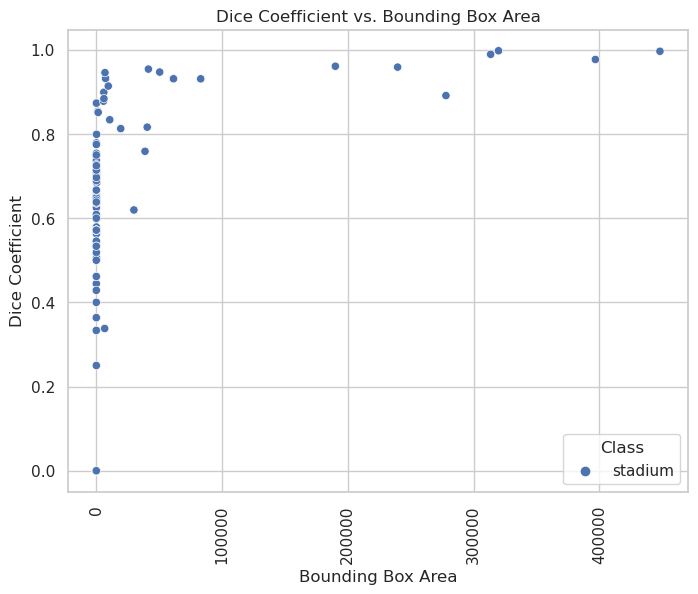

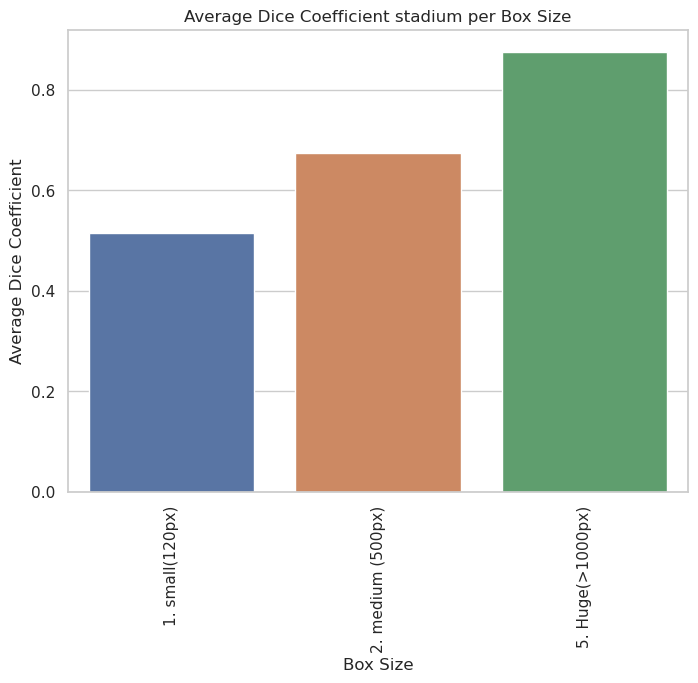

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.797745   33.160000   30.480000   1936.880000
std      0.129392   35.866115   28.428709   4763.521056
min      0.091141    6.000000    4.000000     24.000000
25%      0.745692   20.000000   19.000000    395.000000
50%      0.798329   20.000000   20.000000    400.000000
75%      0.883127   34.250000   32.250000   1085.250000
max      0.990984  248.000000  180.000000  33120.000000


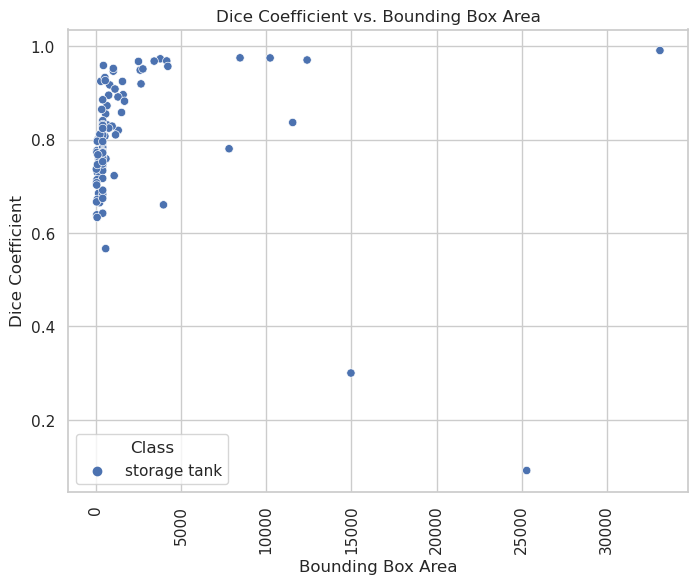

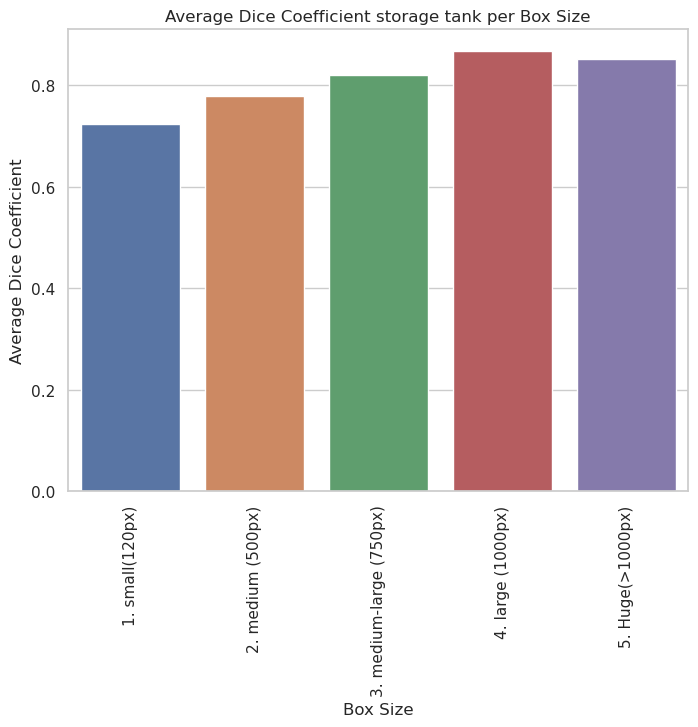

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.864847   53.370000   50.520000    5027.980000
std      0.094891   57.345075   45.259628   16150.296674
min      0.627700    7.000000    8.000000      77.000000
25%      0.795877   22.000000   22.750000     669.000000
50%      0.892027   39.000000   37.500000    1587.000000
75%      0.935718   62.000000   67.000000    3908.000000
max      0.981163  389.000000  308.000000  115192.000000


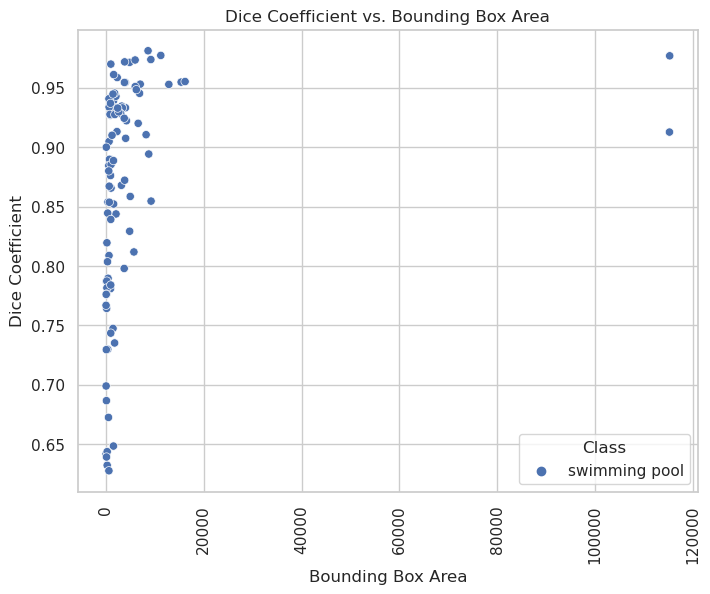

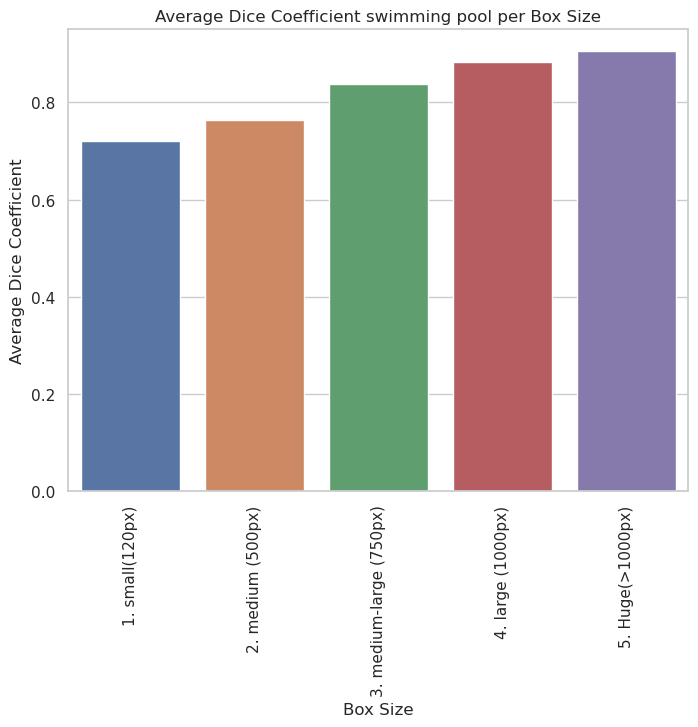

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.917126   84.910000  131.080000  13952.100000
std      0.142960   49.996484   68.578891  12568.004407
min      0.000000    1.500000    2.000000      4.500000
25%      0.920553   48.000000   84.750000   3996.000000
50%      0.968956   79.000000  126.000000  10901.500000
75%      0.981683  111.250000  190.250000  21086.250000
max      0.992159  224.000000  294.000000  54096.000000


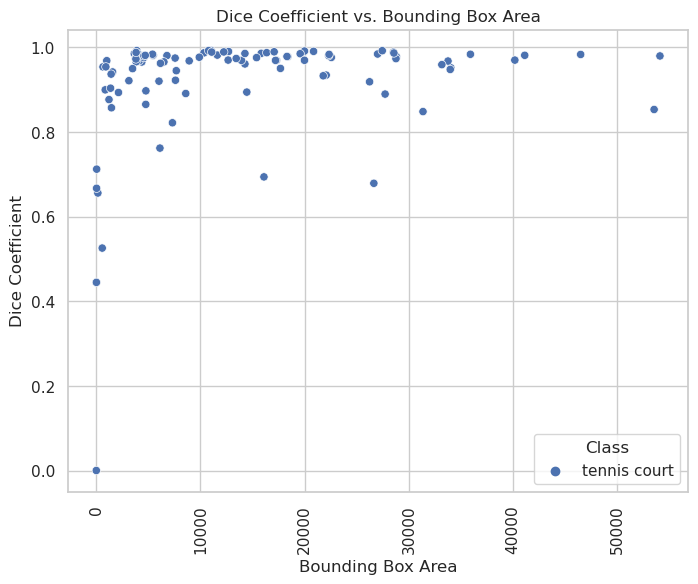

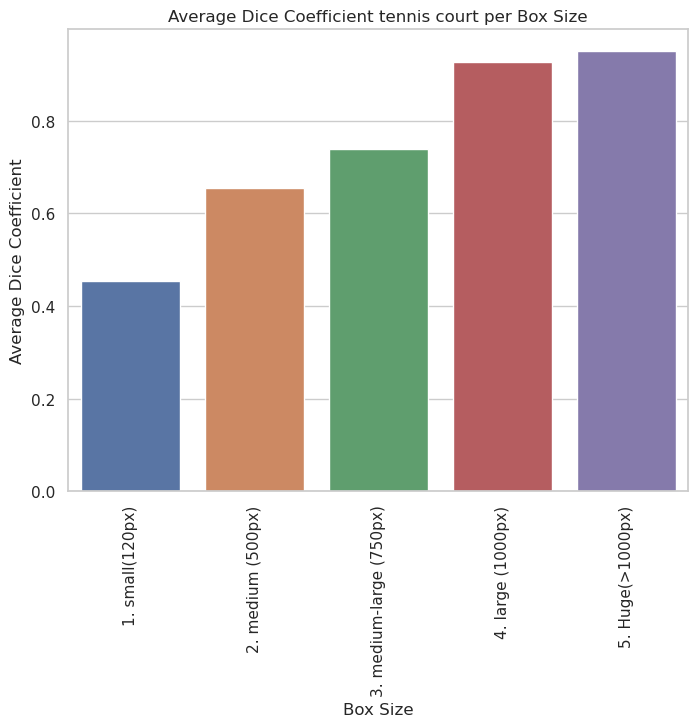

            dice      width      height      box_area
count  99.000000  100.00000  100.000000    100.000000
mean    0.745967   58.25500   55.460000   6046.682500
std     0.185496   61.63232   57.943532  13703.267035
min     0.000000    7.00000    8.000000     56.000000
25%     0.696003   18.00000   22.750000    495.000000
50%     0.786248   36.25000   37.500000   1163.250000
75%     0.876260   65.50000   56.000000   4048.125000
max     0.982708  256.00000  256.000000  65536.000000


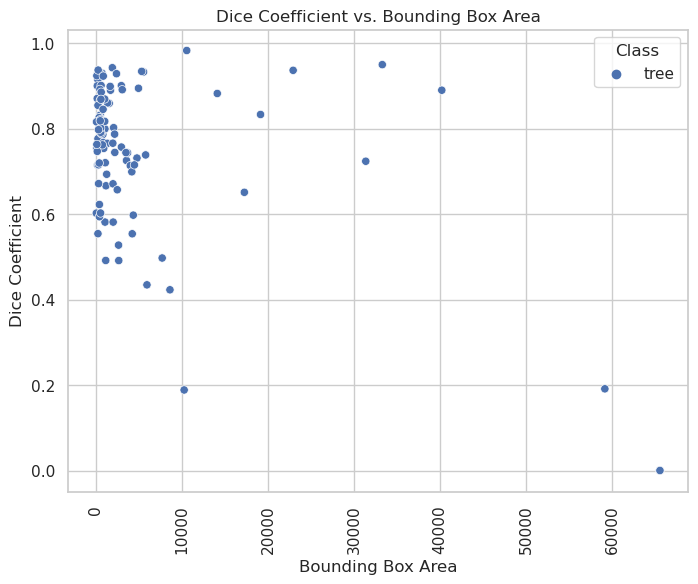

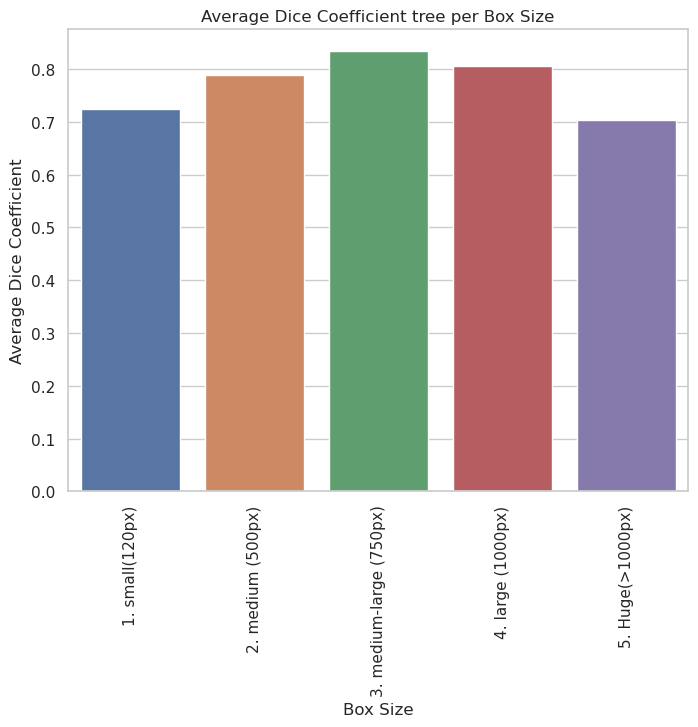

             dice       width      height       box_area
count  100.000000  100.000000  100.000000     100.000000
mean     0.773423  153.630000  154.610000   33447.595000
std      0.187613  105.636063  118.811211   44310.984829
min      0.000000    2.500000    2.000000       5.000000
25%      0.701473   83.750000   75.125000    6360.000000
50%      0.840022  131.000000  125.000000   16600.750000
75%      0.899554  208.250000  223.125000   44206.250000
max      0.966473  529.000000  668.000000  247828.000000


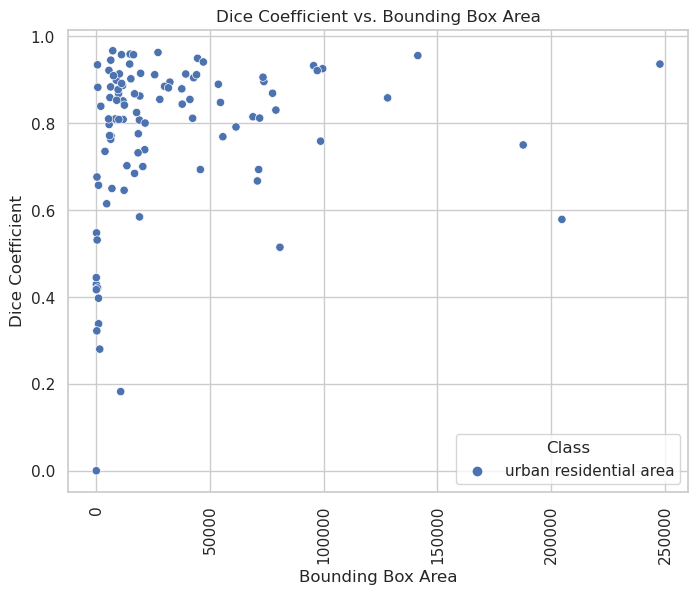

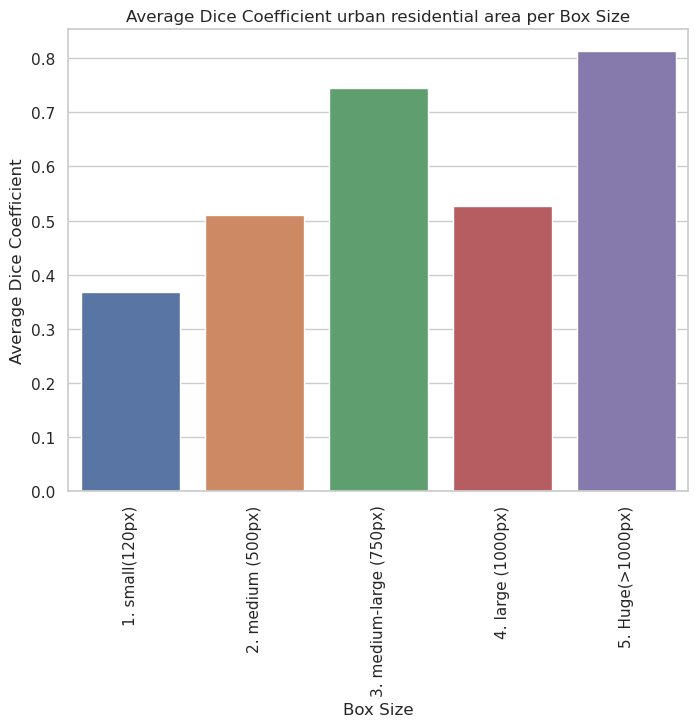

             dice       width      height     box_area
count  100.000000  100.000000  100.000000   100.000000
mean     0.725887   17.295000   15.845000   386.135000
std      0.155910   19.883892   11.193364   778.881041
min      0.181818    3.500000    3.000000    10.500000
25%      0.636190    8.000000    9.000000    67.000000
50%      0.739185   12.000000   14.000000   194.000000
75%      0.848485   19.250000   19.250000   285.250000
max      0.961877  177.000000   69.000000  5487.000000


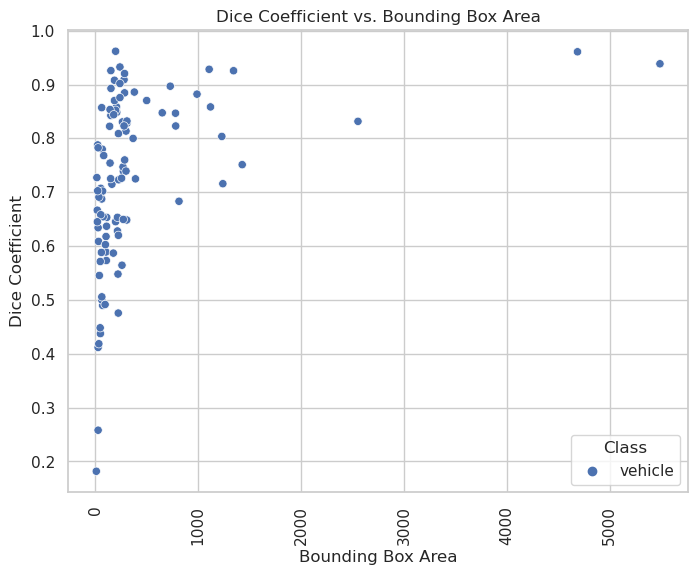

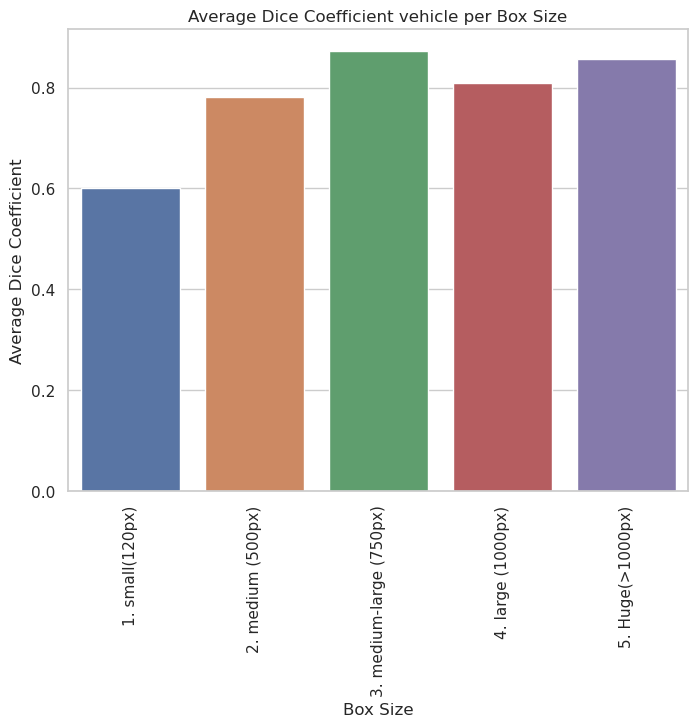

           dice        width       height       box_area
count  7.000000     7.000000     7.000000       7.000000
mean   0.424108   553.889510   407.382954  239568.147825
std    0.367152   466.866187   340.842708  203807.461760
min    0.000000    48.347044    38.091610    1841.616755
25%    0.119007    73.111803   158.539121   50741.810861
50%    0.355524   765.397931   450.503172  280576.000000
75%    0.765176   942.628032   509.217112  403502.841674
max    0.844868  1032.001923  1027.573427  486070.112948


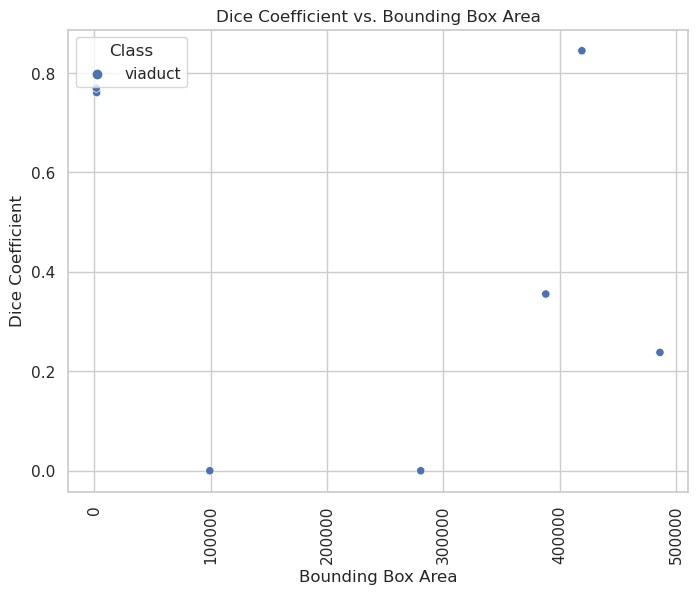

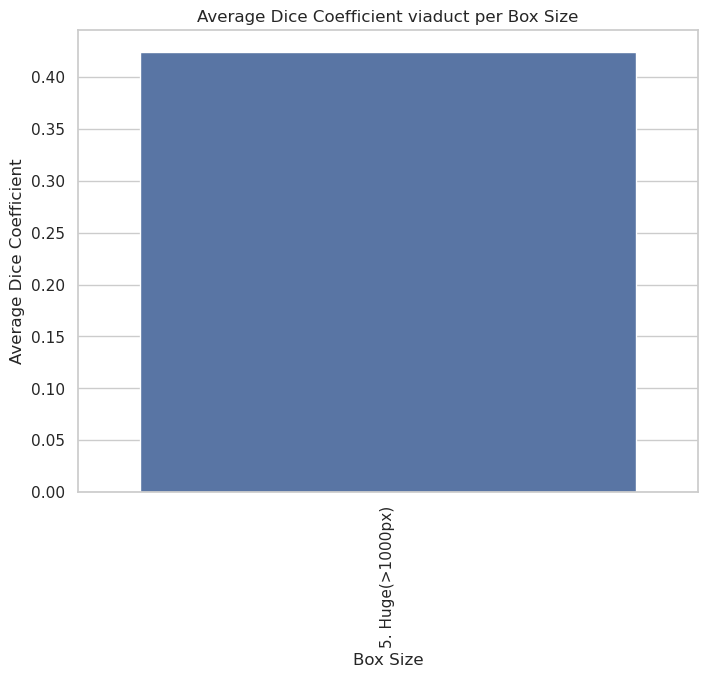

             dice        width       height      box_area
count  100.000000   100.000000   100.000000  1.000000e+02
mean     0.730093   149.810000   163.005000  4.810117e+04
std      0.234635   177.432941   193.225264  1.302174e+05
min      0.000000     2.000000     3.000000  1.000000e+01
25%      0.642264    48.000000    40.000000  1.430250e+03
50%      0.794167    89.000000    86.500000  6.315500e+03
75%      0.905384   196.500000   241.000000  4.860069e+04
max      0.982036  1023.500000  1023.500000  1.047552e+06


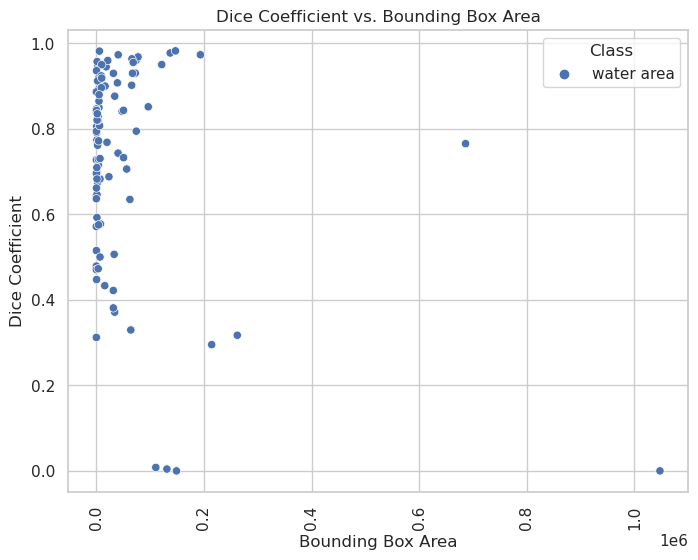

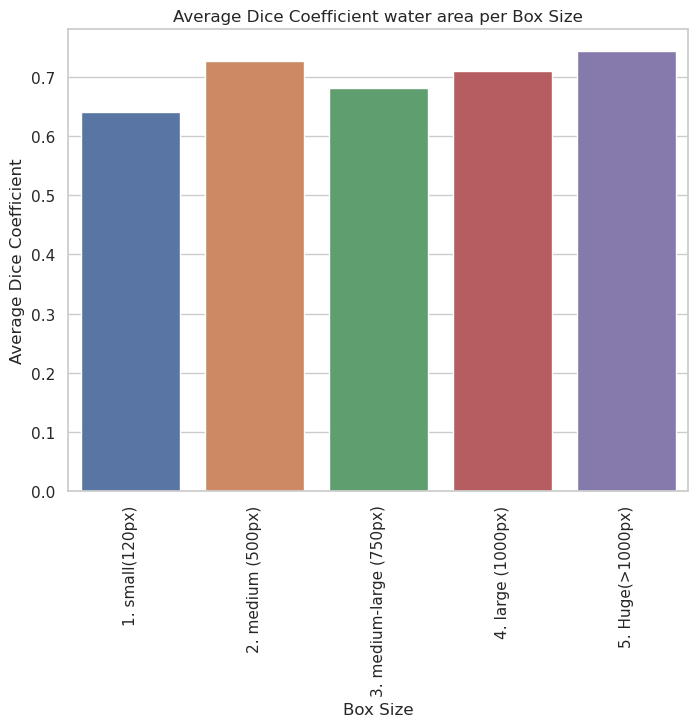

            dice       width      height       box_area
count  95.000000  100.000000  100.000000     100.000000
mean    0.639561  229.320000  192.385000   70145.042500
std     0.294768  193.756284  180.001092   92121.530318
min     0.000000    1.500000    3.000000       7.500000
25%     0.542453   52.750000   32.750000    1914.000000
50%     0.739197  172.750000  134.000000   21214.500000
75%     0.838689  440.750000  304.250000  104322.250000
max     0.988609  512.000000  512.000000  262144.000000


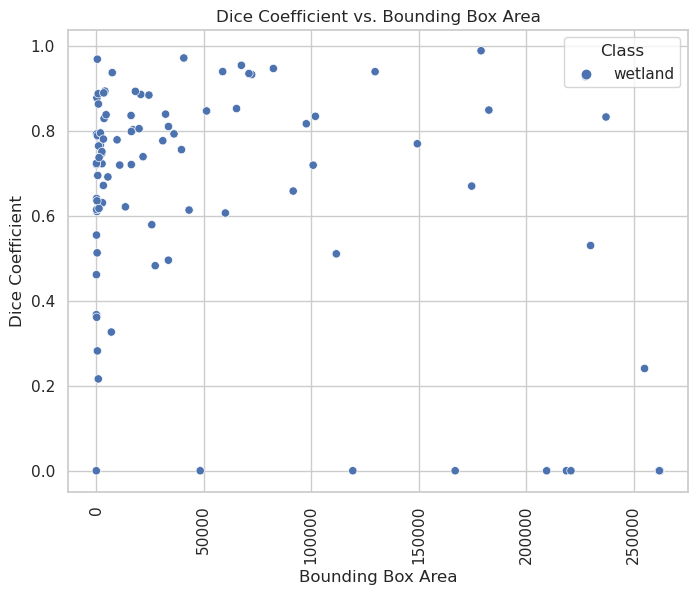

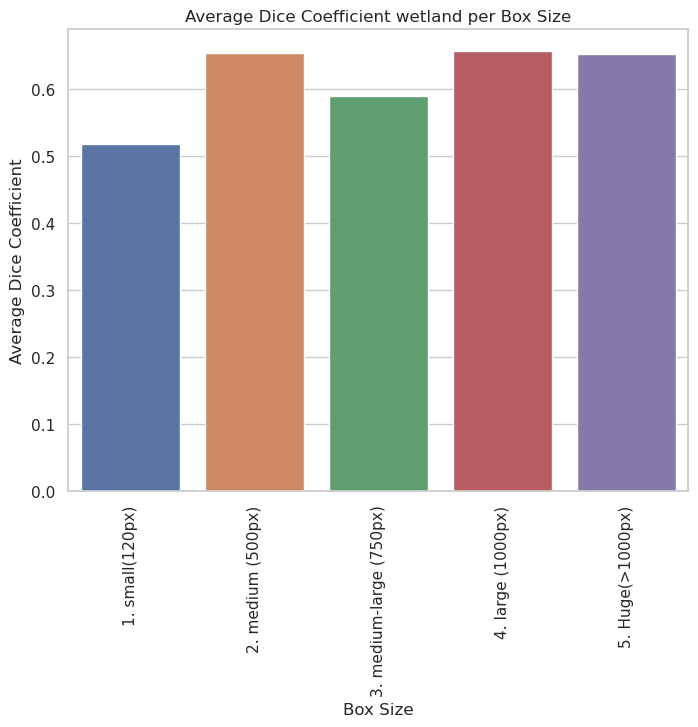

           dice      width      height     box_area
count  4.000000   4.000000    4.000000     4.000000
mean   0.587770  58.110164   79.636871  4751.609966
std    0.222269   9.729959   33.160897  2539.060972
min    0.303402  46.427638   46.427638  2495.871674
25%    0.464802  51.925647   64.754337  3261.650483
50%    0.638667  59.867217   73.306796  4096.095618
75%    0.761635  66.051734   88.189331  5586.055101
max    0.770344  66.278584  125.506256  8318.376953


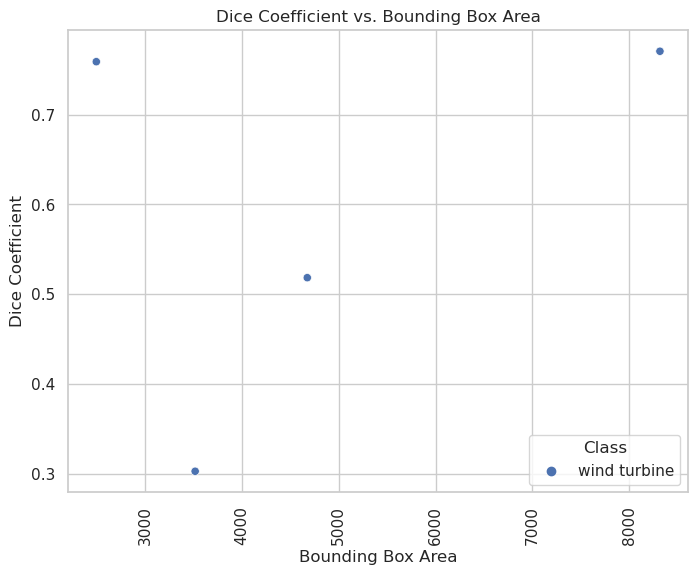

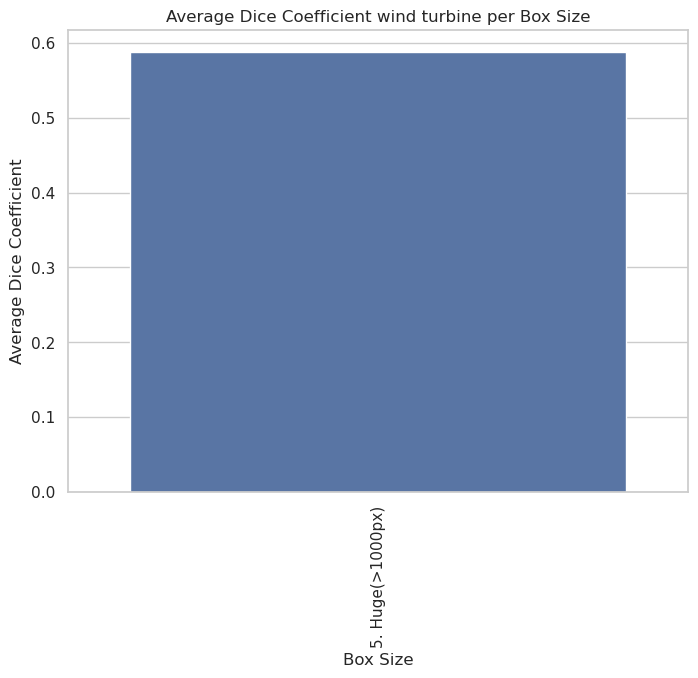

             dice       width      height      box_area
count  100.000000  100.000000  100.000000    100.000000
mean     0.603294   44.525000   37.750000   2633.325000
std      0.197746   46.778296   28.909079   4546.427333
min      0.000000    1.500000    2.000000      3.000000
25%      0.470234   13.000000   18.750000    241.750000
50%      0.633368   32.000000   31.500000   1095.750000
75%      0.765465   58.000000   48.500000   2618.500000
max      0.909789  220.000000  154.000000  25564.000000


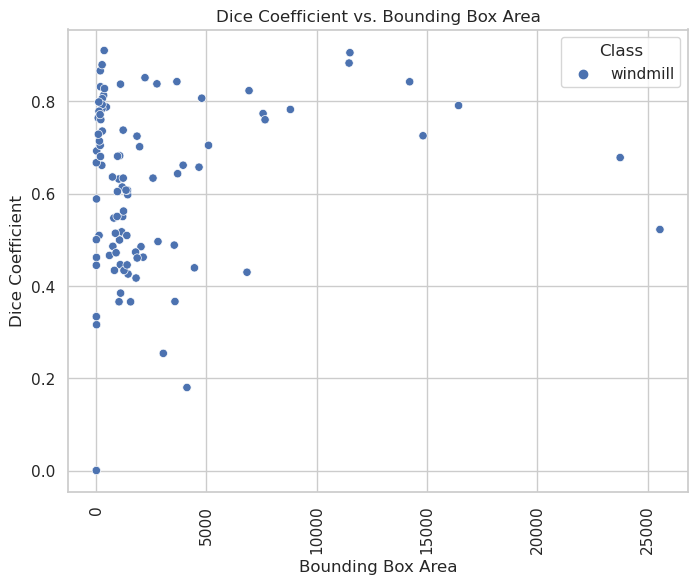

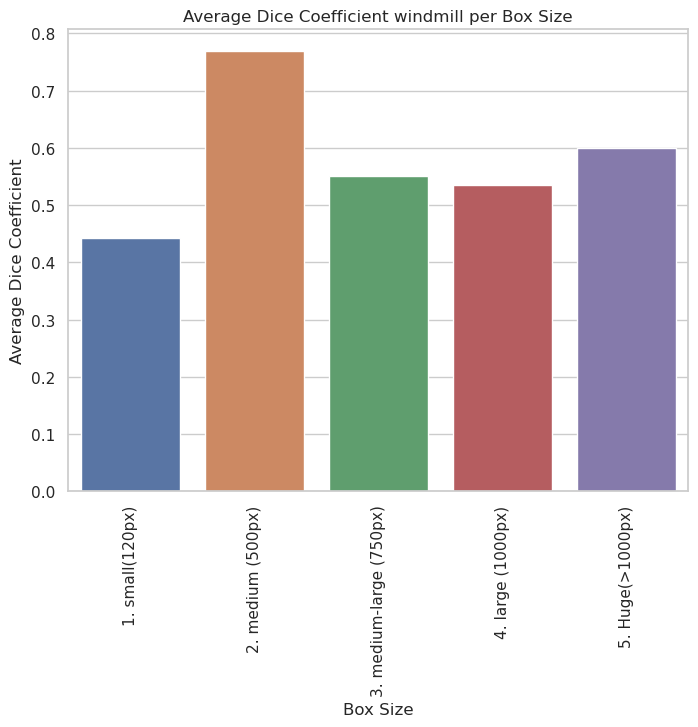

In [211]:
import ast

# Convert ROI from string to list of integers
try:
    df["roi"] = df["roi"].apply(lambda x: list(map(float, x)))
except:
    df["roi"] = df["roi"].apply(lambda x: list(map(float, ast.literal_eval(x))))

# Add width and height columns
df["width"] = df["roi"].apply(lambda x: x[2])
df["height"] = df["roi"].apply(lambda x: x[3])

# Add bounding box size category (small, medium, large)
def get_box_size_category(width, height):
    area = width * height
    if area < 120:  # Small box
        return "1. small(120px)"
    elif area < 500:  # Medium box
        return "2. medium (500px)"
    elif area < 750:  # Medium box
        return "3. medium-large (750px)"
    elif area < 1000:  # Medium box
        return "4. large (1000px)"
    else:  # Large box
        return "5. Huge(>1000px)"

df["box_size"] = df.apply(lambda row: get_box_size_category(row["width"], row["height"]), axis=1)

# Set the style for Seaborn
sns.set(style="whitegrid")


# 2. Dice Coefficient Distribution by Box Size
plt.figure(figsize=(8, 6))
sns.boxplot(x="box_size", y="dice", data=df)
plt.title("Dice Coefficient Distribution by Box Size")
plt.xlabel("Box Size")
plt.xticks(rotation=90)
plt.ylabel("Dice Coefficient")
plt.show()

# 3. Average Dice Coefficient per Box Size
avg_dice_per_box_size = df.groupby("box_size")["dice"].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x="box_size", y="dice", data=avg_dice_per_box_size)
plt.title("Average Dice Coefficient per Box Size")
plt.xlabel("Box Size")
plt.xticks(rotation=90)
plt.ylabel("Average Dice Coefficient")
plt.show()

# 4. Scatter Plot of Dice vs. Bounding Box Area

df["box_area"] = df["width"] * df["height"]
# removed_outliers = df[df['box_area'] <= 2000]
# df = removed_outliers

for class_name in list(df['class'].unique()):
    new_df = df.loc[df['class'] == class_name]
    print (new_df.describe())
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="box_area", y="dice", hue="class", data=new_df)
    plt.title("Dice Coefficient vs. Bounding Box Area")
    plt.xlabel("Bounding Box Area")
    plt.xticks(rotation=90)
    plt.ylabel("Dice Coefficient")
    plt.legend(title="Class")
    plt.show()
    
    
    
    avg_dice_per_box_size = new_df.groupby("box_size")["dice"].mean().reset_index()
    plt.figure(figsize=(8, 6))
    sns.barplot(x="box_size", y="dice", data=avg_dice_per_box_size)
    plt.title(f"Average Dice Coefficient {class_name} per Box Size")
    plt.xlabel("Box Size")
    plt.xticks(rotation=90)
    plt.ylabel("Average Dice Coefficient")
    plt.show()



In [227]:
df

image_path             class  \
0     /goss/Datasets/LoveDA/Val/Rural/images_png/318...  agriculture area   
1     /goss/Datasets/LoveDA/Val/Rural/images_png/303...  agriculture area   
2     /goss/Datasets/LoveDA/Val/Rural/images_png/329...  agriculture area   
3     /goss/Datasets/LoveDA/Val/Urban/images_png/368...  agriculture area   
4     /goss/Datasets/LoveDA/Val/Urban/images_png/391...  agriculture area   
...                                                 ...               ...   
5376  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5377  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5378  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5379  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   
5380  /goss/Datasets/SAMRS/SIOR/JPEGImages-trainval/...          windmill   

                              roi      dice  \
0      [560.5, 0.0, 395.5, 359.5]  0.731920   
1       [995.5, 0.0, 28.0, 337.5]  0.857986   
2     [193.5, 76.5, 264.0, 256.0]  0.863911   
3     [341.5, 51.5, 282.0, 143.0]  0.670620   
4       [0.0, 523.5, 24.5, 198.0]  0.418860   
...                           ...       ...   
5376   [316.5, 683.0, 10.0, 17.5]  0.770950   
5377    [95.5, 121.5, 41.0, 48.0]  0.701349   
5378  [610.5, 564.5, 145.0, 33.0]  0.806513   
5379   [327.5, 673.5, 25.0, 44.0]  0.836842   
5380   [380.5, 397.5, 12.0, 16.0]  0.680115   

                                                   path  width  height  \
0     /home/datadisk/pipe/results/sam_box/toy_set/se...  395.5   359.5   
1     /home/datadisk/pipe/results/sam_box/toy_set/se...   28.0   337.5   
2     /home/datadisk/pipe/results/sam_box/toy_set/se...  264.0   256.0   
3     /home/datadisk/pipe/results/sam_box/toy_set/se...  282.0   143.0   
4     /home/datadisk/pipe/results/sam_box/toy_set/se...   24.5   198.0   
...                                                 ...    ...     ...   
5376  /home/datadisk/pipe/results/sam_box/toy_set/se...   10.0    17.5   
5377  /home/datadisk/pipe/results/sam_box/toy_set/se...   41.0    48.0   
5378  /home/datadisk/pipe/results/sam_box/toy_set/se...  145.0    33.0   
5379  /home/datadisk/pipe/results/sam_box/toy_set/se...   25.0    44.0   
5380  /home/datadisk/pipe/results/sam_box/toy_set/se...   12.0    16.0   

               box_size   box_area  
0      5. Huge(>1000px)  142182.25  
1      5. Huge(>1000px)    9450.00  
2      5. Huge(>1000px)   67584.00  
3      5. Huge(>1000px)   40326.00  
4      5. Huge(>1000px)    4851.00  
...                 ...        ...  
5376  2. medium (500px)     175.00  
5377   5. Huge(>1000px)    1968.00  
5378   5. Huge(>1000px)    4785.00  
5379   5. Huge(>1000px)    1100.00  
5380  2. medium (500px)     192.00  

[5381 rows x 9 columns]

In [215]:
class_list_index = list(df['class'].unique())

agriculture area
DICE: 0.5714285714285714


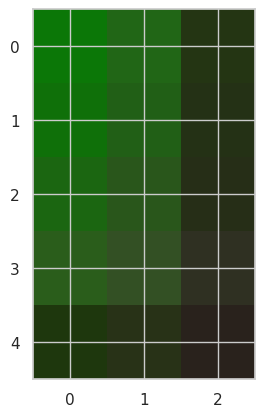

DICE: 0.0


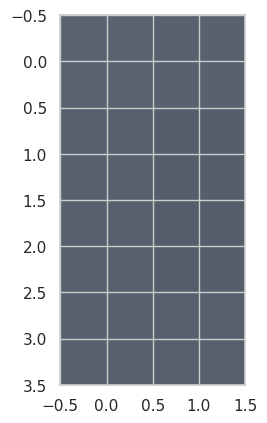

DICE: 0.6052631578947368


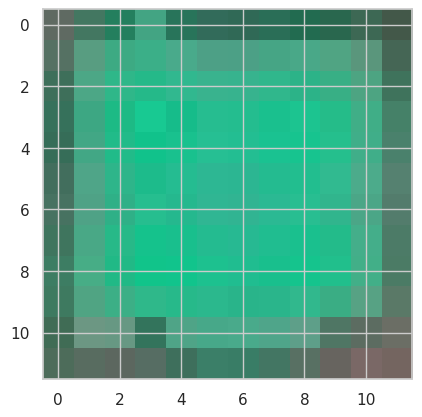

DICE: 0.7205673758865249


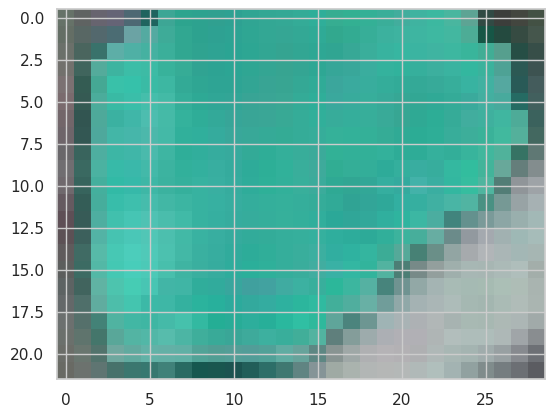

DICE: 0.8493150684931506


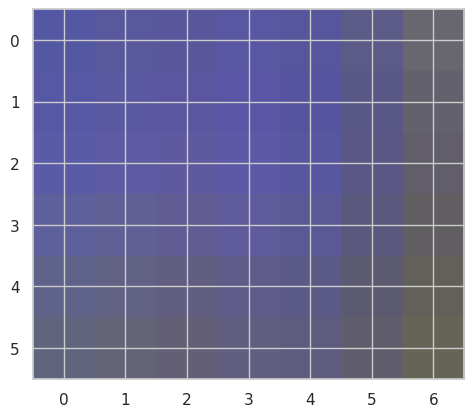

DICE: 0.0


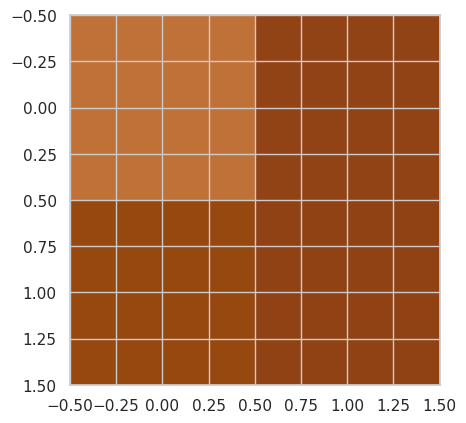

DICE: 0.6153846153846154


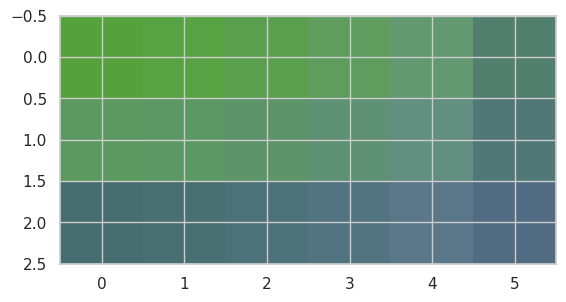

DICE: 0.6363636363636364


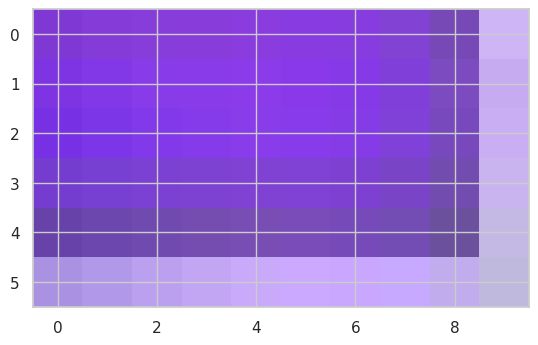

DICE: 0.4615384615384615


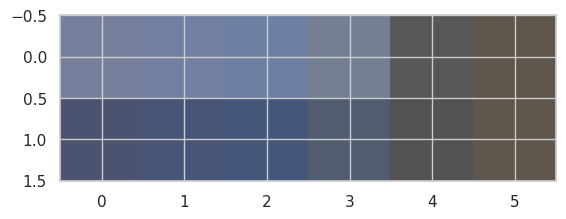

DICE: 0.7368421052631579


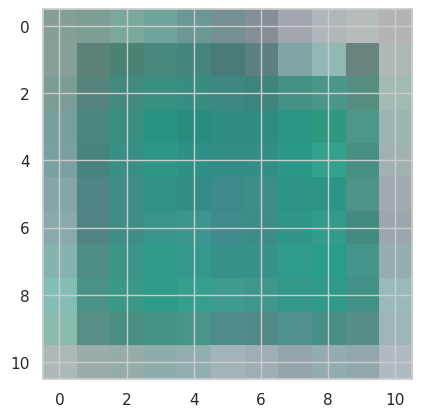

In [252]:
import matplotlib.image as img
# reading the image
class_idx = 0
class_df = df.loc[df['class'] == 'expressway service area']#class_list_index[class_idx]]
index = 20
print (class_list_index[class_idx])
for hel,dice in zip(list(class_df['path'])[index:index+10],list(class_df['dice'])[index:index+10]):
    testImage = img.imread(hel)
    
    print ('DICE:', dice)
    # displaying the image
    plt.imshow(testImage)
    plt.show()

MULTIPOLYGON (((1262 1229, 1262 1230, 1262 1231, 1262 1232, 1262 1233, 1262 1234, 1262 1235, 1262 1236, 1262 1237, 1262 1238, 1262 1239, 1262 1240, 1262 1241, 1261 1242, 1260 1243, 1259 1243, 1258 1244, 1257 1245, 1256 1246, 1255 1246, 1254 1247, 1253 1248, 1252 1249, 1251 1249, 1250 1250, 1251 1250, 1252 1250, 1253 1251, 1254 1251, 1255 1251, 1256 1252, 1257 1251, 1258 1251, 1259 1250, 1260 1250, 1261 1249, 1262 1250, 1262 1251, 1262 1252, 1263 1253, 1263 1254, 1263 1255, 1263 1256, 1264 1255, 1265 1255, 1266 1256, 1266 1257, 1267 1258, 1267 1259, 1268 1260, 1268 1261, 1268 1262, 1268 1263, 1267 1264, 1267 1265, 1266 1266, 1265 1267, 1266 1267, 1267 1267, 1268 1267, 1269 1267, 1270 1267, 1271 1267, 1272 1267, 1273 1267, 1274 1267, 1275 1267, 1276 1267, 1276 1266, 1276 1265, 1277 1264, 1277 1263, 1276 1263, 1275 1262, 1274 1261, 1273 1260, 1273 1259, 1272 1258, 1272 1257, 1271 1256, 1271 1255, 1272 1254, 1272 1253, 1272 1252, 1272 1251, 1273 1250, 1273 1249, 1273 1248, 1273 1247, 1274 

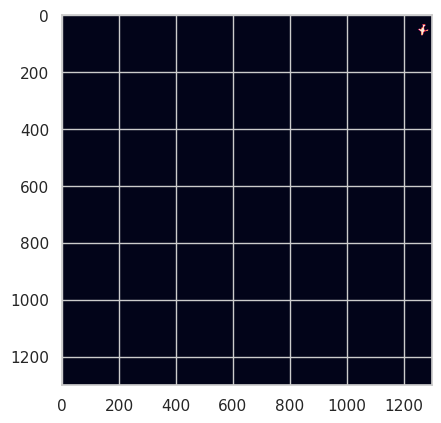

In [179]:
import base64
import pickle
import shapely
import rasterio
from rasterio.features import geometry_mask


def polygon2mask(multi_polygon,height,width):
    # 定义掩码的尺寸和变换
    height, width = height, width  # 掩码的高度和宽度
    transform = rasterio.transform.from_origin(0, height, 1, 1)  # 定义地理变换

    # 将 MultiPolygon 转换为掩码
    mask = geometry_mask(
        [multi_polygon],  # 需要转换的几何对象
        transform=transform,  # 地理变换
        out_shape=(height, width),  # 掩码的尺寸
        invert=True  # 如果为 True，则多边形内部为 True，外部为 False
    )
    return mask

def str2object(json_string):
    # 把str反序列化成对象
    pickled_bytes = base64.b64decode(json_string.encode("utf-8"))
    obj = pickle.loads(pickled_bytes)
    return obj

ooobj = (str2object('gASV+wgAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELWCAAAAQYAAAABAAAAAQMAAAABAAAAjAAAAAAAAAAAuJNAAAAAAAA0k0AAAAAAALiTQAAAAAAAOJNAAAAAAAC4k0AAAAAAADyTQAAAAAAAuJNAAAAAAABAk0AAAAAAALiTQAAAAAAARJNAAAAAAAC4k0AAAAAAAEiTQAAAAAAAuJNAAAAAAABMk0AAAAAAALiTQAAAAAAAUJNAAAAAAAC4k0AAAAAAAFSTQAAAAAAAuJNAAAAAAABYk0AAAAAAALiTQAAAAAAAXJNAAAAAAAC4k0AAAAAAAGCTQAAAAAAAuJNAAAAAAABkk0AAAAAAALSTQAAAAAAAaJNAAAAAAACwk0AAAAAAAGyTQAAAAAAArJNAAAAAAABsk0AAAAAAAKiTQAAAAAAAcJNAAAAAAACkk0AAAAAAAHSTQAAAAAAAoJNAAAAAAAB4k0AAAAAAAJyTQAAAAAAAeJNAAAAAAACYk0AAAAAAAHyTQAAAAAAAlJNAAAAAAACAk0AAAAAAAJCTQAAAAAAAhJNAAAAAAACMk0AAAAAAAISTQAAAAAAAiJNAAAAAAACIk0AAAAAAAIyTQAAAAAAAiJNAAAAAAACQk0AAAAAAAIiTQAAAAAAAlJNAAAAAAACMk0AAAAAAAJiTQAAAAAAAjJNAAAAAAACck0AAAAAAAIyTQAAAAAAAoJNAAAAAAACQk0AAAAAAAKSTQAAAAAAAjJNAAAAAAACok0AAAAAAAIyTQAAAAAAArJNAAAAAAACIk0AAAAAAALCTQAAAAAAAiJNAAAAAAAC0k0AAAAAAAISTQAAAAAAAuJNAAAAAAACIk0AAAAAAALiTQAAAAAAAjJNAAAAAAAC4k0AAAAAAAJCTQAAAAAAAvJNAAAAAAACUk0AAAAAAALyTQAAAAAAAmJNAAAAAAAC8k0AAAAAAAJyTQAAAAAAAvJNAAAAAAACgk0AAAAAAAMCTQAAAAAAAnJNAAAAAAADEk0AAAAAAAJyTQAAAAAAAyJNAAAAAAACgk0AAAAAAAMiTQAAAAAAApJNAAAAAAADMk0AAAAAAAKiTQAAAAAAAzJNAAAAAAACsk0AAAAAAANCTQAAAAAAAsJNAAAAAAADQk0AAAAAAALSTQAAAAAAA0JNAAAAAAAC4k0AAAAAAANCTQAAAAAAAvJNAAAAAAADMk0AAAAAAAMCTQAAAAAAAzJNAAAAAAADEk0AAAAAAAMiTQAAAAAAAyJNAAAAAAADEk0AAAAAAAMyTQAAAAAAAyJNAAAAAAADMk0AAAAAAAMyTQAAAAAAAzJNAAAAAAADQk0AAAAAAAMyTQAAAAAAA1JNAAAAAAADMk0AAAAAAANiTQAAAAAAAzJNAAAAAAADck0AAAAAAAMyTQAAAAAAA4JNAAAAAAADMk0AAAAAAAOSTQAAAAAAAzJNAAAAAAADok0AAAAAAAMyTQAAAAAAA7JNAAAAAAADMk0AAAAAAAPCTQAAAAAAAzJNAAAAAAADwk0AAAAAAAMiTQAAAAAAA8JNAAAAAAADEk0AAAAAAAPSTQAAAAAAAwJNAAAAAAAD0k0AAAAAAALyTQAAAAAAA8JNAAAAAAAC8k0AAAAAAAOyTQAAAAAAAuJNAAAAAAADok0AAAAAAALSTQAAAAAAA5JNAAAAAAACwk0AAAAAAAOSTQAAAAAAArJNAAAAAAADgk0AAAAAAAKiTQAAAAAAA4JNAAAAAAACkk0AAAAAAANyTQAAAAAAAoJNAAAAAAADck0AAAAAAAJyTQAAAAAAA4JNAAAAAAACYk0AAAAAAAOCTQAAAAAAAlJNAAAAAAADgk0AAAAAAAJCTQAAAAAAA4JNAAAAAAACMk0AAAAAAAOSTQAAAAAAAiJNAAAAAAADkk0AAAAAAAISTQAAAAAAA5JNAAAAAAACAk0AAAAAAAOSTQAAAAAAAfJNAAAAAAADok0AAAAAAAHiTQAAAAAAA7JNAAAAAAAB0k0AAAAAAAPCTQAAAAAAAdJNAAAAAAAD0k0AAAAAAAHiTQAAAAAAA+JNAAAAAAAB4k0AAAAAAAPyTQAAAAAAAfJNAAAAAAAAAlEAAAAAAAHyTQAAAAAAABJRAAAAAAAB8k0AAAAAAAAiUQAAAAAAAgJNAAAAAAAAMlEAAAAAAAICTQAAAAAAAEJRAAAAAAACEk0AAAAAAABSUQAAAAAAAhJNAAAAAAAAYlEAAAAAAAISTQAAAAAAAHJRAAAAAAACIk0AAAAAAAByUQAAAAAAAhJNAAAAAAAAYlEAAAAAAAICTQAAAAAAAGJRAAAAAAAB8k0AAAAAAABiUQAAAAAAAeJNAAAAAAAAUlEAAAAAAAHSTQAAAAAAAFJRAAAAAAABwk0AAAAAAABCUQAAAAAAAcJNAAAAAAAAMlEAAAAAAAHCTQAAAAAAACJRAAAAAAABwk0AAAAAAAASUQAAAAAAAcJNAAAAAAAAAlEAAAAAAAHCTQAAAAAAA/JNAAAAAAABwk0AAAAAAAPiTQAAAAAAAcJNAAAAAAAD0k0AAAAAAAGyTQAAAAAAA8JNAAAAAAABsk0AAAAAAAOyTQAAAAAAAbJNAAAAAAADok0AAAAAAAGiTQAAAAAAA5JNAAAAAAABok0AAAAAAAOCTQAAAAAAAaJNAAAAAAADck0AAAAAAAGSTQAAAAAAA3JNAAAAAAABgk0AAAAAAANiTQAAAAAAAXJNAAAAAAADYk0AAAAAAAFiTQAAAAAAA2JNAAAAAAABUk0AAAAAAANSTQAAAAAAAUJNAAAAAAADUk0AAAAAAAEyTQAAAAAAA1JNAAAAAAABIk0AAAAAAANCTQAAAAAAARJNAAAAAAADQk0AAAAAAAECTQAAAAAAA0JNAAAAAAAA8k0AAAAAAAMyTQAAAAAAAOJNAAAAAAADMk0AAAAAAADSTQAAAAAAAyJNAAAAAAAA0k0AAAAAAAMSTQAAAAAAANJNAAAAAAADAk0AAAAAAADSTQAAAAAAAvJNAAAAAAAA0k0AAAAAAALiTQAAAAAAANJNAlIWUUpQu'))
print (ooobj)

re_obj = polygon2mask(ooobj, 1300,1300)

plt.imshow(re_obj)
plt.show()

In [186]:

def multipolygon_to_box(obj):
    coords_str = str(obj).replace("MULTIPOLYGON (((", "").replace(")))", "")
    # Split into individual coordinate pairs
    coords_list = coords_str.split(", ")

    # Parse coordinates into a list of (x, y) tuples
    coords = [tuple(map(int, coord.split())) for coord in coords_list]

    # Find min and max x and y values
    min_x = min(coord[0] for coord in coords)
    max_x = max(coord[0] for coord in coords)
    min_y = min(coord[1] for coord in coords)
    max_y = max(coord[1] for coord in coords)

    # Define the bounding box
    bounding_box = [min_x,min_y,max_x,max_y]
    return bounding_box


#print (ooobj)
multipolygon_to_box(ooobj)

[1250, 1229, 1287, 1267]

In [183]:
str(ooobj)

'MULTIPOLYGON (((1262 1229, 1262 1230, 1262 1231, 1262 1232, 1262 1233, 1262 1234, 1262 1235, 1262 1236, 1262 1237, 1262 1238, 1262 1239, 1262 1240, 1262 1241, 1261 1242, 1260 1243, 1259 1243, 1258 1244, 1257 1245, 1256 1246, 1255 1246, 1254 1247, 1253 1248, 1252 1249, 1251 1249, 1250 1250, 1251 1250, 1252 1250, 1253 1251, 1254 1251, 1255 1251, 1256 1252, 1257 1251, 1258 1251, 1259 1250, 1260 1250, 1261 1249, 1262 1250, 1262 1251, 1262 1252, 1263 1253, 1263 1254, 1263 1255, 1263 1256, 1264 1255, 1265 1255, 1266 1256, 1266 1257, 1267 1258, 1267 1259, 1268 1260, 1268 1261, 1268 1262, 1268 1263, 1267 1264, 1267 1265, 1266 1266, 1265 1267, 1266 1267, 1267 1267, 1268 1267, 1269 1267, 1270 1267, 1271 1267, 1272 1267, 1273 1267, 1274 1267, 1275 1267, 1276 1267, 1276 1266, 1276 1265, 1277 1264, 1277 1263, 1276 1263, 1275 1262, 1274 1261, 1273 1260, 1273 1259, 1272 1258, 1272 1257, 1271 1256, 1271 1255, 1272 1254, 1272 1253, 1272 1252, 1272 1251, 1273 1250, 1273 1249, 1273 1248, 1273 1247, 1274

## 

In [5]:

df

Empty DataFrame
Columns: [image_path, class, roi, dice]
Index: []

In [323]:
def generate_segmentation_MAID():
    m_aid_dir = ""
    return

def read_detection_json(json_path):
    file_json = open(json_path)
    json_obj = json.load(file_json)
    data_json = json_obj['data']

    return data_json

# def create_sub_masks(mask_image, width, height):
#     # Initialize a dictionary of sub-masks indexed by RGB colors
#     sub_masks = {}
#     for x in range(width):
#         for y in range(height):
#             # Get the RGB values of the pixel
#             pixel = mask_image.getpixel((x, y))[:3]

#             # Check to see if we have created a sub-mask...
#             pixel_str = str(pixel)
#             sub_mask = sub_masks.get(pixel_str)
#             if sub_mask is None:
#                 # Create a sub-mask (one bit per pixel) and add to the dictionary
#                 # Note: we add 1 pixel of padding in each direction
#                 # because the contours module doesn"t handle cases
#                 # where pixels bleed to the edge of the image
#                 sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

#             # Set the pixel value to 1 (default is 0), accounting for padding
#             sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

#     return sub_masks

# def create_sub_masks(mask_array, width, height):
#     """
#     Create sub-masks from a numpy array representation of a mask.
    
#     Args:
#         mask_array (numpy.ndarray): The input mask as a NumPy array. Can be grayscale (2D) or RGB (3D).
#         width (int): The width of the mask.
#         height (int): The height of the mask.

#     Returns:
#         dict: A dictionary where keys are unique values (or RGB tuples for RGB images),
#               and values are binary NumPy arrays (sub-masks).
#     """
#     # Initialize a dictionary of sub-masks
#     sub_masks = {}
    
#     # Check if the mask is grayscale (2D) or RGB (3D)
#     if mask_array.ndim == 2:
#         # Grayscale: Extract unique values
#         unique_values = np.unique(mask_array)
#         for value in unique_values:
#             # Create a binary mask for the current value
#             color_mask = (mask_array == value)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(value)] = padded_mask.astype(np.uint8)
#     elif mask_array.ndim == 3:
#         # RGB: Extract unique RGB values
#         unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
#         for color in unique_colors:
#             # Create a binary mask for the current color
#             color_mask = np.all(mask_array == color, axis=-1)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(tuple(color))] = padded_mask.astype(np.uint8)
#     else:
#         raise ValueError("mask_array must be either 2D (grayscale) or 3D (RGB).")

#     return sub_masks

# def create_sub_mask_annotation(sub_mask):
#     # Find contours (boundary lines) around each sub-mask
#     # Note: there could be multiple contours if the object
#     # is partially occluded. (E.g. an elephant behind a tree)
#     contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

#     polygons = []
#     segmentations = []
#     number = 0
#     for contour in contours:
#         # Flip from (row, col) representation to (x, y)
#         # and subtract the padding pixel
#         for i in range(len(contour)):
#             row, col = contour[i]
#             contour[i] = (col - 1, row - 1)

#         # if number == 94:
#         #     test = 1
#         # Make a polygon and simplify it
#         poly = Polygon(contour)
#         poly = poly.simplify(1.0, preserve_topology=False)

#         if (poly.is_empty):
#             # Go to next iteration, dont save empty values in list
#             continue

#         polygons.append(poly)

#         if isinstance(poly, MultiPolygon):
#             # Handle multiple Polygons
#             # print("Result is a MultiPolygon:")
#             for i, sub_poly in enumerate(poly.geoms):
#                 segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
#                 segmentations.append(segmentation)
#         elif isinstance(poly, Polygon):
#             segmentation = np.array(poly.exterior.coords).ravel().tolist()
#             segmentations.append(segmentation)
#         # number = number + 1
#         # print(poly)
#         # print(number)

#     return polygons, segmentations

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x, y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
                # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

    return sub_masks


def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    number = 0
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # if number == 94:
        #     test = 1
        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)

        if (poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        if isinstance(poly, MultiPolygon):
            # Handle multiple Polygons
            # print("Result is a MultiPolygon:")
            for i, sub_poly in enumerate(poly.geoms):
                segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
                segmentations.append(segmentation)
        elif isinstance(poly, Polygon):
            segmentation = np.array(poly.exterior.coords).ravel().tolist()
            segmentations.append(segmentation)
        # number = number + 1
        # print(poly)
        # print(number)

    return polygons, segmentations


def generate_segmentation(args):
    
    #load models
    config_dir = "sam_road/config/"
    sam_road_checkpoint = "/home/datadisk/evaluation/models/SAM/SAM-road/"
    net_cityscale, config_cityscale = sam_road.load_sam_road(f"{config_dir}toponet_vitb_512_cityscale.yaml", f"{sam_road_checkpoint}cityscale_vitb_512_e10.ckpt", "cuda")
    net_spacenet, config_spacenet = sam_road.load_sam_road(f"{config_dir}toponet_vitb_256_spacenet.yaml", f"{sam_road_checkpoint}spacenet_vitb_256_e10.ckpt", "cuda")
    
    #index = 23
    data_jsons = read_detection_json(args.json_path)#[index]
    for data_json in data_jsons:
        ##NEED remove
        label = data_json[0]['object_annotations'][0]['label']
        ###########
        print (args.data_path)
        image_sources, main_images, gt_images, dice_lists, box_lists, roi_mask_lists, local_image_paths = sam.sementation_call(data_json, args.data_path)

        for index, json_obj in enumerate(data_json):
            image_name = json_obj['image'][0].split("/")[-1]
            cv2.imwrite('/home/kt/segment_tmp/'+label+'_'+image_name,main_images[index])


        #print(roi_mask_lists)
        for image_source, main_image, local_image_path in zip(image_sources,main_images, local_image_paths):

            image_sourceCopy = image_source.copy()
            original_height, original_width = image_source.shape[:2]
            if original_height <256 or original_width <256:
                new_height = 256
                new_width = 256

                # Resize the image
                resized_image = cv2.resize(image_source, (new_width, new_height), interpolation=cv2.INTER_AREA)
                image_source = resized_image
            print ("image shape: ",image_source.shape)



            plt.imshow(main_image)
            plt.show()

            ##ALL about road
            if (True):
                #road #1
                multi_scales = [1,2,3,4]
                scale_results = []
                scale_results_small = []
                for scale in multi_scales:
                    #print ("scale:", scale)
                    padded_image = resize_to_square_and_pad(image_source, scale)
                    plt.imshow(padded_image)
                    plt.show()
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, padded_image, config_spacenet)


                    overlay_image = sam_road.overlay_mask_on_image(padded_image, road_mask_spacenet, color=(0, 255, 0), alpha=0.2,th=15)

                    final_over = remove_padding_and_resize(overlay_image, image_source.shape)
                    final_scale_result = remove_padding_and_resize(road_mask_spacenet, image_source.shape)
                    scale_results.append(final_scale_result)

        #             plt.imshow(final_over)
        #             plt.show()

                    padded_image
                    img = cv2.resize(image_source,(1024,1024))
                    padded_image = resize_to_square_and_pad(img, scale)
                    mask, blended_image = road_ex.road_extraction_image(padded_image)

                    final_scale_result = remove_padding_and_resize(blended_image, img.shape)
                    scale_results_small.append(final_scale_result)
        #             plt.imshow(final_scale_result)
        #             plt.show()

                #combined_mask = combine_multiscale_results(scale_results, main_image.shape[:2], method='average')
                combined_mask = combine_multiscale_results(scale_results,multi_scales, main_image.shape[:2], method='average')
                combined_mask_small = combine_multiscale_results(scale_results_small,multi_scales, (1024,1024,3), method='average')
                overlay_image = sam_road.overlay_mask_on_image(main_image, combined_mask, color=(0, 255, 255), alpha=0.2,th=25)

                plt.imshow(overlay_image)
                plt.show()

                threshold = 25

                binary_mask = (combined_mask > threshold).astype(int)

        #         sub_mask = create_sub_masks(binary_mask,binary_mask.shape[1],binary_mask.shape[0])
        #         print (sub_mask)
                polygons, segmentations = create_sub_mask_annotation(binary_mask)

                #print (segmentations)
                
                print ('Sam TH:',threshold)
                plt.imshow(binary_mask)
                plt.show()      
                
                
                print ('sam')
                try:
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, image_sourceCopy, config_spacenet)
                    overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, road_mask_spacenet, color=(0, 255, 0), alpha=0.5,th=15)
                    plt.imshow(overlay_image)
                    plt.show()
                except:
                    print ('Error size need resize')
                
                print ('combined_mask_small combine')
                plt.imshow(combined_mask_small)
                plt.show()


                #road #2
                print ('combined_mask_small single')
                mask, blended_image = road_ex.road_extraction(local_image_path)
                plt.imshow(blended_image)
                plt.show()
                
                
                



parser = argparse.ArgumentParser()
parser.add_argument("--json-path", type=str, default="")
parser.add_argument("--data-path", type=str, default="/goss/Datasets/")
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/DOTA2.0/Annotations_train_hbb.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/million-AID/train_80_percent.json"]
sys.argv = ['test','--json-path', "/datadisk2/JSON/new_format/dataset2_JSON/iSAID/Annotations_val.json"]




#sys.argv = ['test','--json-path', 'hbb_detection_toyset.json']
#sys.argv = ['test','--json-path', "[PIX_SEG]BH-Pools_Watertanks_Datasets_Annotations_test.json"] 


args = parser.parse_args()

# Use the parsed arguments

generate_segmentation(args)
#read_detection_json(args)
print(f"json_path: {args.json_path}")

sam_road/config/toponet_vitb_512_cityscale.yaml
###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.

sam_road/config/toponet_vitb_256_spacenet.yaml
###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.q

KeyError: 0

In [ ]:


file_json = open("/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json")
json_obj = json.load(file_json)
data_json = json_obj['data']

data_json[0]

In [ ]:
def read_detection_json(json_path):
    file_json = open(json_path)
    json_obj = json.load(file_json)
    data_json = json_obj['data']
    return data_json

data_json = read_detection_json('hbb_detection_toyset.json')


In [8]:
data_json[13]

[{'image': ['xView/train_images/540.tif'],
  'size': [2978, 2771],
  'object_annotations': [{'bbox': [1194.0, -1556.0, 2211.0, 316.0],
    'bbox_type': 'hbb',
    'label': 'construction site',
    'description': '',
    'segmentation': [],
    'segmentation_mask': ''}]},
 {'image': ['xView/train_images/399.tif'],
  'size': [3742, 2830],
  'object_annotations': [{'bbox': [795.0, 1738.0, 1202.0, 1974.0],
    'bbox_type': 'hbb',
    'label': 'construction site',
    'description': '',
    'segmentation': [],
    'segmentation_mask': ''},
   {'bbox': [625.0, 2267.0, 1148.0, 2728.0],
    'bbox_type': 'hbb',
    'label': 'construction site',
    'description': '',
    'segmentation': [],
    'segmentation_mask': ''},
   {'bbox': [535.0, 1867.0, 947.0, 2242.0],
    'bbox_type': 'hbb',
    'label': 'construction site',
    'description': '',
    'segmentation': [],
    'segmentation_mask': ''},
   {'bbox': [964.0, 1972.0, 1450.0, 2248.0],
    'bbox_type': 'hbb',
    'label': 'construction site

In [30]:
data_json[41]

IndexError: list index out of range

# util
need to make .py for util later

In [286]:

# Function to display the segmentation mask overlay on an axis
def show_mask(mask, ax, random_color=False):
    if random_color:
        # Generate a random color with alpha transparency
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # Default color (light blue) with alpha transparency
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image

# Function to display key points on the image
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]  # Positive points
    neg_points = coords[labels == 0]  # Negative points
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

# Function to display a bounding box on the image
def show_box(box, ax):
    x0, y0 = box[0], box[1]  # Top-left corner
    w, h = box[2] - box[0], box[3] - box[1]  # Width and height
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def parse_coord(coord):
    # Remove any trailing parentheses or unwanted characters
    coord = coord.strip(")")
    coord = coord.strip("(")
    # Split into x and y components and convert to float
    return tuple(map(float, coord.split()))
    
# segmentation multipolygon to box
def multipolygon_to_box(obj):
                         
    coords_str = str(obj).replace("MULTIPOLYGON (((", "").replace(")))", "")
    # Split into individual coordinate pairs
    coords_list = coords_str.split(", ")

    # Parse coordinates into a list of (x, y) tuples
    #coords = [tuple(map(int, coord.split())) for coord in coords_list]
    #coords = [tuple(map(float, coord.split())) for coord in coords_list]
    coords = [parse_coord(coord) for coord in coords_list]
    
    # Find min and max x and y values
    min_x = min(coord[0] for coord in coords)
    max_x = max(coord[0] for coord in coords)
    min_y = min(coord[1] for coord in coords)
    max_y = max(coord[1] for coord in coords)

    # Define the bounding box
    bounding_box = [min_x,min_y,max_x,max_y]
    return bounding_box

# Converts a polygon to a binary mask
def polygon_to_mask(polygon, image_height, image_width):
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    rle = maskUtils.frPyObjects(polygon, image_height, image_width)  # Generate RLE mask
    mask = maskUtils.decode(rle)  # Decode RLE to binary mask
    return mask

def poly_sting_to_multi_polygon(poly_string):
    pickled_bytes = base64.b64decode(poly_string.encode("utf-8"))
    obj = pickle.loads(pickled_bytes)
    return obj

def multi_polygon_to_mask(multi_polygon,height,width):
    height, width = height, width  
    transform = rasterio.transform.from_origin(0, height, 1, 1)  

    mask = geometry_mask(
        [multi_polygon], 
        transform=transform, 
        out_shape=(height, width), 
        invert=True  
    )
    return mask

def str_poly_to_mask(polygon, image_height, image_width):
    multi_poly = poly_sting_to_multi_polygon(polygon)
    mask = multi_polygon_to_mask(multi_poly,image_height, image_width)
    mask = np.flip(mask, axis=0) ##dont know why the result from rasterio is not correct so need to flip
    return mask
    

# Calculates the Dice coefficient between two masks (a measure of similarity)
def dice_coefficient(mask1, mask2):
    mask1 = mask1 > 0  # Convert to binary
    mask2 = mask2 > 0
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    dice = 2. * intersection / (intersection + union)  # Avoid division by zero
    return dice

In [331]:
def open_image_with_nothing(file_path):
    extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif', '.webp']
    data_paths = ['/goss/Datasets/', '/home/oss/Datasets/']
    final_path = ''
    
    for ext in extensions:
        for data_path in data_paths:
            if file_path.endswith(ext):
                local_image_path = data_path+ file_path
            else:
                local_image_path = data_path+ file_path + ext
            final_path = local_image_path
            if os.path.exists(local_image_path):
                return local_image_path

def generate_segmentation(args):

    #create df
    # Define the column names
    columns = ["image_path", "class", "roi", "dice","path"]
    # Create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=columns)
    
    #load models
    config_dir = "sam_road/config/"
    sam_road_checkpoint = "/home/datadisk/evaluation/models/SAM/SAM-road/"
    net_cityscale, config_cityscale = sam_road.load_sam_road(f"{config_dir}toponet_vitb_512_cityscale.yaml", f"{sam_road_checkpoint}cityscale_vitb_512_e10.ckpt", "cuda")
    net_spacenet, config_spacenet = sam_road.load_sam_road(f"{config_dir}toponet_vitb_256_spacenet.yaml", f"{sam_road_checkpoint}spacenet_vitb_256_e10.ckpt", "cuda")
    
    index = 23
    data_jsons = read_detection_json(args.json_path)#[index:index+1]
    dataset_name = "toy_set"
    file_testing_name = args.json_path.split("/")[-1].split(".")[0]
    
    sam_box_dir = "/home/datadisk/pipe/results/sam_box/"+dataset_name+"/"+file_testing_name+"/"
    
    visualiztion = False
    
    dice_small_list = []
    dice_sam_list = []
    dice_sam_combine_list = []
    for data_json in data_jsons:
        ##NEED remove
        
        image_path = open_image_with_nothing(data_json['image'][0])
        image_source = cv2.imread(image_path)
        H, W, _ = image_source.shape
        
        
        mask_segment_list = []
        for raod_obj in data_json["object_annotations"]:
            print ("------------DATA-----------")
            print (raod_obj)
            
            segmentation_poly = raod_obj["segmentation"]
            if segmentation_poly!="":
                polygon = segmentation_poly
                if isinstance(polygon, list):
#                     print ('list poly')
                    binary_mask = polygon_to_mask(polygon, H, W)
                    
                elif type(polygon) == str:
#                     print ('str poly')
                    binary_mask = str_poly_to_mask(polygon, H, W)

                else:
                    print('print error nothing')
            mask_segment_list.append(binary_mask)
        
        #merge mask
        
        binary_mask = mask_segment_list[0]
        for segment_mask in mask_segment_list:
            binary_mask = np.logical_or(binary_mask, segment_mask)
        
        
        if visualiztion:
            print ("-------MASK----------")
            plt.imshow(binary_mask)
            plt.show()
        if (True):
            #road #1
            multi_scales = [1,2,3,4]
            scale_results = []
            scale_results_small = []
            scale_result_mask_small = []
            for scale in multi_scales:
                #print ("scale:", scale)
                padded_image = resize_to_square_and_pad(image_source, scale)
#                 plt.imshow(padded_image)
#                 plt.show()
                pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, padded_image, config_spacenet)


                overlay_image = sam_road.overlay_mask_on_image(padded_image, road_mask_spacenet, color=(0, 255, 0), alpha=0.2,th=15)

                final_over = remove_padding_and_resize(overlay_image, image_source.shape)
                final_scale_result = remove_padding_and_resize(road_mask_spacenet, image_source.shape)
                scale_results.append(final_scale_result)

    #             plt.imshow(final_over)
    #             plt.show()

                padded_image
                img = cv2.resize(image_source,(1024,1024))
                padded_image = resize_to_square_and_pad(img, scale)
                mask, blended_image = road_ex.road_extraction_image(padded_image)

                final_scale_result = remove_padding_and_resize(blended_image, img.shape)
                #small_scale_result = remove_padding_and_resize(mask, image_source.shape)
                scale_results_small.append(final_scale_result)
                #scale_result_mask_small.append(small_scale_result)
    #             plt.imshow(final_scale_result)
    #             plt.show()

            #combined_mask = combine_multiscale_results(scale_results, main_image.shape[:2], method='average')

            image_sourceCopy = image_source.copy()
            combined_mask = combine_multiscale_results(scale_results,multi_scales, image_sourceCopy.shape[:2], method='average')
            combined_real_small = combine_multiscale_results(scale_results_small,multi_scales, (1024,1024,3), method='average')
            #combined_mask_small = combine_multiscale_results(scale_result_mask_small,multi_scales, (1024,1024,3), method='average')
            overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, combined_mask, color=(0, 255, 255), alpha=0.2,th=25)
           
            if visualiztion:
            
                print ("-------Original----------")
                plt.imshow(image_source)
                plt.show()

                plt.imshow(overlay_image)
                plt.show()

            threshold = 25
            sam_combine_mask = (combined_mask > threshold).astype(int)
            if visualiztion:
                print ('Sam(combine) TH:',threshold)
            
            dice = dice_coefficient(sam_combine_mask, binary_mask)
            dice_sam_combine_list.append(dice)
            if visualiztion:
                print ('DICE:',dice)
                plt.imshow(sam_combine_mask)
                plt.show()      

            image_sourceCopy = image_source.copy()
            if visualiztion:
                print ('SAM(single) TH: 15')
            try:
                pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, image_sourceCopy, config_spacenet)
                overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, road_mask_spacenet, color=(0, 255, 0), alpha=0.5,th=15)
                dice = dice_coefficient(road_mask_spacenet, binary_mask)
                dice_sam_list.append(dice)
                if visualiztion:
                    print ('DICE:',dice)

                    plt.imshow(overlay_image)
                    plt.show()
            except:
                print ('Error size need resize')

#             print ('small model (combine)')
#             dice = dice_coefficient(combined_mask_small, binary_mask)
#             print ('DICE:',dice)
#             plt.imshow(combined_mask_small)
#             plt.show()


            #road #2
            
            print ('small model (single)')
            mask, blended_image = road_ex.road_extraction(image_path)
            dice = dice_coefficient(mask, binary_mask)
            dice_small_list.append(dice)
            if visualiztion:
                print ('DICE:',dice)
                plt.imshow(blended_image)
                plt.show()
    
    #df.to_csv(sam_box_dir+'output.csv', index=False)
    return dice_small_list, dice_sam_list, dice_sam_combine_list

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--json-path", type=str, default="")
parser.add_argument("--data-path", type=str, default="/goss/Datasets/")
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/DOTA2.0/Annotations_train_hbb.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/million-AID/train_80_percent.json"]
sys.argv = ['test','--json-path', "/datadisk/pipe/data_engine/data/LoveDA_road.json"]




#sys.argv = ['test','--json-path', 'hbb_detection_toyset.json']
#sys.argv = ['test','--json-path', "[PIX_SEG]BH-Pools_Watertanks_Datasets_Annotations_test.json"] 


args = parser.parse_args()

# Use the parsed arguments

dice_small_list, dice_sam_list, dice_sam_combine_list = generate_segmentation(args)

sam_road/config/toponet_vitb_512_cityscale.yaml
###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.

sam_road/config/toponet_vitb_256_spacenet.yaml
###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.q

------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVmwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJ2AgAAAQYAAAABAAAAAQMAAAABAAAAJgAAAAAAAAAA8HdAAAAAAAAEiUAAAAAAAHh3QAAAAAAAoIhAAAAAAABweEAAAAAAAHyIQAAAAAAACHpAAAAAAABgh0AAAAAAAFh6QAAAAAAAIIZAAAAAAAC4ekAAAAAAAHCCQAAAAAAAGHtAAAAAAABAgUAAAAAAADh8QAAAAAAAIH9AAAAAAACofUAAAAAAAFB7QAAAAAAAuH1AAAAAAADAekAAAAAAAMh9QAAAAAAAsHlAAAAAAABQfUAAAAAAAOh4QAAAAAAAKHpAAAAAAADAd0AAAAAAAHB6QAAAAAAAKHdAAAAAAABQfEAAAAAAALh3QAAAAAAAsHxAAAAAAAC4d0AAAAAAALh9QAAAAAAAYHdAAAAAAADYfEAAAAAAANBzQAAAAAAAOHtAAAAAAAAgaEAAAAAAACh7QAAAAAAAgFRAAAAAAABIe0AAAAAAAAAwQAAAAAAAsHtAAAAAAAAAAAAAAAAAAGB8QAAAAAAAAAAAAAAAAAD4e0AAAAAAAAA0QAAAAAAAGHxAAAAAAABgZUAAAAAAAHh9QAAAAAAAsHJAAAAAAAB4fkAAAAAAADB3QAAAAAAAiH5AAAAAAACgeUAAAAAAAFh+QAAAAAAA8HpAAAAAAABYfUAAAAAAAJB9QAAAAAAAmHxAAAAAAAAAgEAAAAAAALh7QAAAAAAAIIFAAAAAAABYe0AAAAAAAFCCQAAAAAAAGHtAAAAAAADYhEAAAAAAABh7QAAAAAAASIZAAAAAAACYekAAAAAAAICHQAAAAAAASHlAAAAAAACQiEAAAAAAAPB3QAAAAAAABIlAlIWUUpQu', 'label': 'road', '

(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVawEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJGAQAAAQYAAAABAAAAAQMAAAABAAAAEwAAAAAAAAAA0IFAAAAAAAD8j0AAAAAAAMyAQAAAAAAA+I9AAAAAAACsgUAAAAAAABCOQAAAAAAAlIFAAAAAAADQhkAAAAAAABSCQAAAAAAASIRAAAAAAACcgkAAAAAAABCCQAAAAAAAnIJA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwMAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWAwAAAQYAAAABAAAAAQMAAAABAAAAMAAAAAAAAAAAYHNAAAAAAAD8j0AAAAAAAMhyQAAAAAAA+I9AAAAAAAAwbkAAAAAAAMiJQAAAAAAAcGtAAAAAAAAwiEAAAAAAANBoQAAAAAAAEIdAAAAAAADgX0AAAAAAAGiBQAAAAAAAAEVAAAAAAABsgkAAAAAAAABAQAAAAAAAfIJAAAAAAAAAAAAAAAAAAOCCQAAAAAAAAAAAAAAAAACMgkAAAAAAAOBeQAAAAAAAMIFAAAAAAABAT0AAAAAAAMB4QAAAAAAAAAAAAAAAAABQekAAAAAAAAAAAAAAAAAAaHlAAAAAAABATEAAAAAAAPB3QAAAAAAAACFAAAAAAABgcEAAAAAAAAASQAAAAAAAYG9AAAAAAAAAFkAAAAAAACBvQAAAAAAAAAAAAAAAAACAbUAAAAAAAAAAAAAAAAAAkGhAAAAAAAAABEAAAAAAAKBqQAAAAAAAwFBAAAAAAACod0AAAAAAAJBwQAAAAAAAiHJAAAAAAAC4cEAAAAAAALByQAAAAAAA2HBAAAAAAAAwc0AAAAAAAMBwQAAAAAAAaHNAAAAAAACAU0AAAAAAAEh4QAAAAAAAgFJAAAAAAABoeEAAAAAAACBSQAAAAAAAoHhAAAAAAADgYEAAAAAAAFSBQAAAAAAAwGpAAAAAAABMgEAAAAAAAOBtQAAAAAAABIBAAAAAAAAAb0AAAAAAALh/QAAAAAAAgG9AAAAAAACof0AAAAAAALBvQAAAAAAA0H9AAAAAAADQb0AAAAAAADCAQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVWwMAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEI2AwAAAQYAAAABAAAAAQMAAAABAAAAMgAAAAAAAAAAoHZA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVSwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpST

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEPmAQYAAAABAAAAAQMAAAABAAAADQAAAAAAAAAAAPA/AAAAAABMhUAAAAAAAAAAAAAAAAAASIVAAAAAAAAAAAAAAAAAAPiEQAAAAAAAABRAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELmAQAAAQYAAAABAAAAAQMAAAABAAAAHQAAAAAAAAAAAGFAAAAAAAD8j0AAAAAAACBcQAAAAAAA+I9AAAAAAADgW0AAAAAAABCOQAAAAAAA8GRAAAAAAADggkAAAAAAAAAAQAAAAAAAHIJAAAAAAAAAAAAAAAAAABCCQAAAAAAAAAAAAAAAAAAwgUAAAAAAAKBhQAAAAAAAvIFAAAAAAACgYkAAAAAAALyBQAAAAAAAcGVAAAAAAABYgUAAAAAAAJBnQAAAAAAAEHtAAAAAAAAYcEAAAAAAAAAAQAAAAAAAMHBAAAAAAAAAAAAAAAAAALBxQAAAAAAAAAAAAAAAAAC4cUAAAAAAAAAIQAAAAAAAGHFAAAAAAACATUAAAAAAAFBpQAAAAAAAKIFAAAAAAABwaUAAAAAAAGCBQAAAAAAAgGtAAAAAAAAEgkAAAAAAACB9QAAAAAAA3IJAAAAAAACAjEAAAAAAAOyEQAAAAAAA+I9AAAAAAABMhUAAAAAAAPyPQAAAAAAAIIZAAAAAAACwi0AAAAAAAKyFQAAAAAAAgGdAAAAAAAD0gkAAAAAAAHBlQAAAAAAAWIZAAAAAAAAQYkAAAAAAALiKQAAAAAAAcGFAAAAAAAB4jkAAAAAAAABhQAAAAAAA/I9AlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2730.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVqwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKGAgAAAQYAAAABAAAAAQMAAAABAAAAJwAAAAAAAAAASINAAAAAAAAkjUAAAAAAABSDQAAAAAAAII1AAAAAAAAkg0AAAAAAAECIQAAAAAAA9IJAAAAAAABQhUAAAAAAAOyCQAAAAAAACIVAAAAAAABMgkAAAAAAAECDQAAAAAAAVIJAAAAAAAB4gkAAAAAAAISCQAAAAAAAEIJAAAAAAAB8g0AAAAAAAKB9QAAAAAAAPIRAAAAAAACgeUAAAAAAAGyEQAAAAAAAAHlAAAAAAABUhUAAAAAAAMB0QAAAAAAATIVAAAAAAACQdEAAAAAAAOSFQAAAAAAAwHFAAAAAAAAEhkAAAAAAAGBxQAAAAAAAvIVAAAAAAAAAAAAAAAAAABiGQAAAAAAAAAAAAAAAAAAkhkAAAAAAAAAoQAAAAAAAXIZAAAAAAADAa0AAAAAAAHiMQAAAAAAAqHFAAAAAAACgjkAAAAAAAIh0QAAAAAAAkI9AAAAAAAAIdkAAAAAAAOCPQAAAAAAAaHZAAAAAAAD8j0AAAAAAAKB2QAAAAAAA/I9AAAAAAACAd0AAAAAAAGiOQAAAAAAA+HRAAAAAAABwjEAAAAAAADhyQAAAAAAAsIZAAAAAAAAwbUAAAAAAAGyGQAAAAAAAAG1AAAAAAABEhkAAAAAAACBxQAAAAAAAfINAAAAAAADAf0AAAAAAALyCQAAAAAAAOIJAAAAAAACUgkAAAAAAABCDQAAAAAAAlIJAAAAAAAAog0AAAAAAAASDQAAAAAAAOIRAAAAAAABMg0AAAAAAAFiFQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVyAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOmAQYAAAABAAAAAQMAAAABAAAACQAAAAAAAAAAAFNAAAAAAADAREAAAAAAAKBSQAAAAAAAgERAAAAAAADgUkAAAAAAAABCQAAAAAAAQFNAAAAAAADAQEAAAAAAAABUQAAAAAAAQEBAAAAAAAAgbkAAAAAAAAAAAAAAAAAAOHJAAAAAAAAAAAAAAAAAACBpQAAAAAAAgDNAAAAAAAAAU0AAAAAAAMBEQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3280.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEP2AQYAAAABAAAAAQMAAAABAAAADgAAAAAAAAAAAC5AAAAAAAAofEAAAAAAAAAAAAAAAAAAIHxAAAAAAAAAAAAAAAAAANh6QAAAAAAAsHFAAAAAAADoeUAAAAAAABB9QAAAAAAA6HlAAAAAAAAgg0AAAAAAAMhzQAAAAAAAnIVAAAAAAAAAa0AAAAAAANSFQAAAAAAAAAAAAAAAAADEhkAAAAAAAAAAAAAAAAAAnIZAAAAAAABga0AAAAAAALCDQAAAAAAAGHVAAAAAAAAgfEAAAAAAAOh7QAAAAAAAgGZAAAAAAACoe0AAAAAAAAAuQAAAAAAAKHxAlIWUUpQu', 'labe

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEP2AQYAAAABAAAAAQMAAAABAAAADgAAAAAAAAAAAAAAAAAAAAAIdkAAAAAAAAAAAAAAAAAAQHRAAAAAAACAMUAAAAAAABBxQAAAAAAAQERAAAAAAADgbEAAAAAAAOBWQAAAAAAAwGJAAAAAAABgX0AAAAAAAABWQAAAAAAAUGRAAAAAAACAQUAAAAAAAOBnQAAAAAAAAAAAAAAAAABgaUAAAAAAAAAAAAAAAAAAcGlAAAAAAAAA8D8AAAAAABBpQAAAAAAAABRAAAAAAADgX0AAAAAAAMBYQAAAAAAAQEBAAAAAAACwcEAAAAAAAAAAAAAAAAAACHZAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3087.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVywEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKmAQAAAQYAAAABAAAAAQMAAAABAAAAGQAAAAAAAAAAAAAAAAAAAADwZUAAAAAAAAAAAAAAAAAAYGJAAAAAAAAA8D8AAAAAADBiQAAAAAAAAEZAAAAAAACgXkAAAAAAAIBcQAAAAAAAYFhAAAAAAAAAcEAAAAAAAKBTQAAAAAAAIHxAAAAAAADAQkAAAAAAAKiBQAAAAAAAgDxAAAAAAACIhkAAAAAAAIA8QAAAAAAAEIlAAAAAAADAQkAAAAAAAACPQAAAAAAAgDRAAAAAAADIj0AAAAAAAIAwQAAAAAAA/I9AAAAAAAAAMUAAAAAAAPyPQAAAAAAAAERAAAAAAABgj0AAAAAAAMBFQAAAAAAAMItAAAAAAABASkAAAAAAAOCIQAAAAAAAQEpAAAAAAAB4hkAAAAAAAMBJQAAAAAAA2INAAAAAAABARUAAAAAAAGB9QAAAAAAAwEtAAAAAAAAgd0AAAAAAAKBUQAAAAAAA4G1AAAAAAABgWEAAAAAAAABgQAAAAAAAoF1AAAAAAACATUAAAAAAAPBhQAAAAAAAAAAAAAAAAADwZUCUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2699.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVawEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJGAQAAAQYAAAABAAAAAQMAAAABAAAAEwAAAAAAAAAAcHpAAAAAAAD8j0AAAAAAALB5QAAAAAAA/I9AAAAAAABgakAAAAAAAMyLQAAAAAAAAGZAAAAAAAA8i0AAAAAAAMBjQAAAAAAA1IpAAAAAAABQYEAAAAAAAMiJQAAAAAAAgEFAAAAAAADEhkAAAAAAAAAAAAAAAAAA6IVAAAAAAAAAAAAAAAAAAIiFQAAAAAAAAPA/AAAAAACEhUAAAAAAAIBIQAAAAAAArIZAAAAAAADQYkAAAAAAACCKQAAAAAAAgGRAAAAAAACMikAAAAAAAOBnQAAAAAAAPItAAAAAAABgbUAAAAAAAPyLQAAAAAAAgG5AAAAAAAAUjEAAAAAAANB0QAAAAAAAvI1AAAAAAABgd0AAAAAAAPyOQAAAAAAAcHpAAAAAAAD8j0CUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3489.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVqwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKGAQAAAQYAAAABAAAAAQMAAAABAAAAFwAAAAAAAAAAAAAAAAAAAADEhEAAAAAAAAAAAAAAAAAAsINAAAAAAAAA+D8AAAAAAJiDQAAAAAAAACtAAAAAAAA4g0AAAAAAAABQQAAAAAAAXIFAAAAAAAAAUkAAAAAAAISBQAAAAAAAYFJAAAAAAAB4gUAAAAAAANBgQAAAAAAAAH1AAAAAAAAQYEAAAAAAAKB8QAAAAAAA8GRAAAAAAADgdkAAAAAAAJBlQAAAAAAAgHZAAAAAAABwZUAAAAAAAFB2QAAAAAAAsGVAAAAAAAAAdkAAAAAAANBuQAAAAAAAwGZAAAAAAADoc0AAAAAAAAAAAAAAAAAAYHVAAAAAAAAAAAAAAAAAAGh1QAAAAAAAAABAAAAAAAAwZkAAAAAAAIB5QAAAAAAAYFpAAAAAAABYgUAAAAAAAIBBQAAAAAAApINAAAAAAAAAL0AAAAAAAPiDQAAAAAAAAC9AAAAAAABIhEAAAAAAAAAAAAAAAAAAxIRAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3039.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVawEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJGAQAAAQYAAAABAAAAAQMAAAABAAAAEwAAAAAAAAAA+I9A

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWAQAAAQYAAAABAAAAAQMAAAABAAAAEAAAAAAAAAAAaIdAAAAAAAD8j0AAAAAAAFCFQAAAAAAA/I9AAAAAAAAghUAAAAAAAOSPQAAAAAAAwIBAAAAAAAC8jEAAAAAAACB2QAAAAAAA7IdAAAAAAADgaEAAAAAAAISDQAAAAAAAAEVAAAAAAAC4fkAAAAAAAADwPwAAAAAAWHxAAAAAAAAAAAAAAAAAAEB8QAAAAAAAAAAAAAAAAAAAekAAAAAAAAAxQAAAAAAAGHtAAAAAAADgakAAAAAAAMSCQAAAAAAAkHhAAAAAAADkh0AAAAAAAEiBQAAAAAAAHIxAAAAAAACghEAAAAAAAJyOQAAAAAAAaIdAAAAAAAD8j0CUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3227.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scal

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV2AAAAAAAAACMCnNoYXBlbHkuaW+U

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJmAQAAAQYAAAABAAAAAQMAAAABAAAAFQAAAAAAAAAAQGtAAAAAAACgXUAAAAAAAABmQAAAAAAAoFdAAAAAAADAYkAAAAAAAKBRQAAAAAAAQFlAAAAAAADASkAAAAAAAABNQAAAAAAAQEVAAAAAAAAAMkAAAAAAAIA8QAAAAAAAAAAAAAAAAAAAIkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHEAAAAAAAAAAAAAAAAAAAD5AAAAAAACANkAAAAAAAABLQAAAAAAAgDlAAAAAAADAY0AAAAAAACBQQAAAAAAAQGdAAAAAAADgVUAAAAAAAOBqQAAAAAAAYFlAAAAAAADQbUAAAAAAAIBWQAAAAAAAiHBAAAAAAAAA8D8AAAAAAKBwQAAAAAAAAAAAAAAAAAAwcUAAAAAAAAAAAAAAAAAAOHFAAAAAAAAAAEAAAAAAAChwQAAAAAAAQFNAAAAAAABAa0AAAAAAAKBdQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2653.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVmAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpST

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV2AAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEO2AQYAAAABAAAAAQMAAAABAAAACgAAAAAAAAAAAAAAAAAAAABwY0AAAAAAAAAAAAAAAAAAYGFAAAAAAAAALUAAAAAAAMBcQAAAAAAAYFRAAAAAAAAARUAAAAAAAKBbQAAAAAAAAABAAAAAAABAXEAAAAAAAAAAAAAAAAAAgF5AAAAAAAAAAAAAAAAAAKBSQAAAAAAAgFBAAAAAAACAOUAAAAAAAEBcQAAAAAAAAAAAAAAAAABwY0CUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3245.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVeAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENWAQYAAAABAAAAAQMAAAABAAAABAAAAAAAAAAAcHhAAAAAAAAABEAAAAAAAOh1QAAAAAAAAAAAAAAAAACAeEAAAAAAAAAAAAAAAAAAcHhAAAAAAAAABECUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3245.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVdwsAAAAAAACM

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAAAAAAAAAAAAD8g0AAAAAAAAAAAAAAAAAAWINAAAAAAAAAFkAAAAAAAPCCQAAAAAAAcGpAAAAAAABgZkAAAAAAAPhxQAAAAAAAADFAAAAAAACQckAAAAAAAAAAAAAAAAAAIHNAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/INAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3506.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAAqI1AAAAAAAD8j0AAAAAAADiNQAAAAAAA/I9AAAAAAAA0jUAAAAAAAPCPQAAAAAAA+I9AAAAAAACsiUAAAAAAAPSPQAAAAAAAuIpAAAAAAABUjkAAAAAAAFiOQAAAAAAAXI5AAAAAAABojkAAAAAAAKiNQAAAAAAA/I9AlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3506.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAAAElAAAAAAAD0h0AAAAAAAIBEQAAAAAAA5IdAAAAAAAAANUAAAAAAACyHQAAAAAAAAAAAAAAAAAAkh0AAAAAAAAAAAAAAAAAA4IZAAAAAAACAQUAAAAAAAPyGQAAAAAAAQEZAAAAAAABIh0AAAAAAAABJQAAAAAAA9IdAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2563.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWAQAAAQYAAAABAAAAAQMAAAABAAAAEAAAAAAAAAAAQIlAAAAAAAAsj0AAAAAAAKiDQAAAAAAAHI5AAAAAAAAQckAAAAAAAISMQAAAAAAAAE5AAAAAAAC8i0AAAAAAAAA0QAAAAAAAjItAAAAAAAAA8D8AAAAAAISLQAAAAAAAAAAAAAAAAAB4i0AAAAAAAAAAAAAAAAAA+IdAAAAAAACAQEAAAAAAAAyIQAAAAAAAAFVAAAAAAABEiEAAAAAAAJByQAAAAAAA9IhAAAAAAACgg0AAAAAAAHyKQAAAAAAAEIlAAAAAAACEi0AAAAAAACyJQAAAAAAAkItAAAAAAAA0iUAAAAAAAOiLQAAAAAAAQIlAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVywMAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKmAwAAAQYAAAABAAAAAQMAAAABAAAAOQAAAAAAAAAAAPA/AAAAAACYfkAAAAAAAAAAAAAAAAAAkH5AAAAAAAAAAAAAAAAAAHB9QAAAAAAAAPA/AAAAAABYfUAAAAAAAABVQAAAAAAAuHpAAAAAAADAbkAAAAAAACh1QAAAAAAAIHJAAAAAAAAoc0AAAAAAAGB1QAAAAAAACHFAAAAAAABwd0AAAAAAAGhwQAAAAAAA4HhAAAAAAABocEAAAAAAAOB6QAAAAAAAiHBAAAAAAACQfEAAAAAAAChxQAAAAAAA0H5AAAAAAAB4cUAAAAAAAHB/QAAAAAAAeHFAAAAAAABIgUAAAAAAAPhwQAAAAAAAcIJAAAAAAAC4cEAAAAAAAJyCQAAAAAAAkHBAAAAAAADcgkAAAAAAAMBuQAAAAAAAyIBAAAAAAACwZ0AAAAAAAGyAQAAAAAAAQGZAAAAAAAAIfUAAAAAAAABaQAAAAAAACHpAAAAAAAAATkAAAAAAAPh3QAAAAAAAADNAAAAAAACQd0AAAAAAAAAAAAAAAAAAwHlAAAAAAAAAAAAAAAAAAOh7QAAAAAAAgEtAAAAAAADIfkAAAAAAAEBXQAAAAAAAOIFAAAAAAADQZEAAAAAAABCFQAAAAAAASHFAAAAAAAAIhkAAAAAAANhxQAAAAAAAwItAAAAAAABocUAAAAAAAJyMQAAAAAAAIHBAAAAAAABcjUAAAAAAAGBqQAAAAAAAOI5AAAAAAACQZkAAAAAAAAiPQAAAAAAAUGRAAAAAAAD8j0AAAAAAAGBiQAAAAAAA/I9AAAAAAADgZUAAAAAAAKCOQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWAgAAAQYAAAABAAAAAQMAAAABAAAAIAAAAAAAAAAAcHVAAAAAAAAIcUAAAAAAAFh1QAAAAAAAAHFAAAAAAABYdUAAAAAAAIBwQAAAAAAA8HRAAAAAAAA4cEAAAAAAABBwQAAAAAAAUG5AAAAAAAAgbkAAAAAAADBtQAAAAAAAIGxAAAAAAABwa0AAAAAAAGBlQAAAAAAAcGRAAAAAAACAYUAAAAAAADBiQAAAAAAAABxAAAAAAAAgWkAAAAAAAAAAAAAAAAAAAFlAAAAAAAAAAAAAAAAAAIBWQAAAAAAAgEpAAAAAAAAgW0AAAAAAAKBiQAAAAAAAMGFAAAAAAABAaEAAAAAAABBlQAAAAAAAYHBAAAAAAADwbEAAAAAAACB2QAAAAAAAMG9AAAAAAACIgUAAAAAAANBnQAAAAAAAQIpAAAAAAAAQYEAAAAAAAMiMQAAAAAAA4FxAAAAAAAAIj0AAAAAAAKBWQAAAAAAA/I9AAAAAAADAVkAAAAAAAPiPQAAAAAAAoFhAAAAAAAAgj0AAAAAAAGBYQAAAAAAAuIxAAAAAAAAgX0AAAAAAANiJQAAAAAAA0GFAAAAAAAAYhEAAAAAAAHBnQAAAAAAAuIFAAAAAAADwaEAAAAAAACB+QAAAAAAAEG1AAAAAAAAAeUAAAAAAAPBvQAAAAAAAIHZAAAAAAACIcEAAAAAAAHB1QAAAAAAACHFAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2982.png']

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVewMAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJWAwAAAQYAAAABAAAAAQMAAAABAAAANAAAAAAAAAAAAPA/AAAAAABYdkAAAAAAAAAAAAAAAAAAUHZAAAAAAAAAAAAAAAAAAMB1QAAAAAAAAPA/AAAAAACodUAAAAAAAAA7QAAAAAAAaHVAAAAAAADAUUAAAAAAADh1QAAAAAAAAGVAAAAAAABIdUAAAAAAACBwQAAAAAAA2HRAAAAAAADwcEAAAAAAAEh0QAAAAAAAGHFAAAAAAAAAdEAAAAAAALhxQAAAAAAAwHBAAAAAAADYcUAAAAAAABBwQAAAAAAAyHFAAAAAAACgb0AAAAAAAIhyQAAAAAAA4GlAAAAAAAAIc0AAAAAAAABZQAAAAAAA+HJAAAAAAADAVkAAAAAAAHByQAAAAAAA4FRAAAAAAADgZ0AAAAAAAEBLQAAAAAAAgFhAAAAAAABAQkAAAAAAAAA4QAAAAAAAgDFAAAAAAAAAAAAAAAAAAIAxQAAAAAAAAAAAAAAAAAAAHkAAAAAAAAA2QAAAAAAAACVAAAAAAADAYkAAAAAAAMBBQAAAAAAAoGdAAAAAAABAR0AAAAAAAEByQAAAAAAA4FFAAAAAAADIckAAAAAAAABPQAAAAAAAyHJAAAAAAACASUAAAAAAAKByQAAAAAAAwEVAAAAAAADgUEAAAAAAAAAAAAAAAAAAQHhAAAAAAAAAAAAAAAAAAPyPQAAAAAAAQF5AAAAAAAD8j0AAAAAAAKBmQAAAAAAA4I9AAAAAAACwZkAAAAAAAHBzQAAAAAAAQEdAAAAAAACIc0AAAAAAAEBSQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVewIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJWAgAAAQYAAAABAAAAAQMAAAABAAAAJAAAAAAAAAAAsH5AAAAAAAD8j0AAAAAAAMh9QAAAAAAA+I9AAAAAAABofkAAAAAAABiOQAAAAAAAaH5AAAAAAADgjUAAAAAAAIh9QAAAAAAAIIxAAAAAAADwfEAAAAAAALyLQAAAAAAA8HdAAAAAAACUjEAAAAAAAHB3QAAAAAAAtIxAAAAAAADwcEAAAAAAAIyOQAAAAAAAYGpAAAAAAAD8j0AAAAAAADBoQAAAAAAA+I9AAAAAAABQcEAAAAAAAGyOQAAAAAAAMHdAAAAAAABcjEAAAAAAADB4QAAAAAAALIxAAAAAAACAfUAAAAAAAGSLQAAAAAAAyH1AAAAAAABAi0AAAAAAAISCQAAAAAAAOIZAAAAAAAAcg0AAAAAAALCEQAAAAAAA1IVAAAAAAADAfkAAAAAAAIyHQAAAAAAA4HlAAAAAAAD8iUAAAAAAAMB0QAAAAAAA3IxAAAAAAAAAa0AAAAAAAPiPQAAAAAAAwEVAAAAAAAD8j0AAAAAAAEBQQAAAAAAA1I5AAAAAAADAX0AAAAAAADyOQAAAAAAAIGVAAAAAAAD8jUAAAAAAAOBmQAAAAAAAPItAAAAAAAAAc0AAAAAAANSHQAAAAAAAsHpAAAAAAAC0hkAAAAAAAOB8QAAAAAAArIRAAAAAAABQgkAAAAAAAFyCQAAAAAAAaIdAAAAAAACIf0AAAAAAALCKQAAAAAAAaH5AAAAAAACwi0AAAAAAABh/QAAAAAAACI5AAAAAAACwfkAAAAAAAPyPQJSF

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVmAAAAAAAAACM

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV+AAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEPWAQYAAAABAAAAAQMAAAABAAAADAAAAAAAAAAAoHNAAAAAAADkgUAAAAAAAChzQAAAAAAA4IFAAAAAAABgc0AAAAAAAJSBQAAAAAAAaIRAAAAAAAA0gEAAAAAAAKCLQAAAAAAA3IBAAAAAAADoj0AAAAAAAEyBQAAAAAAA/I9AAAAAAABYgUAAAAAAAPyPQAAAAAAAuIFAAAAAAADAj0AAAAAAALyBQAAAAAAAUIdAAAAAAAC0gEAAAAAAAFCEQAAAAAAAfIBAAAAAAACgc0AAAAAAAOSBQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3166.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVqAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOGAQYAAAABAAAAAQMAAAABAAAABwAAAAAAAAAA2IpAAAAAAAD8j0AAAAAAAFSIQAAAAAAA+I9AAAAAAADIj0AAAAAAANyNQAAAAAAA/I9AAAAAAADYjUAAAAAAAPyPQAAAAAAAgI5AAAAAAADwj0AAAAAAAIyOQAAAAAAA2IpAAAAAAAD8j0CUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3166.png'], 'descripti

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKWAQAAAQYAAAABAAAAAQMAAAABAAAAGAAAAAAAAAAAaI9AAAAAAAD8j0AAAAAAAHCNQAAAAAAA/I9AAAAAAADYi0AAAAAAAAyPQAAAAAAASIxAAAAAAAD8j0AAAAAAABiJQAAAAAAA/I9AAAAAAACsh0AAAAAAAOiMQAAAAAAAfIdAAAAAAACIjEAAAAAAAGCHQAAAAAAAbIxAAAAAAAAA8D8AAAAAAKh2QAAAAAAAAAAAAAAAAACQdkAAAAAAAAAAAAAAAAAAUHRAAAAAAAAALEAAAAAAAOh0QAAAAAAA4HlAAAAAAAD8g0AAAAAAADCGQAAAAAAAzIlAAAAAAAA0hkAAAAAAAMCJQAAAAAAAeH9AAAAAAADwd0AAAAAAAAh1QAAAAAAAAABAAAAAAAAQdUAAAAAAAAAAAAAAAAAAcHpAAAAAAAAAAAAAAAAAANyEQAAAAAAA0IBAAAAAAADkikAAAAAAADCNQAAAAAAAAItAAAAAAABMjUAAAAAAAGCPQAAAAAAA7I9AAAAAAABoj0AAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3226.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVewEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJWAQAAAQYAAAABAAAAAQMAAAABAAAAFAAAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVmAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEN2AQYAAAABAAAAAQMAAAABAAAABgAAAAAAAAAA8HNAAAAAAABgVUAAAAAAAIBuQAAAAAAAAAAAAAAAAABgb0AAAAAAAAAAAAAAAAAAeHNAAAAAAACAUEAAAAAAALhzQAAAAAAAAFJAAAAAAADwc0AAAAAAAGBVQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3327.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV2wEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEK2AQAAAQYAAAABAAAAAQMAAAABAAAAGgAAAAAAAAAAAPA/AAAAAABciUAAAAAAAAAAAAAAAAAAWIlAAAAAAAAAAAAAAAAAAPyIQAAAAAAAACxAAAAAAADEiEAAAAAAAABhQAAAAAAATIZAAAAAAACwcUAAAAAAAGyDQAAAAAAAuHZAAAAAAADogEAAAAAAAMh5QAAAAAAAUH1AAAAAAAA4eUAAAAAAAHB5QAAAAAAA6HpAAAAAAABwdkAAAAAAANB6QAAAAAAAOHZAAAAAAAAYeEAAAAAAAFB0QAAAAAAASHhAAAAAAADAc0AAAAAAAIB4QAAAAAAAyHNAAAAAAAAgfEAAAAAAANh1QAAAAAAAqHxAAAAAAACAdkAAAAAAAEh7QAAAAAAA0HhAAAAAAACoekAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV+wIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELWAgAAAQYAAAABAAAAAQMAAAABAAAALAAAAAAAAAAA+I9AAAAAAABshkAAAAAAAOiLQAAAAAAA/INAAAAAAAAoi0AAAAAAAByEQAAAAAAAYIpAAAAAAAAUhUAAAAAAAPCJQAAAAAAADIVAAAAAAAD0iUAAAAAAAOCEQAAAAAAANIpAAAAAAABohEAAAAAAAECKQAAAAAAANIRAAAAAAAAAiEAAAAAAAISDQAAAAAAAGIdAAAAAAAD8gkAAAAAAAOiEQAAAAAAATIFAAAAAAAAYgkAAAAAAAHh+QAAAAAAA8IBAAAAAAABYfUAAAAAAAKB/QAAAAAAAeH1AAAAAAABwfkAAAAAAAPh9QAAAAAAAwH1AAAAAAABIfkAAAAAAAPB5QAAAAAAAxIBAAAAAAABwdkAAAAAAAByBQAAAAAAAgHNAAAAAAABkgEAAAAAAAABqQAAAAAAASH5AAAAAAABgYEAAAAAAAIh7QAAAAAAAgExAAAAAAAD4eUAAAAAAAAAAAAAAAAAA+HhAAAAAAAAAAAAAAAAAAFB4QAAAAAAAwGBAAAAAAAAYe0AAAAAAAMBwQAAAAAAAWH9AAAAAAAAgd0AAAAAAANyAQAAAAAAAgHdAAAAAAADMgEAAAAAAAHB7QAAAAAAAOH9AAAAAAADAfUAAAAAAAGh9QAAAAAAAwH9AAAAAAACIfEAAAAAAAACAQAAAAAAAeHxAAAAAAACggUAAAAAAADh9QAAAAAAAmIVAAAAAAACEgUAAAAAAAHiHQAAAAAAA1IJAAAAAAAAIikAAAAAAAKyDQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVWwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEI2AQAAAQYAAAABAAAAAQMAAAABAAAAEgAAAAAAAAAA4IJAAAAAAABYf0AAAAAAANh/QAAAAAAAAHVAAAAAAABIf0AAAAAAADB0QAAAAAAAAGBAAAAAAAAADEAAAAAAAEBfQAAAAAAAAAAAAAAAAADAYEAAAAAAAAAAAAAAAAAAYH5AAAAAAAC4ckAAAAAAAKh/QAAAAAAAAHRAAAAAAABkgEAAAAAAAHB1QAAAAAAATIJAAAAAAACAfEAAAAAAAHyCQAAAAAAAAH1AAAAAAACQgkAAAAAAACh9QAAAAAAAOINAAAAAAADofEAAAAAAAGyDQAAAAAAAYH1AAAAAAAA4g0AAAAAAAFh9QAAAAAAA5IJAAAAAAAAwfkAAAAAAABSDQAAAAAAAEH9AAAAAAADggkAAAAAAAFh/QJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2829.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEL2AQAAAQYAAAABAAAAAQMAAAABAAAAHgAAAAAAAAAA+IBAAAAAAAC0hUAAAAAAALB8QAAAAAAAtIRAAAAAAADAdUAAAAAAACyDQAAAAAAAQG5AAAAAAADcgkAAAAAAAEBiQAAAAAAAtIJAAAAAAAAAJkAAAAAAAJSCQAAAAAAAAAAAAAAAAACIgkAAAAAAAAAAAAAAAAAAMIJAAAAAAABAWUAAAAAAAGSCQAAAAAAAgGtAAAAAAAB8gkAAAAAAAOB1QAAAAAAA1IJAAAAAAAAQeEAAAAAAAESDQAAAAAAAkHhAAAAAAAB0g0AAAAAAADB9QAAAAAAAfIRAAAAAAAAQgUAAAAAAADSFQAAAAAAA6IJAAAAAAAAUhUAAAAAAALCHQAAAAAAAnIRAAAAAAADQh0AAAAAAAKSEQAAAAAAAuIlAAAAAAABshEAAAAAAAMiJQAAAAAAAdIRAAAAAAABAi0AAAAAAAFSEQAAAAAAAwItAAAAAAAA8hEAAAAAAAOiLQAAAAAAARIRAAAAAAACIjEAAAAAAACyEQAAAAAAAzIxAAAAAAAAwhEAAAAAAAMiMQAAAAAAAbIRAAAAAAABwjEAAAAAAAISEQAAAAAAAcIlAAAAAAAC8hEAAAAAAAPiFQAAAAAAALIVAAAAAAAD4gEAAAAAAALSFQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2696.png'], 'description': ''}
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEP2AQYAAAABAAAAAQMAAAABAAAADgAAAAAAAAAAAAAAAAAAAADIcUAAAAAAAAAAAAAAAAAAsHBAAAAAAAAAMUAAAAAAANBvQAAAAAAAQEhAAAAAAADAa0AAAAAAAKBVQAAAAAAAIGRAAAAAAACQYkAAAAAAAAAAQAAAAAAAwGJAAAAAAAAAAAAAAAAAAOBjQAAAAAAAAAAAAAAAAADwY0AAAAAAAADwPwAAAAAAkGFAAAAAAAAASEAAAAAAACBaQAAAAAAAQGNAAAAAAABASUAAAAAAAGBuQAAAAAAAADJAAAAAAAD4cEAAAAAAAAAAAAAAAAAAyHFAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3086.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEP2AQYAAAABAAAAAQMAAAABAAAADgAAAAAAAAAA+IFAAAAAAABIcUAAAAAAALyAQAAAAAAAAGxAAAAAAACAe0AAAAAAADBgQAAAAAAACHdAAAAAAACAUUAAAAAAAGh2QAAAAAAAgEVAAAAAAACgdEAAAAAAAAAAAAAAAAAAYHVAAAAAAAAAAAAAAAAAAHh1QAAAAAAAAPA/AAAAAABod0AAAAAAAABKQAAAAAAAKHtAAAAAAACA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJmAgAAAQYAAAABAAAAAQMAAAABAAAAJQAAAAAAAAAA+I9AAAAAAAAcjkAAAAAAANyNQAAAAAAAIIxAAAAAAAB0jEAAAAAAAOCJQAAAAAAA3ItAAAAAAAAYiEAAAAAAAISLQAAAAAAA+IVAAAAAAADciUAAAAAAAACAQAAAAAAApIhAAAAAAABAdkAAAAAAAGyIQAAAAAAAAHNAAAAAAADAh0AAAAAAAFhxQAAAAAAAoIVAAAAAAABQbkAAAAAAAAiDQAAAAAAAsGxAAAAAAACge0AAAAAAABBvQAAAAAAAUHNAAAAAAACwbkAAAAAAACBsQAAAAAAAEGtAAAAAAAAAVUAAAAAAACBWQAAAAAAAAEdAAAAAAACgW0AAAAAAAAAAQAAAAAAA4F9AAAAAAAAAAAAAAAAAAMBfQAAAAAAAAAAAAAAAAABAXUAAAAAAAMBSQAAAAAAA4FRAAAAAAADAW0AAAAAAAMBKQAAAAAAAIFtAAAAAAAAAUUAAAAAAAMBsQAAAAAAAEGdAAAAAAACwckAAAAAAABBrQAAAAAAAcHtAAAAAAABwa0AAAAAAAAiDQAAAAAAAsGhAAAAAAADwhUAAAAAAABBqQAAAAAAAUIhAAAAAAABQbkAAAAAAAGSJQAAAAAAAwHFAAAAAAAB0iUAAAAAAABByQAAAAAAA9IlAAAAAAAAAd0AAAAAAADyLQAAAAAAA2IBAAAAAAAB8jEAAAAAAAGCGQAAAAAAAnIxAAAAAAADIh0AAAAAAADyOQAAAAAAAGItAAAAAAAD8j0AAAAAAAPiMQAAAAAAA+I9AAAAAAAAcjkCUhZRSlC4=', 'label': 'road', 'segmentation_mask': 

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENmAQYAAAABAAAAAQMAAAABAAAABQAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV+wEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELWAQAAAQYAAAABAAAAAQMAAAABAAAAHAAAAAAAAAAA8HtAAAAAAADci0AAAAAAAMh7QAAAAAAAwItAAAAAAACoe0AAAAAAAICLQAAAAAAAYH9AAAAAAAA0ikAAAAAAAOyAQAAAAAAAqIhAAAAAAAAchEAAAAAAAHiEQAAAAAAAxIZAAAAAAACggEAAAAAAAOSHQAAAAAAAsHtAAAAAAABciUAAAAAAABByQAAAAAAAHIpAAAAAAACAa0AAAAAAAFSNQAAAAAAAgFpAAAAAAACMj0AAAAAAAABBQAAAAAAA+I9AAAAAAACAMUAAAAAAAPyPQAAAAAAAgEBAAAAAAAAMjkAAAAAAAABXQAAAAAAAlIxAAAAAAAAAYkAAAAAAADSLQAAAAAAAgGhAAAAAAAB0ikAAAAAAAEBrQAAAAAAA9IlAAAAAAADgb0AAAAAAAFyJQAAAAAAAIHNAAAAAAABMiEAAAAAAABB7QAAAAAAAfIdAAAAAAACwf0AAAAAAABSHQAAAAAAAsIBAAAAAAAB0hEAAAAAAAHiEQAAAAAAAdIJAAAAAAABAh0AAAAAAAKh/QAAAAAAAYIpAAAAAAACwfUAAAAAAABSLQAAAAAAA8HtAAAAAAADci0CUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2883.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAAAPA/AAAAAAD8jUAAAAAAAAAAAAAAAAAA+I1AAAAAAAAAAAAAAAAAAOCMQAAAAAAAABRAAAAAAADEjEAAAAAAAOSPQAAAAAAAwHZAAAAAAAD0j0AAAAAAAHB5QAAAAAAAyI9AAAAAAACoeUAAAAAAAADwPwAAAAAA/I1AlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3146.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVeAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENWAQYAAAABAAAAAQMAAAABAAAABAAAAAAAAAAA+I9AAAAAAADwaUAAAAAAAKCNQAAAAAAAAAAAAAAAAAD8j0AAAAAAAAAAAAAAAAAA+I9AAAAAAADwaUCUhZRSlC4=

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAAAPA/AAAAAADIcUAAAAAAAAAAAAAAAAAAwHFAAAAAAAAAAAAAAAAAADhxQAAAAAAAgFJAAAAAAACYcEAAAAAAAABUQAAAAAAAmHBAAAAAAACgVEAAAAAAAABxQAAAAAAAgFRAAAAAAAAocUAAAAAAAADwPwAAAAAAyHFAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3424.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVKwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIGAgAAAQYAAAABAAAAAQMAAAABAAAAHwAAAAAAAAAAsIRAAAAAAAD8j0AAAAAAAICEQAAAAAAA/I9AAAAAAAB8hEAAAAAAANCPQAAAAAAA1IRAAAAAAABgi0AAAAAAAMCEQAAAAAAANItAAAAAAABYhEAAAAAAAByLQAAAAAAAcHtAAAAAAAC0i0AAAAAAACB5QAAAAAAAxItAAAAAAAAAAAAAAAAAANSMQAAAAAAAAAAAAAAAAACYjEAAAAAAAAAkQAAAAAAAlIxAAAAAAAAALUAAAAAAAGCMQAAAAAAAAC1AAAAAAADQi0AAAAAAAAArQAAAAAAAEItAAAAAAAAAAAAAAAAAAHCHQAAAAAAAAAAAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEPmAQYAAAABAAAAAQMAAAABAAAADQAAAAAAAAAAgH1AAAAAAAAYdUAAAAAAAOB8QAAAAAAA+HRAAAAAAADYfEAAAAAAANB0QAAAAAAAWH1AAAAAAABQckAAAAAAAHh9QAAAAAAAIHJAAAAAAABYfUAAAAAAACBsQAAAAAAAWH1AAAAAAAAAREAAAAAAAHh9QAAAAAAAAAAAAAAAAADQfUAAAAAAAAAAAAAAAAAAuH1AAAAAAABAUUAAAAAAAAh+QAAAAAAAwGlAAAAAAAAYfkAAAAAAADByQAAAAAAAgH1AAAAAAAAYdUCUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3090.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVqAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOGAQYAAAABAAAAAQMAAAABAAAABwAAAAAAAAAA+I9AAAAAAACYf0AAAAAAAAAAAAAAAAAAeHNAAAAAAAAAAAAAAAAAAABwQAAAAAAAADNAAAAAAAAocEAAAAAAAPCPQAAAAAAAGHxAAAAAAAD8j0AAAAAAADB8QAAAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAA+I9AAAAAAABYdUAAAAAAAGiKQAAAAAAA0G5AAAAAAAAod0AAAAAAAAAAAAAAAAAAMHtAAAAAAAAAAAAAAAAAAJB7QAAAAAAAAARAAAAAAACohkAAAAAAAJBjQAAAAAAA+I9AAAAAAACIc0AAAAAAAPiPQAAAAAAAWHVAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2591.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVyAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOmAQYAAAABAAAAAQMAAAABAAAACQAAAAAAAAAAYHtAAAAAAAD8j0AAAAAAAHB0QAAAAAAA/I9AAAAAAADwcEAAAAAAALSPQAAAAAAAABRAAAAAAAC8jkAAAAAAAAAAAAAAAAAAsI5AAAAAAAAAAAAAAAAAAAiOQAAAAAAAAGVAAAAAAADkjkAAAAAAAIB4QAAAAAAAxI9AAAAAAABge0AAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2591.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVywQAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKmBAAAAQYAAAABAAAAAQMAAAABAAAASQAAAAAAAAAAuINAAAAAAAD8j0AAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWAQAAAQYAAAABAAAAAQMAAAABAAAAEAAAAAAAAAAAYHNAAAAAAADQZEAAAAAAALhxQAAAAAAAIGBAAAAAAAB4cUAAAAAAAEBdQAAAAAAAyHBAAAAAAAAAWUAAAAAAAMhwQAAAAAAAgFdAAAAAAADAbkAAAAAAACBSQAAAAAAAcG1AAAAAAABAUEAAAAAAADBrQAAAAAAAgERAAAAAAAAwakAAAAAAAAA5QAAAAAAAEGlAAAAAAAAAKkAAAAAAAKBoQAAAAAAAAAAAAAAAAAAAakAAAAAAAAAAAAAAAAAAEGtAAAAAAAAAMkAAAAAAAPBvQAAAAAAAAExAAAAAAABoc0AAAAAAAKBkQAAAAAAAYHNAAAAAAADQZECUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2524.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scal

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAAAAAAAAAAAADEhkAAAAAAAADgPwAAAAAAuIVAAAAAAAAgV0AAAAAAAEB2QAAAAAAA0GFAAAAAAACAZEAAAAAAALBmQAAAAAAAAAAAAAAAAACgZ0AAAAAAAAAAAAAAAAAAYFpAAAAAAACQdEAAAAAAAAAAAAAAAAAAxIZAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3113.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAA+I9AAAAAAAAcgkAAAAAAAFSLQAAAAAAAIHpAAAAAAAAUgkAAAAAAAEBWQAAAAAAAUH9AAAAAAAAAAAAAAAAAAMCCQAAAAAAAAAAAAAAAAAB0i0AAAAAAAPBzQAAAAAAA/I9AAAAAAABAfUAAAAAAAPiPQAAAAAAAHIJAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3113.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAA+I9AAAAAAACcgkAAAAAAABSFQAAAAAAAwFVAAAAAAACgg0AAAAAAAAAAAAAAAAAAfIRAAAAAAAAAAAAAAAAAALyFQAAAAAAAQFJAAAAAAAC0jUAAAAAAACB8QAAAAAAA/I9AAAAAAACQgUAAAAAAAPiPQAAAAAAAnIJAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2525.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEP2AQYAAAABAAAAAQMAAAABAAAADgAAAAAAAAAAQIBAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVqwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKGAgAAAQYAAAABAAAAAQMAAAABAAAAJwAAAAAAAAAAAAAAAAAAAAB8hEAAAAAAAAAAAAAAAAAAGIRAAAAAAAAACEAAAAAAAASEQAAAAAAAgEBAAAAAAAB0g0AAAAAAAEBeQAAAAAAABIJAAAAAAAAAbEAAAAAAAFyBQAAAAAAAkHVAAAAAAACsgEAAAAAAADB9QAAAAAAA+H5AAAAAAACwhEAAAAAAAIh8QAAAAAAAEIZAAAAAAACIfEAAAAAAABCHQAAAAAAAKHxAAAAAAAB4ikAAAAAAABh6QAAAAAAAiI1AAAAAAACoeEAAAAAAAPyPQAAAAAAAUHRAAAAAAAD8j0AAAAAAAAB1QAAAAAAA0I1AAAAAAAAIeUAAAAAAAICHQAAAAAAAaHxAAAAAAABAh0AAAAAAAKh8QAAAAAAA6IZAAAAAAABIfUAAAAAAAKSGQAAAAAAA4H1AAAAAAAD8hUAAAAAAAPCAQAAAAAAAvIVAAAAAAABYgkAAAAAAADyFQAAAAAAA+IJAAAAAAAAkhUAAAAAAAECDQAAAAAAADIVAAAAAAACQg0AAAAAAAAiFQAAAAAAAXIRAAAAAAAC0hEAAAAAAACiEQAAAAAAA1IRAAAAAAACIg0AAAAAAALyFQAAAAAAAMIFAAAAAAAD8hUAAAAAAADCAQAAAAAAAZIZAAAAAAAAwfkAAAAAAABiGQAAAAAAASH1AAAAAAADghEAAAAAAABh9QAAAAAAAcH1AAAAAAADIf0AAAAAAAMB1QAAAAAAAJIFAAAAAAACAa0AAAAAAALSBQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVKwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIGAQAAAQYAAAABAAAAAQMAAAABAAAADwAAAAAAAAAAoHpAAAAAAABof0AAAAAAADh6QAAAAAAAYH9AAAAAAABIeUAAAAAAAFB4QAAAAAAA+HdAAAAAAABQckAAAAAAABh1QAAAAAAAQGNAAAAAAADYdEAAAAAAACBiQAAAAAAAEG9AAAAAAAAACEAAAAAAAABvQAAAAAAAAAAAAAAAAAAYcEAAAAAAAAAAAAAAAAAA2HVAAAAAAACAYkAAAAAAAMh2QAAAAAAAoGpAAAAAAABIekAAAAAAAFB5QAAAAAAAKHtAAAAAAAAwf0AAAAAAACB7QAAAAAAAWH9AAAAAAACgekAAAAAAAGh/QJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2975.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAA+I9AAAAAAAD8j0AAAAAAADSOQAAAAAAA+I9AAAAAAABoeUAAAAAAAIBgQAAAAAAAoHRAAAAAAAAAAAAAAAAAAGh7QAAAAAAAAAAAAAAAAABEh0AAAAAAAEB/QAAAAAAA/I9AAAAAAAD4jEAAAAAAAPiPQAAAAAAA/I9AlIWUUpQu', '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV+AAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEPWAQYAAAABAAAAAQMAAAABAAAADAAAAAAAAAAAACJAAAAAAAA4cEAAAAAAAAAAAAAAAAAAMHBAAAAAAAAAAAAAAAAAALBuQAAAAAAAQF5AAAAAAADQbUAAAAAAAGBxQAAAAAAAUGhAAAAAAADweUAAAAAAACBVQAAAAAAAEIBAAAAAAAAAAAAAAAAAAGyAQAAAAAAAAAAAAAAAAACwfUAAAAAAAMBGQAAAAAAAEHJAAAAAAAAQaUAAAAAAAIBgQAAAAAAAsG9AAAAAAAAAIkAAAAAAADhwQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3389.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWAgAAAQYAAAABAAAAAQMAAAABAAAAIAAAAAAAAAAAsIdAAAAAAAD8j0AAAAAAAECGQAAAAAAA/I9AAAAAAAA8hkAAAAAAAOiPQAAAAAAAkIZAAAAAAADsjkAAAAAAAISHQAAAAAAAYI9AAAAAAADch0AAAAAAAFCOQAAAAAAA7IdAAAAAAACQjUAAAAAAAGSIQAAAAAAAyIxAAAAAAADkiEAAAAAAAGCMQAAAAAAALIlAAAAAAAC4i0AAAAAAAGyJQAAAAAAAaIpAAAAAAABciUAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENmAQYAAAABAAAAAQMAAAABAAAABQAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVewIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJWAgAAAQYAAAABAAAAAQMAAAABAAAAJAAAAAAAAAAAIH1AAAAAAAD8j0AAAAAAACh3QAAAAAAA+I9AAAAAAABoe0AAAAAAAFCOQAAAAAAAmH1AAAAAAAAgjEAAAAAAAJh9QAAAAAAA+ItAAAAAAAC4fEAAAAAAAKiIQAAAAAAAKHtAAAAAAAA4h0AAAAAAALh5QAAAAAAAyIRAAAAAAAAYd0AAAAAAAICBQAAAAAAAmHNAAAAAAACwe0AAAAAAAJhwQAAAAAAAoHZAAAAAAACAPUAAAAAAAABGQAAAAAAAAPA/AAAAAAAAAAAAAAAAAEBCQAAAAAAAAAAAAAAAAAAgX0AAAAAAAMBeQAAAAAAAKHNAAAAAAADwdUAAAAAAAJh4QAAAAAAAGIBAAAAAAADYfUAAAAAAAIiGQAAAAAAAaH9AAAAAAAAAiUAAAAAAAJCAQAAAAAAAtIpAAAAAAABQgkAAAAAAANyKQAAAAAAAmINAAAAAAADEikAAAAAAAMiFQAAAAAAAXIlAAAAAAACIiEAAAAAAAMSGQAAAAAAA/I9AAAAAAABogEAAAAAAAPyPQAAAAAAAAIJAAAAAAADwjEAAAAAAAJSEQAAAAAAAbIZAAAAAAACQikAAAAAAAPCPQAAAAAAATItAAAAAAAD8j0AAAAAAAFiLQAAAAAAA+I9AAAAAAADsi0AAAAAAABiLQAAAAAAAhItAAAAAAACIhUAAAAAAAFyLQAAAAAAAGIVAAAAAAADEi0AAAAAAALiEQAAAAAAABIxAAAAAAAAgfUAAAAAAAPyPQJSF

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENmAQYAAAABAAAAAQMAAAABAAAABQAAAAAAAAAAMI5AAAAAAACEgEAAAAAAAHyNQAAAAAAAsH9AAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEL2AQAAAQYAAAABAAAAAQMAAAABAAAAHgAAAAAAAAAAsHFAAAAAAAD8j0AAAAAAADBwQAAAAAAA/I9AAAAAAAAocEAAAAAAAOCPQAAAAAAAWHFAAAAAAABQjEAAAAAAANh0QAAAAAAAEH5AAAAAAACId0AAAAAAACBqQAAAAAAAcHZAAAAAAAAQaEAAAAAAAEB2QAAAAAAAMGhAAAAAAAAAAAAAAAAAAMh2QAAAAAAAAAAAAAAAAABgdUAAAAAAAECGQAAAAAAAAAAAAAAAAADoh0AAAAAAAAAAAAAAAAAATIdAAAAAAAAAJkAAAAAAABSHQAAAAAAAADpAAAAAAAAUh0AAAAAAAAA9QAAAAAAARIdAAAAAAACAQkAAAAAAAPiGQAAAAAAAQEdAAAAAAABAhkAAAAAAAIA+QAAAAAAAMIZAAAAAAACAPkAAAAAAAAiFQAAAAAAAwEZAAAAAAAD4eUAAAAAAAMBkQAAAAAAAEHhAAAAAAAAod0AAAAAAAIiHQAAAAAAAiHpAAAAAAACsh0AAAAAAAKB6QAAAAAAApIdAAAAAAADAe0AAAAAAAJiHQAAAAAAA2HtAAAAAAACgeEAAAAAAAHh4QAAAAAAAyHdAAAAAAADweEAAAAAAAKh0QAAAAAAA+IZAAAAAAACwcUAAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2938.png'], 'description': ''}
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELmAQAAAQYAAAABAAAAAQMAAAABAAAAHQAAAAAAAAAASIVAAAAAAADMj0AAAAAAAACBQAAAAAAAzIxA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGwUAAAAAAACM

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVSwMAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEImAwAAAQYAAAABAAAAAQMAAAABAAAAMQAAAAAAAAAAGIBAAAAAAAD8j0AAAAAAAKh+QAAAAAAA+I9AAAAAAAC4fUAAAAAAAGiKQAAAAAAACH1AAAAAAADQgkAAAAAAAPB6QAAAAAAAZIJAAAAAAABgdkAAAAAAAKyBQAAAAAAA4HBAAAAAAAB8gUAAAAAAAIBRQAAAAAAA7IBAAAAAAAAAP0AAAAAAAGSAQAAAAAAAAAAAAAAAAACwf0AAAAAAAAAAAAAAAAAA2H1AAAAAAACAQkAAAAAAAAh/QAAAAAAAAFlAAAAAAABsgEAAAAAAAKB3QAAAAAAA5IBAAAAAAAAwfEAAAAAAAMyAQAAAAAAAWHxAAAAAAAC4gEAAAAAAAMh8QAAAAAAAaIBAAAAAAADIfEAAAAAAABCAQAAAAAAAyHtAAAAAAABgbkAAAAAAALB5QAAAAAAAAAAAAAAAAACoe0AAAAAAAAAAAAAAAAAAmH1AAAAAAABgbkAAAAAAAAB+QAAAAAAAmHRAAAAAAAAIikAAAAAAAKhzQAAAAAAAsI1AAAAAAAC4c0AAAAAAALiNQAAAAAAA+HNAAAAAAACojkAAAAAAALhzQAAAAAAA/I9AAAAAAADQc0AAAAAAAPiPQAAAAAAA2HRAAAAAAAAYfkAAAAAAALB1QAAAAAAAgH9AAAAAAABMhEAAAAAAAICBQAAAAAAANIRAAAAAAADwgkAAAAAAADyEQAAAAAAAwIRAAAAAAAAUhEAAAAAAAKCNQAAAAAAAxINAAAAAAAA4jkAAAAAAALyDQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCwQAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELmAwAAAQYAAAABAAAAAQMAAAABAAAAPQAAAAAAAAAAIGxAAAAAAAD8j0AAAAAAAIBqQAAAAAAA/I9AAAAAAAAQZkAAAAAAAOiOQAAAAAAA0GNAAAAAAAAwjUAAAAAAAOBXQAAAAAAAuIpAAAAAAAAAAAAAAAAAAHiHQAAAAAAAAAAAAAAAAADkhkAAAAAAACBRQAAAAAAAQIlAAAAAAADQYkAAAAAAAECMQAAAAAAAgGNAAAAAAACEjEAAAAAAANBlQAAAAAAAwItAAAAAAADwZ0AAAAAAAMiKQAAAAAAAUGtAAAAAAADwiEAAAAAAALBrQAAAAAAAoIhAAAAAAADwa0AAAAAAAEiHQAAAAAAA0GpAAAAAAABQhkAAAAAAANBqQAAAAAAA0IVAAAAAAACwa0AAAAAAANCBQAAAAAAAsG1AAAAAAABAeEAAAAAAANBtQAAAAAAAYHNAAAAAAADQbEAAAAAAANBxQAAAAAAAsGxAAAAAAABAcUAAAAAAAFBrQAAAAAAAYHBAAAAAAACgaEAAAAAAADBuQAAAAAAAAGZAAAAAAAAwbEAAAAAAAIBcQAAAAAAAUGRAAAAAAADAWkAAAAAAAJBjQAAAAAAAAFVAAAAAAAAQYkAAAAAAAEBPQAAAAAAAwF5AAAAAAABASkAAAAAAAEBaQAAAAAAAgDtAAAAAAAAACEAAAAAAAAA8QAAAAAAAAAAAAAAAAABARUAAAAAAAAAAAAAAAAAAQElAAAAAAACARUAAAAAAAEBPQAAAAAAAQFVAAAAAAADgUkAAAAAAAIBdQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAAAAAAAAAA+I9AAAAAAAC8gUAAAAAAAKSHQAAAAAAAABhAAAAAAACYh0AAAAAAAAAAAAAAAAAA4IdAAAAAAAAAAAAAAAAAAOyHQAAAAAAAAPA/AAAAAADcjUAAAAAAAIB4QAAAAAAA/I9AAAAAAACAgEAAAAAAAPiPQAAAAAAAvIFAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3457.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVyAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOmAQYAAAABAAAAAQMAAAABAAAACQAAAAAAAAAAcHBAAAAAAAD8j0AAAAAAAJBtQAAAAAAA+I9AAAAAAACAhUAAAAAAAESJQAAAAAAA0IVAAAAAAAAciUAAAAAAAPCFQAAAAAAA/IhAAAAAAAD8j0AAAAAAADiEQAAAAAAA/I9AAAAAAACohEAAAAAAAOiPQAAAAAAAtIRAAAAAAABwcEAAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3457.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVqwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKGAQAAAQYAAAABAAAAAQMAAAABAAAAFwAAAAAAAAAA+I9AAAAAAABMjEAAAAAAAOB1QAAAAAAAVIlAAAAAAAAAAAAAAAAAADSHQAAAAAAAAAAAAAAAAAAohkAAAAAAAAAIQAAAAAAAJIZAAAAAAAAQdUAAAAAAAMyHQAAAAAAAEHZAAAAAAADkh0AAAAAAAFB2QAAAAAAA/IdAAAAAAAAQeUAAAAAAACyIQAAAAAAAYHlAAAAAAAAkiEAAAAAAADB6QAAAAAAANIhAAAAAAABAjkAAAAAAAPSKQAAAAAAAUI5AAAAAAAD0ikAAAAAAAFyOQAAAAAAA4IpAAAAAAAD0jkAAAAAAANiIQAAAAAAA6I5AAAAAAADEiEAAAAAAAHCOQAAAAAAAdIhAAAAAAAAAAEAAAAAAALBiQAAAAAAAAAAAAAAAAABgYkAAAAAAAAAAAAAAAAAAwFdAAAAAAAAgc0AAAAAAAFhyQAAAAAAA+I9AAAAAAABch0AAAAAAAPiPQAAAAAAATIxAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2665.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVSwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpST

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENmAQYAAAABAAAAAQMAAAABAAAABQAAAAAAAAAAyI9AAAAAAAD8j0AAAAAAAFyPQAAAAAAA+I9AAAAAAAD4j0AAAAAAAGyPQAAAAAAA/I9AAAAAAADIj0AAAAAAAMiPQAAAAAAA/I9AlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2672.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processin

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVqwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKGAQAAAQYAAAABAAAAAQMAAAABAAAAFwAAAAAAAAAAAABAAAAAAAAMgkAAAAAAAAAAAAAAAAAACIJAAAAAAAAAAAAAAAAAAHB8QAAAAAAAAPA/AAAAAABYfEAAAAAAAKBhQAAAAAAAOHlAAAAAAABAZ0AAAAAAAIh3QAAAAAAAQG1AAAAAAAD4dUAAAAAAAEB5QAAAAAAA0G9AAAAAAAA4g0AAAAAAAKBdQAAAAAAAUIlAAAAAAAAAAAAAAAAAAPyPQAAAAAAAAAAAAAAAAAD4j0AAAAAAAOhyQAAAAAAA8I5AAAAAAACIc0AAAAAAAAiLQAAAAAAACHVAAAAAAAAAhkAAAAAAAFh2QAAAAAAAIINAAAAAAACId0AAAAAAAJB6QAAAAAAAWHtAAAAAAADwc0AAAAAAAKh9QAAAAAAAQHJAAAAAAAAofkAAAAAAAEBuQAAAAAAAWH9AAAAAAACAQ0AAAAAAAKSBQAAAAAAAAD9AAAAAAADEgUAAAAAAAAAAQAAAAAAADIJAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2988.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVewQAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJWBAAAAQYAAAABAAAAAQMAAAABAAAARAAAAAAAAAAA+I9AAAAAAAD8j0AAAAAAAHCPQAAAAAAA/I9AAAAAAACEj0AAAAAAANiPQAAAAAAAIIJAAAAAAACMgkAAAAAAAHB/QAAAAAAARIBAAAAAAACAfkAAAAAAAGyAQAAAAAAAuH1AAAAAAAC4gEAAAAAAAGh9QAAAAAAASIFAAAAAAADofEAAAAAAAOiBQAAAAAAAaHxAAAAAAAAAg0AAAAAAAAh8QAAAAAAAkINAAAAAAAD4e0AAAAAAAACEQAAAAAAAmHtAAAAAAADAhEAAAAAAACh7QAAAAAAAIIZAAAAAAAB4ekAAAAAAAAiKQAAAAAAASHpAAAAAAACAikAAAAAAANh5QAAAAAAA6IxAAAAAAAA4eUAAAAAAAPCOQAAAAAAAqHhAAAAAAADAj0AAAAAAAGB4QAAAAAAA/I9AAAAAAACod0AAAAAAAPiPQAAAAAAA6HdAAAAAAADQj0AAAAAAAIh4QAAAAAAAMI9AAAAAAABAeEAAAAAAAMyOQAAAAAAAAGhAAAAAAABcjkAAAAAAAAAAAAAAAAAAzI1AAAAAAAAAAAAAAAAAAISNQAAAAAAAACZAAAAAAACEjUAAAAAAAIBpQAAAAAAABI5AAAAAAABQd0AAAAAAAIyOQAAAAAAAAHhAAAAAAACMjkAAAAAAAAB5QAAAAAAAPI5AAAAAAAB4eUAAAAAAAFCMQAAAAAAA0HlAAAAAAAD0iUAAAAAAALBwQAAAAAAAjIlAAAAAAAAAR0AAAAAAACSJQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVjwcAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJqBwAAAQYAAAABAAAAAQMAAAACAAAAZwAAAAAAAAAA+I9AAAAAAAD8j0AAAAAAAEiDQAAAAAAA/I9AAAAAAADQckAAAAAAADSOQAAAAAAAAAAAAAAAAACUjEAAAAAAAAAAAAAAAAAAfIlAAAAAAACgb0AAAAAAAOyKQAAAAAAAIHFAAAAAAACcikAAAAAAANhxQAAAAAAAGIpAAAAAAADocUAAAAAAAJiIQAAAAAAAyHFAAAAAAAA4hkAAAAAAAFBxQAAAAAAAzIJAAAAAAAAALUAAAAAAADiDQAAAAAAAAC5AAAAAAADUgkAAAAAAAEBxQAAAAAAAVIJAAAAAAACIcEAAAAAAALB4QAAAAAAAgGpAAAAAAADIeEAAAAAAAAAwQAAAAAAAeHlAAAAAAAAAAAAAAAAAAHB5QAAAAAAAAAAAAAAAAADIeEAAAAAAAHhwQAAAAAAA8HdAAAAAAABgb0AAAAAAAJBnQAAAAAAAACpAAAAAAAAwaUAAAAAAAAAAAAAAAAAAIGlAAAAAAAAAAAAAAAAAAMBnQAAAAAAAACRAAAAAAACQZ0AAAAAAAEBvQAAAAAAAMGZAAAAAAACQbkAAAAAAAIBRQAAAAAAAACZAAAAAAADgVEAAAAAAAAAAAAAAAAAA4FRAAAAAAAAAAAAAAAAAAABTQAAAAAAAgG5AAAAAAABAT0AAAAAAAEBuQAAAAAAAAAAAAAAAAAC4cEAAAAAAAAAAAAAAAAAAAHFAAAAAAABATkAAAAAAAKh+QAAAAAAAgEhAAAAAAACQfkAAAAAAAEBMQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCwMAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELmAgAAAQYAAAABAAAAAQMAAAABAAAALQAAAAAAAAAAAF9AAAAAAAD8j0AAAAAAAEBXQAAAAAAA/I9AAAAAAAAgV0AAAAAAAPCPQAAAAAAAcGBAAAAAAADwjEAAAAAAAHBqQAAAAAAAwIhAAAAAAAC4eEAAAAAAADiCQAAAAAAA+H1AAAAAAAAQf0AAAAAAAIh8QAAAAAAAYH1AAAAAAABIfEAAAAAAAPB8QAAAAAAAiHtAAAAAAADQeEAAAAAAALh6QAAAAAAAwHJAAAAAAAA4ekAAAAAAAIBmQAAAAAAAsHpAAAAAAABwZkAAAAAAAMh6QAAAAAAAQGdAAAAAAABIe0AAAAAAAJBxQAAAAAAACHxAAAAAAAAweEAAAAAAAOh8QAAAAAAA8HxAAAAAAAAgfUAAAAAAAEh9QAAAAAAAcH5AAAAAAABIfkAAAAAAAJB+QAAAAAAAeH5AAAAAAABMgkAAAAAAAGB4QAAAAAAApIRAAAAAAADgcEAAAAAAAASGQAAAAAAAgGVAAAAAAAAkhkAAAAAAAGBiQAAAAAAALIdAAAAAAAAAAAAAAAAAAPCHQAAAAAAAAAAAAAAAAADch0AAAAAAAAA0QAAAAAAAtIZAAAAAAACgZUAAAAAAABSGQAAAAAAAgGtAAAAAAABUhUAAAAAAAMBxQAAAAAAALINAAAAAAADQeEAAAAAAAAyAQAAAAAAAQH9AAAAAAAAghUAAAAAAAKyDQAAAAAAASIVAAAAAAADcg0AAAAAAAHiHQAAAAAAAnIVAAAAAAADwj0AAAAAAAFSMQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV2AAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEO2AQYAAAABAAAAAQMAAAABAAAACgAAAAAAAAAA4GBAAAAAAADARkAAAAAAAEBfQAAAAAAAwEZAAAAAAACARkAAAAAAAEBBQAAAAAAAAAAAAAAAAACAP0AAAAAAAAAAAAAAAAAAAAAAAAAAAABQaUAAAAAAAAAAAAAAAAAAsGhAAAAAAAAAKEAAAAAAAKBmQAAAAAAAgDxAAAAAAADgY0AAAAAAAMBDQAAAAAAA4GBAAAAAAADARkCUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2701.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJmAgAAAQYAAAABAAAAAQMAAAABAAAAJQAAAAAAAAAA+I9AAAAAAAA8iUAAAAAAACCKQAAAAAAAHIdAAAAAAADoh0AAAAAAAASGQAAAAAAA4IdAAAAAAAD0hUAAAAAAADCHQAAAAAAAnIVAAAAAAABwf0AAAAAAAPyBQAAAAAAAQHNAAAAAAAC4fUAAAAAAAKBxQAAAAAAAGH9AAAAAAACAXEAAAAAAAGyEQAAAAAAAAAAAAAAAAACkh0AAAAAAAAAAAAAAAAAAEIRAAAAAAADAUUAAAAAAABSCQAAAAAAAoFhAAAAAAAAwgUAAAAAAAMBWQAAAAAAAJIFAAAAAAADAVEAAAAAAADSBQAAAAAAAADRAAAAAAACsgkAAAAAAAADwPwAAAAAAB

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViAAAAAAAAACM

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV2AAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEO2AQYAAAABAAAAAQMAAAABAAAACgAAAAAAAAAASIpAAAAAAADgVUAAAAAAAPSJQAAAAAAAgFVAAAAAAAAcikAAAAAAAIBSQAAAAAAAPItAAAAAAAAAOkAAAAAAABiMQAAAAAAAAAAAAAAAAABYjEAAAAAAAAAAAAAAAAAAdItAAAAAAAAAO0AAAAAAAHSKQAAAAAAAQFJAAAAAAABcikAAAAAAAABVQAAAAAAASIpAAAAAAADgVUCUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3147.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELmAQAAAQYAAAABAAAAAQMAAAABAAAAHQAAAAAAAAAAmItAAAAAAAD8j0AAAAAAAGCKQAAAAAAA/I9AAAAAAABcikAAAAAAAOCPQAAAAAAAfIpAAAAAAABQj0AAAAAAAOyLQAAAAAAAEIpAAAAAAAAEjkAAAAAAACiGQAAAAAAAOI5AAAAAAAC0hUAAAAAAAJiMQAAAAAAA3IZAAAAAAABMjEAAAAAAACiHQAAAAAAAAIRAAAAAAAD8j0AAAAAAAASDQAAAAAAA+I9AAAAAAACEiUAAAAAAAPCIQAAAAAAATI9AAAAAAACwg0AAAAAAAJCNQAAAAAAASH1AAAAAAAD4ikAAAAAAAKh7QAAAAAAA8HpAAAAAAAAofUAAAAAAAAAAAAAAAAAAKH1AAAAAAAAAAAAAAAAAAMBzQAAAAAAAAC5AAAAAAACoc0AAAAAAAGBoQAAAAAAAeHNAAAAAAACAaEAAAAAAAFh0QAAAAAAA8HtAAAAAAAAodEAAAAAAAEiMQAAAAAAAiHFAAAAAAABkj0AAAAAAAEBtQAAAAAAA+I9AAAAAAACgXUAAAAAAAPyPQAAAAAAAkIVAAAAAAAD8jUAAAAAAAEiJQAAAAAAABIxAAAAAAAAojkAAAAAAAJiLQAAAAAAA/I9AlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3109.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVGwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEL2AQAAAQYAAAABAAAAAQMAAAABAAAAHgAAAAAAAAAAsHRAAAAAAACIdEAAAAAAAHBzQAAAAAAAWHRAAAAAAACgcUAAAAAAAOhzQAAAAAAAIG1AAAAAAACoc0AAAAAAAKBkQAAAAAAAOHFAAAAAAACAQUAAAAAAALBpQAAAAAAAADtAAAAAAAAwaUAAAAAAAAAAAAAAAAAAcGhAAAAAAAAAAAAAAAAAAKBmQAAAAAAAAABAAAAAAACQZkAAAAAAAAA9QAAAAAAAcGdAAAAAAADga0AAAAAAALhxQAAAAAAAAG5AAAAAAAAIckAAAAAAAEBuQAAAAAAAOHJAAAAAAADAb0AAAAAAAEhyQAAAAAAAgHJAAAAAAAAYc0AAAAAAAFB2QAAAAAAA6HJAAAAAAAAwe0AAAAAAANhxQAAAAAAAIIJAAAAAAADQa0AAAAAAACCFQAAAAAAA8GVAAAAAAADoiUAAAAAAAKBcQAAAAAAAEItAAAAAAAAgVUAAAAAAAMiMQAAAAAAAQE1AAAAAAADsjEAAAAAAAABKQAAAAAAAqI1AAAAAAAAAAAAAAAAAAHyOQAAAAAAAAAAAAAAAAABgjUAAAAAAAOBSQAAAAAAAaIdAAAAAAABwZUAAAAAAAAiCQAAAAAAAUG9AAAAAAACwdEAAAAAAAIh0QJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2974.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmenta

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVyAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOmAQYAAAABAAAAAQMAAAABAAAACQAAAAAAAAAAAAAAAAAAAAAYfEAAAAAAAAAAAAAAAAAAEHlAAAAAAADgWEAAAAAAANBwQAAAAAAAUGJAAAAAAAAA8D8AAAAAAIBiQAAAAAAAAAAAAAAAAABAZEAAAAAAAAAAAAAAAAAAUGBAAAAAAADAZ0AAAAAAAOBYQAAAAAAAoHNAAAAAAAAAAAAAAAAAABh8QJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/2776.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Res

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVewEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpST

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWAgAAAQYAAAABAAAAAQMAAAABAAAAIAAAAAAAAAAA+I9AAAAAAABwYkAAAAAAADiPQAAAAAAAEGFAAAAAAADAjEAAAAAAAGBdQAAAAAAA0IlAAAAAAABgXUAAAAAAACiCQAAAAAAA4FpAAAAAAABQd0AAAAAAACBaQAAAAAAAQHZAAAAAAADgWUAAAAAAANB0QAAAAAAAoFdAAAAAAADwc0AAAAAAAOBWQAAAAAAAIHNAAAAAAADgVkAAAAAAALBxQAAAAAAAYFhAAAAAAAAwcEAAAAAAACBcQAAAAAAAgG1AAAAAAAAgXUAAAAAAAMBnQAAAAAAAoF1AAAAAAABgYEAAAAAAAGBcQAAAAAAAwF9AAAAAAAAgXEAAAAAAAKBfQAAAAAAAwFtAAAAAAABgYEAAAAAAACBZQAAAAAAAoGhAAAAAAACgW0AAAAAAAOBpQAAAAAAAoFtAAAAAAADgbUAAAAAAACBaQAAAAAAAAHJAAAAAAADgU0AAAAAAAKBzQAAAAAAAoFNAAAAAAACAdkAAAAAAAGBXQAAAAAAAAHtAAAAAAACgWEAAAAAAAMiEQAAAAAAAIFlAAAAAAAAwiUAAAAAAAGBbQAAAAAAAeIpAAAAAAABgW0AAAAAAALiMQAAAAAAAoFpAAAAAAABIj0AAAAAAADBgQAAAAAAA+I9AAAAAAABwYUAAAAAAAPiPQAAAAAAAcGJAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3142.png']

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKWAQAAAQYAAAABAAAAAQMAAAABAAAAGAAAAAAAAAAAIItAAAAAAAD8j0AAAAAAAGSKQAAAAAAA+I9AAAAAAACEikAAAAAAAPiAQAAAAAAAIIlAAAAAAACcgEAAAAAAAICIQAAAAAAApIBAAAAAAABAiEAAAAAAAKyAQAAAAAAAqINAAAAAAABkgkAAAAAAAISDQAAAAAAAWIJAAAAAAABEg0AAAAAAAOCBQAAAAAAA4IZAAAAAAAB8gEAAAAAAAJiJQAAAAAAAOH9AAAAAAAAcikAAAAAAAJB9QAAAAAAAHIpAAAAAAAAQfEAAAAAAACiKQAAAAAAA+HtAAAAAAADYikAAAAAAAOh7QAAAAAAA+I9AAAAAAABYeUAAAAAAAPyPQAAAAAAAkHpAAAAAAADwj0AAAAAAAKh6QAAAAAAAwItAAAAAAAC4fEAAAAAAAAiLQAAAAAAA2HxAAAAAAAC0ikAAAAAAACB9QAAAAAAA/IpAAAAAAAB4gEAAAAAAACyLQAAAAAAAYIlAAAAAAAAgi0AAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3296.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVWwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEI2AQAAAQYAAAAB

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENmAQYAAAABAAAAAQMAAAABAAAABQAAAAAAAAAAAAhAAAAAAAAABEAAAAAAAAAAAAAAAAAAAARAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDRAAAAAAAAAAAAAAAAAAAAIQAAAAAAAAARAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Rural/masks_png/3443.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVwwgAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKeCAAAAQYAAAABAAAAAQMAAAADAAAAXAAAAAAAAAAAkIhAAAAAAAD8j0AAAAAAABiIQAAAAAAA/I9AAAAAAAAUiEAAAAAAAPCPQAAAAAAA4IhAAAAAAABkiEAAAAAAAKiEQAAAAAAAFIhAAAAAAACIg0AAAAAAAPSHQAAAAAAAgINAAAAAAAD8h0AAAAAAAJCAQAAAAAAAtIdAAAAAAABwgEAAAAAAALyHQAAAAAAAOIBAAAAAAACsh0AAAAAAAAB6QAAAAAAAdIdAAAAAAABgdkAAAAAAAByHQAAAAAAAQG9AAAAAAAC8hkAAAAAAAABaQAAAAAAAbIZAAAAAAAAAU0AAAAAAAGyGQAAAAAAAQFBAAAAAAAA0hkAAAAAAAEBPQAAAAAAAIIZAAAAAAABAT0AAAAAAAAiGQAAAAAAAIFNAAAAA

(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV+AAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEPWAQYAAAABAAAAAQMAAAABAAAADAAAAAAAAAAAAAAAAAAAAAC8jUAAAAAAAAAAAAAAAAAA2IxAAAAAAAAAIEAAAAAAAKyMQAAAAAAAOIdAAAAAAAC0gEAAAAAAAIyIQAAAAAAAEH9AAAAAAADUj0AAAAAAAEBmQAAAAAAA/I9AAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVyAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOmAQYAAAABAAAAAQMAAAABAAAACQAAAAAAAAAAIGtAAAAAAAD8j0AAAAAAAEBbQAAAAAAA/I9AAAAAAADgWkAAAAAAANiPQAAAAAAAQE1AAAAAAAAAMEAAAAAAAIBNQAAAAAAAAAAAAAAAAADQZEAAAAAAAAAAAAAAAAAAsGVAAAAAAADgZUAAAAAAABBrQAAAAAAA+I5AAAAAAAAga0AAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/3815.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Pro

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVewsAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEJWCwAAAQYAAAABAAAAAQMAAAABAAAAtAAAAAAAAAAA8IRAAAAAAAD8j0AAAAAAAGSEQAAAAAAA+I9AAAAAAAB0hEAAAAAAAOCOQAAAAAAAVIRAAAAAAAAQjkAAAAAAAEiEQAAAAAAABI5AAAAAAAAQg0AAAAAAAASOQAAAAAAABINAAAAAAAAQjkAAAAAAANSCQAAAAAAA2I5AAAAAAACogkAAAAAAAOyOQAAAAAAAlIJAAAAAAADgjkAAAAAAAFSCQAAAAAAAQI1AAAAAAABUgkAAAAAAACiNQAAAAAAAcIJAAAAAAAAcjUAAAAAAAEyEQAAAAAAA4IxAAAAAAABMhEAAAAAAAICLQAAAAAAAzIRAAAAAAADYh0AAAAAAAMyEQAAAAAAAoIdAAAAAAABYhEAAAAAAABSHQAAAAAAAaINAAAAAAABch0AAAAAAACyDQAAAAAAAyIdAAAAAAABwgkAAAAAAAFyIQAAAAAAAgH5AAAAAAABsikAAAAAAAGh+QAAAAAAAYItAAAAAAADwfUAAAAAAALSLQAAAAAAAOHxAAAAAAABwikAAAAAAAPB8QAAAAAAA9IlAAAAAAADggEAAAAAAAGyIQAAAAAAAEIRAAAAAAADkhUAAAAAAAKSEQAAAAAAACIVAAAAAAABMhEAAAAAAAICEQAAAAAAAVIRAAAAAAABghEAAAAAAAByEQAAAAAAA8INAAAAAAAAIhEAAAAAAAOyDQAAAAAAAtINAAAAAAAAYhEAAAAAAAByDQAAAAAAAMINAAAAAAABMgUAAAAAAAMiAQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVSwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpST

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASViAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlENmAQYAAAABAAAAAQMAAAABAAAABQAAAAAAAAAAAAAAAAAAAADgW0AAAAAAAAAAAAAAAAAAAAAAAAAAAACAUkAAAAAAAAAAAAAAAAAAoFJAAAAAAAAA8D8AAAAAAAAAAAAAAAAA4FtAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/4099.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVyAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOmAQYAAAABAAAAAQMAAAABAAAACQAAAAAAAAAAAAAAAAAAAACIckAAAAAAAAAAAAAAAAAAAGRAAAAAAAAgVUAAAAAAAIBAQAAAAAAAgFtAAAAAAAAAAAAAAAAAAGBoQAAAAAAAAAAAAAAAAABwaEAAAAAAAADwPwAAAAAAcGdAAAAAAAAAKkAAAAAAAGBYQAAAAAAAAGJAAAAAAAAAAAAAAAAAAIhyQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/4099.png'], 'description': ''}
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVKwEAAAAAAACMCnNoYXBl

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVyAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOmAQYAAAABAAAAAQMAAAABAAAACQAAAAAAAAAAADBAAAAAAAB8gUAAAAAAAAAAAAAAAAAAeIFAAAAAAAAAAAAAAAAAADyAQAAAAAAAcI9AAAAAAADofEAAAAAAAPyPQAAAAAAA8HxAAAAAAAD8j0AAAAAAAFB/QAAAAAAA8I9AAAAAAABof0AAAAAAAEB7QAAAAAAAtIBAAAAAAAAAMEAAAAAAAHyBQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/3808.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Pro

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuAAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEOWAQYAAAABAAAAAQMAAAABAAAACAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV6AAAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEPGAQYAAAABAAAAAQMAAAABAAAACwAAAAAAAAAAAAAAAAAAAAA8ikAAAAAAAAAAAAAAAAAAdIVAAAAAAADwdUAAAAAAAKyCQAAAAAAAGI9AAAAAAACYe0AAAAAAAOCPQAAAAAAAOHtAAAAAAAD8j0AAAAAAAEB7QAAAAAAA/I9AAAAAAAA4gkAAAAAAAOiPQAAAAAAARIJAAAAAAADgi0AAAAAAACSDQAAAAAAAgH9AAAAAAAAchkAAAAAAAAAAAAAAAAAAPIpAlIWUUpQu', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/4169.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 102

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVSwQAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEImBAAAAQYAAAABAAAAAQMAAAABAAAAQQAAAAAAAAAAgIFAAAAAAAD8j0AAAAAAAKyAQAAAAAAA+I9AAAAAAAB0gEAAAAAAAGCMQAAAAAAAVIBAAAAAAABAiEAAAAAAAByAQAAAAAAAEIZAAAAAAAB4fkAAAAAAAMiBQAAAAAAAuHxAAAAAAADwe0AAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV2wIAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEK2AgAAAQYAAAABAAAAAQMAAAABAAAAKgAAAAAAAAAAAAAAAAAAAACYekAAAAAAAAAAAAAAAAAAkHVAAAAAAABAQkAAAAAAAIBxQAAAAAAAQE5AAAAAAAAQcEAAAAAAACBQQAAAAAAAoG1AAAAAAAAgWEAAAAAAAOBmQAAAAAAAIFhAAAAAAAAgZEAAAAAAAGBUQAAAAAAAwGFAAAAAAABAUEAAAAAAAGBfQAAAAAAAgEZAAAAAAABgW0AAAAAAAAA7QAAAAAAAoFlAAAAAAAAAAAAAAAAAAEBSQAAAAAAAAAAAAAAAAAAALEAAAAAAAAAMQAAAAAAAADBAAAAAAAAAJUAAAAAAAAA9QAAAAAAAABJAAAAAAAAARkAAAAAAAIBHQAAAAAAAYFRAAAAAAABAVEAAAAAAAOBaQAAAAAAAgFVAAAAAAAAgW0AAAAAAAOBXQAAAAAAAQFpAAAAAAACQZEAAAAAAAADwPwAAAAAAwGRAAAAAAAAAAAAAAAAAAIBnQAAAAAAAAAAAAAAAAAAwZ0AAAAAAAAAUQAAAAAAAYFhAAAAAAAAgYEAAAAAAAGBYQAAAAAAAgGBAAAAAAADgWUAAAAAAAMBhQAAAAAAAQF9AAAAAAABQY0AAAAAAAOBfQAAAAAAAoGNAAAAAAADgX0AAAAAAAMBkQAAAAAAAMGFAAAAAAACAZUAAAAAAAEBgQAAAAAAA8GZAAAAAAADAXUAAAAAAAJBmQAAAAAAA4FxAAAAAAADgZkAAAAAAAEBNQAAAAAAAAHJAAAAAAABASUAAAAAAAPByQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKWAQAAAQYAAAABAAAAAQMAAAABAAAAGAAAAAAAAAAA+I9AAAAAAAAsgUAAAAAAAHiOQAAAAAAAdIBAAAAAAADAgkAAAAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVCAEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEPmAQYAAAABAAAAAQMAAAABAAAADQAAAAAAAAAAADBAAAAAAABYf0AAAAAAAAAAAAAAAAAAUH9AAAAAAAAAAAAAAAAAANh8QAAAAAAAAF9AAAAAAAB4fEAAAAAAAFB4QAAAAAAAeHtAAAAAAABAikAAAAAAACh6QAAAAAAAsI9AAAAAAAB4eUAAAAAAAPyPQAAAAAAAgHlAAAAAAAD8j0AAAAAAAPB7QAAAAAAA0I9AAAAAAAAIfEAAAAAAAACLQAAAAAAAmHxAAAAAAABQd0AAAAAAAAh+QAAAAAAAADBAAAAAAABYf0CUhZRSlC4=', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/3760.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
P

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASV2wkAAAAAAACM

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVKwMAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpST

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVmwsAAAAAAACM

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVuwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKWAQAAAQYAAAABAAAAAQMAAAABAAAAGAAAAAAAAAAAuI5AAAAAAAD8j0AAAAAAAKyMQAAAAAAA+I9AAAAAAADci0AAAAAAAAB9QAAAAAAAOItAAAAAAABQbkAAAAAAAAAAAAAAAAAAsG5AAAAAAAAAAAAAAAAAAABVQAAAAAAAADRAAAAAAACgVEAAAAAAAPCJQAAAAAAAoFNAAAAAAAD8iUAAAAAAAEBTQAAAAAAANIpAAAAAAAAA8D8AAAAAAECKQAAAAAAAAAAAAAAAAACYjEAAAAAAAAAAAAAAAAAAtIxAAAAAAAAATkAAAAAAAOyMQAAAAAAAQFZAAAAAAAA0jUAAAAAAAMBZQAAAAAAAeI1AAAAAAADgW0AAAAAAAPyPQAAAAAAAAFxAAAAAAAD8j0AAAAAAAKBqQAAAAAAA6I1AAAAAAACwakAAAAAAAJSNQAAAAAAAQGxAAAAAAABEjUAAAAAAAKBuQAAAAAAAVI5AAAAAAAAYiEAAAAAAALyOQAAAAAAAeI9AAAAAAAC4jkAAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/3896.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(10

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVOwcAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEIWBwAAAQYAAAABAAAAAQMAAAABAAAAcAAAAAAAAAAAAAAAAAAAAABEiEAAAAAAAAAAAAAAAAAAyIdAAAAAAACAN0AAAAAAAICHQAAAAAAAAAAAAAAAAABwhUAAAAAAAAAAAAAAAAAArIRAAAAAAAAAK0AAAAAAAOCFQAAAAAAAgD1AAAAAAADYhkAAAAAAAIBCQAAAAAAA9IZAAAAAAADARkAAAAAAAMCGQAAAAAAAAAAAAAAAAAD4gkAAAAAAAAAAAAAAAAAAhIJAAAAAAAAAJUAAAAAAAHiDQAAAAAAAwEhAAAAAAACIhkAAAAAAAABKQAAAAAAArIZAAAAAAAAAT0AAAAAAAJyGQAAAAAAAwE9AAAAAAACwhkAAAAAAAIBPQAAAAAAAxIZAAAAAAADATEAAAAAAANiGQAAAAAAAgE5AAAAAAAAch0AAAAAAAEBQQAAAAAAABIdAAAAAAADIdUAAAAAAAMiDQAAAAAAASHFAAAAAAADgeUAAAAAAALBuQAAAAAAAkHRAAAAAAADwbUAAAAAAALBzQAAAAAAAMG1AAAAAAABgc0AAAAAAABBtQAAAAAAAgHJAAAAAAABQbEAAAAAAALBxQAAAAAAAcGtAAAAAAAAQcUAAAAAAADBrQAAAAAAAwG9AAAAAAAAQaEAAAAAAAABoQAAAAAAAsGZAAAAAAACAY0AAAAAAAJBlQAAAAAAAoGBAAAAAAADQZEAAAAAAAIBeQAAAAAAAMGJAAAAAAACATUAAAAAAAHBhQAAAAAAAgElAAAAAAABwYUAAAAAAAIBEQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVywQAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEKmBAAAAQYAAAABAAAAAQMAAAABAAAASQAAAAAAAAAAMIBAAAAAAAAkg0AAAAAAAAh/QAAAAAAAIINAAAAAAABIfUAAAAAAANiAQAAAAAAA6HtAAAAAAACAfEAAAAAAAFh6QAAAAAAAAHhAAAAAAADIeUAAAAAAAHB3QAAAAAAAiHhAAAAAAADwdEAAAAAAAIh3QAAAAAAAYHNAAAAAAAAwdkAAAAAAAHhyQAAAAAAAwHVAAAAAAAA4ckAAAAAAABB0QAAAAAAA2HFAAAAAAABwc0AAAAAAALhxQAAAAAAAgHJAAAAAAAC4cUAAAAAAACBtQAAAAAAA2HFAAAAAAADga0AAAAAAADhyQAAAAAAAIGhAAAAAAACIckAAAAAAAEBiQAAAAAAAqHJAAAAAAACAW0AAAAAAAEhyQAAAAAAAAC5AAAAAAACIcUAAAAAAAAAAAAAAAAAAUHFAAAAAAAAAAAAAAAAAAGhwQAAAAAAAgFFAAAAAAADIcEAAAAAAAABgQAAAAAAAWHFAAAAAAABgZ0AAAAAAAGhxQAAAAAAAkGdAAAAAAABQcUAAAAAAAHBoQAAAAAAAMHBAAAAAAADQZ0AAAAAAAKBoQAAAAAAAMGdAAAAAAADgZ0AAAAAAAEBmQAAAAAAAEGdAAAAAAACgY0AAAAAAADBmQAAAAAAAYGFAAAAAAABwZkAAAAAAAIBbQAAAAAAAcGZAAAAAAAAgWkAAAAAAAEBmQAAAAAAAAFtAAAAAAACgW0AAAAAAADBgQAAAAAAAgFtAAAAAAACQYEAAAAAAACBkQAAAAAAAwGBAAAAAAABwZEAAAAAAAABkQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVSwUAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEImBQAAAQYAAAABAAAAAQMAAAABAAAAUQAAAAAAAAAA+I9AAAAAAAD8j0AAAAAAAKiPQAAAAAAA/I9AAAAAAAB8j0AAAAAAAMCPQAAAAAAAfI5AAAAAAAAwjkAAAAAAADCNQAAAAAAAzItAAAAAAACojEAAAAAAAPyLQAAAAAAAjIxAAAAAAAAgjEAAAAAAAISMQAAAAAAAAI1AAAAAAAB4jEAAAAAAAAyNQAAAAAAAbIxAAAAAAAD4jEAAAAAAAMyJQAAAAAAA8IJAAAAAAAC0iUAAAAAAAMiCQAAAAAAAjIlAAAAAAAAQgkAAAAAAABSJQAAAAAAAsH9AAAAAAACoiUAAAAAAAFh/QAAAAAAA0IlAAAAAAABYf0AAAAAAADCKQAAAAAAA5IBAAAAAAABMikAAAAAAALiAQAAAAAAAHIlAAAAAAACgeEAAAAAAAIiIQAAAAAAAuHVAAAAAAAAYiEAAAAAAANh1QAAAAAAAoIdAAAAAAAC4dUAAAAAAAEyHQAAAAAAAwHZAAAAAAACsh0AAAAAAAKB5QAAAAAAAFIhAAAAAAADAfUAAAAAAAJSHQAAAAAAAYH5AAAAAAAC0h0AAAAAAANB/QAAAAAAAkIdAAAAAAADof0AAAAAAAOCGQAAAAAAAFIBAAAAAAADUhkAAAAAAAACAQAAAAAAApIVAAAAAAAAAd0AAAAAAAJCFQAAAAAAA+HZAAAAAAADgZ0AAAAAAAMh+QAAAAAAAAABAAAAAAAD0gEAAAAAAAAAAAAAAAAAA8IBAAAAAAAAAAAAAAAAAABiAQAAA

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
Processing scale 1 - result shape: (1024, 1024)
Processing scale 2 - result shape: (1024, 1024)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024)
Resizing result 3 to (4096, 4096)
Processing scale 1 - result shape: (1024, 1024, 3)
Processing scale 2 - result shape: (1024, 1024, 3)
Resizing result 1 to (2048, 2048)
Processing scale 3 - result shape: (1024, 1024, 3)
Resizing result 2 to (3072, 3072)
Processing scale 4 - result shape: (1024, 1024, 3)
Resizing result 3 to (4096, 4096)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': '

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
small model (single)
------------DATA-----------
{'bbox': '', 'bbox_type': '', 'segmentation': 'gASVWwEAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlEI2AQAAAQYAAAABAAAAAQMAAAABAAAAEgAAAAAAAAAA+I9AAAAAAAD8j0AAAAAAAPSNQAAAAAAA+I9AAAAAAAA0jUAAAAAAAMiEQAAAAAAABI1AAAAAAAAQhEAAAAAAABiMQAAAAAAA/IJAAAAAAABwi0AAAAAAAIyCQAAAAAAAkIRAAAAAAAC0gkAAAAAAAAAAAAAAAAAATINAAAAAAAAAAAAAAAAAAFiAQAAAAAAAQGdAAAAAAAA8gEAAAAAAAKB6QAAAAAAA6H9AAAAAAACAikAAAAAAAKh+QAAAAAAAGItAAAAAAACIfkAAAAAAAJiLQAAAAAAA6H1AAAAAAAC0jEAAAAAAAGB7QAAAAAAADIxAAAAAAAAAAAAAAAAAAPiPQAAAAAAAAAAAAAAAAAD4j0AAAAAAAPyPQJSFlFKULg==', 'label': 'road', 'segmentation_mask': ['LoveDA/Val/Urban/masks_png/4122.png'], 'description': ''}
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

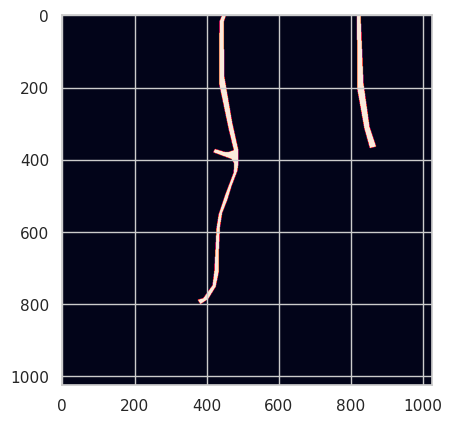